# 0. Setup

## 0.2 Import Packages

In [1]:
### ==== Core Python Packages ===== ###
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import matplotlib.pyplot as plt
import datetime
import shutil
import math
import importlib

### ===== Situational Python Packages ===== ###
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from scipy.stats import wilcoxon

### ===== Helper functions located in `./helpers.py` ===== ###
# Participant Data Handling
from helpers import filter_out_participants
from helpers import merge_participants
from helpers import merge_and_filter_participants
from helpers import participant_stats

# Time converters
from helpers import timestamp_to_unix_seconds as unix_seconds # Timestamps to Unix Seconds
from helpers import timestamp_to_unix_milliseconds as unix_milliseconds # Timestamps to Unix Milliseconds

# File Handling
from helpers import get_immediate_subdirectories
from helpers import get_immediate_files

# EEG Pre-processing
from helpers import process_raw_eeg

## 0.3 Constant Variables

In [2]:
### ===== Section 0.4: Participant Management ===== ###
_PARTICIPANTS_LIST_SRC = './samples/participants.csv'
_PARTICIPANTS_RENAME_DICT = {
    'ID':'participant', 
    'D1':'sex', 
    'VR1':'vr_experience',
    'VR2':'vr_frequency',
    'VR3':'vr_sickness',
    'OV1':'corrective_vision', 
    'OV2':'vision_diagnosis', 
    'OV3':'vision_condition', 
    'N1':'neural_diagnosis', 
    'N2':'neural_condition'
}

### ===== Section 1: Rest vs Concentration ===== ###
_RESTCONC_DIR = './samples/rest_conc_data/'  # URL for rest-vs-concentration tests
_POWER_COLS = [
    'Delta_AF7', 'Delta_AF8', 'Delta_TP9', 'Delta_TP10',
    'Theta_AF7', 'Theta_AF8', 'Theta_TP9', 'Theta_TP10',
    'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP9', 'Alpha_TP10',
    'Beta_AF7',  'Beta_AF8',  'Beta_TP9',  'Beta_TP10',
    'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP9', 'Gamma_TP10'
]

### ===== Section 2: VR Data ===== ###
_ALIGNED_DIR = './samples/participant_data_aligned/'
_FREQUENCY_BANDS = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
_ELECTRODE_CHANNELS = ['AF7', 'AF8', 'TP9', 'TP10']

## 0.4 Participant List

In [3]:
participants_df = pd.read_csv(_PARTICIPANTS_LIST_SRC)
participants_df = participants_df.iloc[1:]

# Renaming and setting column types
participants_df.rename(columns=_PARTICIPANTS_RENAME_DICT, inplace=True)
participants_df["age"] = pd.to_numeric(participants_df["D2"])
participants_df.drop(['Duration (in seconds)','D2','ResponseId', 'RecordedDate'], axis=1, inplace=True)

# Printing participant stats
participant_stats(participants_df)

### Sex Statistics:

sex
Male                         10
Female                        7
Non-binary / third gender     1
Name: count, dtype: int64


### VR Statistics:

vr_experience
Yes    14
No      4
Name: count, dtype: int64 

vr_frequency
I use VR sparingly or irregularly (ex. few times a year)        6
I had at least one experience in VR (ex. one-off situations)    6
I use VR occasionally (ex. a few times a month)                 1
I use VR frequently (ex. at least once a week)                  1
Name: count, dtype: int64 

vr_sickness
I never experienced simulator sickness in VR                            10
Depending on the virtual content, I sometimes get simulator sickness     3
I used to experience simulator sickness in VR, but not anymore           1
Name: count, dtype: int64


### Age Statistics:

age
24    5
25    4
23    4
32    2
41    1
22    1
18    1
Name: count, dtype: int64 

Age Mean: 25.38888888888889
Age Median: 24.0
Age SD: 5.030949961621551


### Vision Statistics:

corrective_vision
Yes, I have corrective vision         12
No, I do not have corrected vision     6
Name: count, dtype: int64 

vision_condition
I had Myopia and Astigmatism, but I had a corrective surgery - SMILE.    1
My glasses correct for some small amount of astigmatism.                 1
Name: count, dtype: int64


### Neural Statistics:

neural_diagnosis
No     17
Yes     1
Name: count, dtype: int64 

neural_condition
ADHD    1
Name: count, dtype: int64


### Participant Data:

,participant,sex,vr_experience,vr_frequency,vr_sickness,corrective_vision,vision_diagnosis,vision_condition,neural_diagnosis,neural_condition,age
0,p1,Female,No,None,None,"Yes, I have corrective vision",No,None,No,None,25
1,p10,Female,Yes,I use VR sparingly or irregularly (ex. few tim...,"Depending on the virtual content, I sometimes ...","No, I do not have corrected vision",No,None,No,None,23
2,p11,Male,No,None,None,"Yes, I have corrective vision",Yes,"I had Myopia and Astigmatism, but I had a corr...",No,None,25
3,p12,Female,Yes,I had at least one experience in VR (ex. one-o...,I never experienced simulator sickness in VR,"No, I do not have corrected vision",No,None,No,None,41
4,p13,Non-binary / third gender,Yes,I use VR sparingly or irregularly (ex. few tim...,I never experienced simulator sickness in VR,"No, I do not have corrected vision",No,None,No,None,32
5,p14,Male,Yes,I use VR occasionally (ex. a few times a month),I never experienced simulator sickness in VR,"No, I do not have corrected vision",No,None,No,None,23
6,p15,Male,Yes,I had at least one experience in VR (ex. one-o...,I never experienced simulator sickness in VR,"Yes, I have corrective vision",No,None,No,None,25
7,p16,Male,Yes,I had at least one experience in VR (ex. one-o...,I never experienced simulator sickness in VR,"Yes, I have corrective vision",No,None,No,None,25
8,p17,Male,Yes,I use VR sparingly or irregularly (ex. few tim...,"Depending on the virtual content, I sometimes ...","Yes, I have corrective vision",No,None,No,None,23
9,p18,Male,No,None,None,"Yes, I have corrective vision",Yes,My glasses correct for some small amount of as...,No,None,32


## 0.5 VR File Processing

Make sure you have processed the VR data from our `WorldToLocal` Unity3D project! __THIS IS ESSENTIAL!__ Each participant trial should have `pedestrians-aligned.csv` and `user-aligned.csv`. __NO EXCEPTIONS!__

# Step 1: Resting and Concentration EEG Analysis

This part of the notebook notebook is geared towards looking at resting and concentration data and identifying the following:

* How do we extract the mean and median data of each EEG file?
* How can we conduct some form of data analysis to identify if there's a significant difference between the data across different trial types? In particular:
    * Is there a significant difference between the resting state of the HMD vs non-HMD?
    * Is there a significant difference between the 2D and 3D red ball experiment?

## Keynotes

* __Data Src:__ `./samples/rest_conc_data/`
* __Preprocessing:__ Calculating median EEG power of all channels and frequency bands, across resting and concentration states, per participant
* __Statistical Test:__ Wilcoxon Signed Rank test: Median differences
* __Output:__ Single CSV file containing the necessary resting state for use in trial analysis

## Wilcoxon Signed Rank Test

* _Src: https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/how-to-conduct-the-wilcox-sign-test/_
* _Python Code: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html_

The idea of this entire analysis is to identify if the concentration condition produces a difference. AKA if the introduction of a red-ball concentration test induces people to create differences in concentration level. Of course, this assumes that we have some paired data (i.e. for each participant, we have a "before" and "after" condition). This, of course, is true - we have the rest state come before the concentration state in all participants. However, this kind of test assumes that our hypothesis is that "the red ball test resulted in a statistically significant difference in concentration levels among participants". The intention is subtle - in our original question, we posit whether there even is a difference, while the statistical significant test posits whether the introduction of a new condition __creates__ a difference. Subtle, to be sure, but something we must acknowledge. This means there's a dependence between the two conditions - a before and after, in most cases.

There might be some ways to go about this. One can try to identify which data corresponds with their order, then flip them accordingly. Another might be to just find the absolute differences so that we only care about the magnitude of the differences. This might be the direction we want to go down in the end - after all, our null hypothesis is that the introduction of the red ball concentration task does not induce a difference in eeg log power level. Since the log power effect is applied to all data columns and rows, seeing changes in that will also echo changes in the true absolute power of the eeg data.

For now, we go with Wilcoxon Signed Rank Test, which allows us to measure this difference without any assumption of normality in data points. We just have to account for the absolute difference in the condition instead.

Relevant Packages Used:

* `scipy.stats.wilcoxon` for Wilcoxon Signed Rank Test

## 1.1 Reading Raw EEG

We already have some prior assumptions: 1) we automatically remove the first and last 5 seconds of the provided EEG, no matter what, and 2) we want to use raw power, not log power.

In [4]:
# Read all rest-concentration files
restconc_files = get_immediate_files(_RESTCONC_DIR)
restconc_filenames = [os.path.join(_RESTCONC_DIR, f) for f in restconc_files]

# Save all dataframes in list
all_dfs = []
for f in restconc_filenames:
    # Filter - make sure it's a CSV file
    filename, file_extension = os.path.splitext(f)
    if file_extension != '.csv':
        print("\tSKIPPING - of type {file_extension}, not .csv")
        continue
    
    # Split the EEG filename into segments; delimiter = '-'. 
    #   names must be split into 3 segments: participant-task-tasktype
    segments = os.path.splitext(os.path.basename(f))[0].split('-')
    if len(segments)!=3:
        print(f"\tERROR: Cannot parse {f} - properly incorrectly named")
        continue
    
    # Read EEG and isolate rows to timestamps after 5 sec of the beginning and 5 sec before the end
    df = process_raw_eeg(f)    
    df['rel_unix_ms'] = df['unix_ms'] - df['unix_ms'].iloc[0]
    df = df[df['rel_unix_ms'].between(5000, df['rel_unix_ms'].iloc[-1]-5000)]
    df['trial_ms'] = df['rel_unix_ms'] - df['rel_unix_ms'].iloc[0]
    
    # Since we already have a DF in of itself, let's just append the data itself to this existing df
    df['participant'] = segments[0]
    df['task'] = segments[1]
    df['task_type'] = segments[2]
    
    # Left join on participant with participant data
    df2 = merge_participants(df, participants_df)
    
    # Save the resulting df into our `all_dfs` list
    all_dfs.append(df2)

# With all dfs saved, let's concat them all
rc_df = pd.concat(all_dfs)
rc_df

	SKIPPING - of type {file_extension}, not .csv
	ERROR: Cannot parse ./samples/rest_conc_data/medians_rest.csv - properly incorrectly named
	SKIPPING - of type {file_extension}, not .csv
	SKIPPING - of type {file_extension}, not .csv
	ERROR: Cannot parse ./samples/rest_conc_data/minmax_rest.csv - properly incorrectly named
	SKIPPING - of type {file_extension}, not .csv
	SKIPPING - of type {file_extension}, not .csv
	SKIPPING - of type {file_extension}, not .csv
	SKIPPING - of type {file_extension}, not .csv
	SKIPPING - of type {file_extension}, not .csv
	SKIPPING - of type {file_extension}, not .csv
	SKIPPING - of type {file_extension}, not .csv
	SKIPPING - of type {file_extension}, not .csv
	ERROR: Cannot parse ./samples/rest_conc_data/minmax_conc.csv - properly incorrectly named
	SKIPPING - of type {file_extension}, not .csv
	SKIPPING - of type {file_extension}, not .csv
	ERROR: Cannot parse ./samples/rest_conc_data/medians_conc.csv - properly incorrectly named
	SKIPPING - of type {fi

,AUX_RIGHT,AUX_LEFT,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,...,sex,vr_experience,vr_frequency,vr_sickness,corrective_vision,vision_diagnosis,vision_condition,neural_diagnosis,neural_condition,age
0,895.714286,745.018315,-0.139893,0.104370,0.982910,1.495361,-2.474823,1.428070,1.0,1.0,...,Male,No,NaN,NaN,"Yes, I have corrective vision",Yes,My glasses correct for some small amount of as...,No,NaN,32
1,867.509158,660.402930,-0.122437,0.113953,0.986938,-1.547699,-2.639313,-3.304749,1.0,1.0,...,Male,No,NaN,NaN,"Yes, I have corrective vision",Yes,My glasses correct for some small amount of as...,No,NaN,32
2,790.952381,592.710623,-0.118225,0.096436,0.993347,0.785065,-1.151428,0.934601,1.0,1.0,...,Male,No,NaN,NaN,"Yes, I have corrective vision",Yes,My glasses correct for some small amount of as...,No,NaN,32
3,778.461538,618.095238,-0.119202,0.095093,0.992065,0.575714,-1.024323,0.209351,1.0,1.0,...,Male,No,NaN,NaN,"Yes, I have corrective vision",Yes,My glasses correct for some small amount of as...,No,NaN,32
4,821.575092,643.882784,-0.124084,0.088562,0.991882,0.276642,-0.396271,-0.059814,1.0,1.0,...,Male,No,NaN,NaN,"Yes, I have corrective vision",Yes,My glasses correct for some small amount of as...,No,NaN,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,975.494505,NaN,-0.411926,0.009155,0.919312,-0.403748,-1.607513,-0.231781,1.0,1.0,...,Female,No,NaN,NaN,"Yes, I have corrective vision",No,NaN,No,NaN,25
11,571.355311,NaN,-0.416443,0.010681,0.912415,0.007477,-1.600037,-0.097198,1.0,1.0,...,Female,No,NaN,NaN,"Yes, I have corrective vision",No,NaN,No,NaN,25
12,897.326007,NaN,-0.415161,0.010559,0.915344,-0.336456,-1.846771,-0.515900,1.0,1.0,...,Female,No,NaN,NaN,"Yes, I have corrective vision",No,NaN,No,NaN,25
13,850.989011,NaN,-0.417480,0.010559,0.911804,0.022430,-0.837402,0.029907,1.0,1.0,...,Female,No,NaN,NaN,"Yes, I have corrective vision",No,NaN,No,NaN,25


## Checking for EEG Quality

_Has to be done on a per-participant base. Manually defined. Go for it._

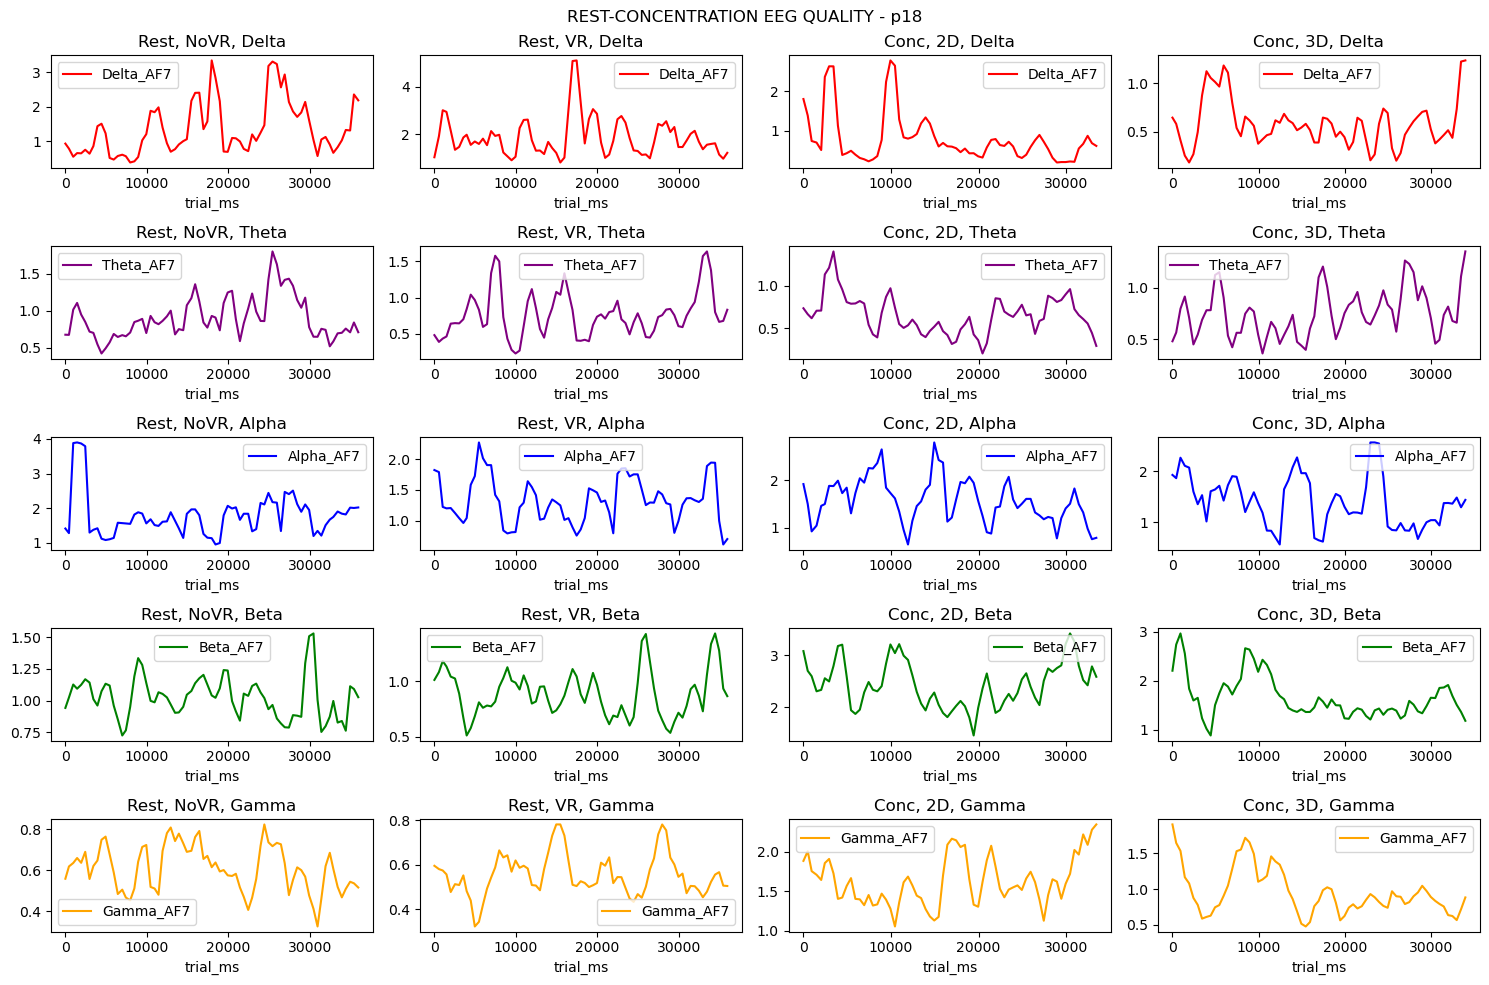

In [5]:
participant_id = 'p18'

fig, ax = plt.subplots(5,4)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle(f"REST-CONCENTRATION EEG QUALITY - {participant_id}")
prc_df = rc_df[rc_df['participant'] == participant_id]

pcr_rest_novr = prc_df[(prc_df['task']=='rest') & (prc_df['task_type']=='novr')]
pcr_rest_novr.plot.line(x='trial_ms',y='Delta_AF7', ax=ax[0,0], color='red', title='Rest, NoVR, Delta')
pcr_rest_novr.plot.line(x='trial_ms',y='Theta_AF7', ax=ax[1,0], color='purple', title='Rest, NoVR, Theta')
pcr_rest_novr.plot.line(x='trial_ms',y='Alpha_AF7', ax=ax[2,0], color='blue', title='Rest, NoVR, Alpha')
pcr_rest_novr.plot.line(x='trial_ms',y='Beta_AF7', ax=ax[3,0], color='green', title='Rest, NoVR, Beta')
pcr_rest_novr.plot.line(x='trial_ms',y='Gamma_AF7', ax=ax[4,0], color='orange', title='Rest, NoVR, Gamma')

pcr_rest_vr = prc_df[(prc_df['task']=='rest') & (prc_df['task_type']=='vr')]
pcr_rest_vr.plot.line(x='trial_ms',y='Delta_AF7', ax=ax[0,1], color='red', title='Rest, VR, Delta')
pcr_rest_vr.plot.line(x='trial_ms',y='Theta_AF7', ax=ax[1,1], color='purple', title='Rest, VR, Theta')
pcr_rest_vr.plot.line(x='trial_ms',y='Alpha_AF7', ax=ax[2,1], color='blue', title='Rest, VR, Alpha')
pcr_rest_vr.plot.line(x='trial_ms',y='Beta_AF7', ax=ax[3,1], color='green', title='Rest, VR, Beta')
pcr_rest_vr.plot.line(x='trial_ms',y='Gamma_AF7', ax=ax[4,1], color='orange', title='Rest, VR, Gamma')

pcr_conc_2d = prc_df[(prc_df['task']=='conc') & (prc_df['task_type']=='2d')]
pcr_conc_2d.plot.line(x='trial_ms',y='Delta_AF7', ax=ax[0,2], color='red', title='Conc, 2D, Delta')
pcr_conc_2d.plot.line(x='trial_ms',y='Theta_AF7', ax=ax[1,2], color='purple', title='Conc, 2D, Theta')
pcr_conc_2d.plot.line(x='trial_ms',y='Alpha_AF7', ax=ax[2,2], color='blue', title='Conc, 2D, Alpha')
pcr_conc_2d.plot.line(x='trial_ms',y='Beta_AF7', ax=ax[3,2], color='green', title='Conc, 2D, Beta')
pcr_conc_2d.plot.line(x='trial_ms',y='Gamma_AF7', ax=ax[4,2], color='orange', title='Conc, 2D, Gamma')

pcr_conc_3d = prc_df[(prc_df['task']=='conc') & (prc_df['task_type']=='3d')]
pcr_conc_3d.plot.line(x='trial_ms',y='Delta_AF7', ax=ax[0,3], color='red', title='Conc, 3D, Delta')
pcr_conc_3d.plot.line(x='trial_ms',y='Theta_AF7', ax=ax[1,3], color='purple', title='Conc, 3D, Theta')
pcr_conc_3d.plot.line(x='trial_ms',y='Alpha_AF7', ax=ax[2,3], color='blue', title='Conc, 3D, Alpha')
pcr_conc_3d.plot.line(x='trial_ms',y='Beta_AF7', ax=ax[3,3], color='green', title='Conc, 3D, Beta')
pcr_conc_3d.plot.line(x='trial_ms',y='Gamma_AF7', ax=ax[4,3], color='orange', title='Conc, 3D, Gamma')

plt.tight_layout()
plt.savefig(os.path.join(_RESTCONC_DIR, f'{participant_id}-restconc-eeg.png'), bbox_inches="tight", pad_inches=0.1,)
plt.show()


Participants that must be removed from analysis:

* __P7:__ Rest VR data plateaus often in all frequency bands
* __P13:__ Plateauing in Concentration 3D state.
* __P14:__ Plateauing in Concentration 2D state.
* __P15:__ Plateauing in odd places across all bands during concentration
* __P17:__ Plateauing across all frequency bands during Rest+VR

In [6]:
# stats about this population
rc_filtered_df = filter_out_participants(rc_df, participant_list=['p7','p13','p14','p15','p17'], neural_list=['Yes'])
participant_stats(rc_filtered_df)

### Sex Statistics:

sex
Female    6
Male      6
Name: count, dtype: int64


### VR Statistics:

vr_experience
Yes    9
No     3
Name: count, dtype: int64 

vr_frequency
I use VR sparingly or irregularly (ex. few times a year)        4
I had at least one experience in VR (ex. one-off situations)    4
I use VR frequently (ex. at least once a week)                  1
Name: count, dtype: int64 

vr_sickness
I never experienced simulator sickness in VR                            6
Depending on the virtual content, I sometimes get simulator sickness    2
I used to experience simulator sickness in VR, but not anymore          1
Name: count, dtype: int64


### Age Statistics:

age
24    4
25    3
23    2
41    1
32    1
22    1
Name: count, dtype: int64 

Age Mean: 26.0
Age Median: 24.0
Age SD: 5.34279463815095


### Vision Statistics:

corrective_vision
Yes, I have corrective vision         9
No, I do not have corrected vision    3
Name: count, dtype: int64 

vision_condition
I had Myopia and Astigmatism, but I had a corrective surgery - SMILE.    1
My glasses correct for some small amount of astigmatism.                 1
Name: count, dtype: int64


### Neural Statistics:

neural_diagnosis
No    12
Name: count, dtype: int64 

Series([], Name: count, dtype: int64)


### Participant Data:

,participant,AUX_RIGHT,AUX_LEFT,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,...,sex,vr_experience,vr_frequency,vr_sickness,corrective_vision,vision_diagnosis,vision_condition,neural_diagnosis,neural_condition,age
0,p1,656.373626,NaN,-0.184448,0.068359,0.980225,0.074768,-1.114044,-0.119629,1.0,...,Female,No,None,None,"Yes, I have corrective vision",No,None,No,None,25
1,p10,678.131868,NaN,-0.181580,0.154846,0.988892,2.437439,-2.871094,0.538330,1.0,...,Female,Yes,I use VR sparingly or irregularly (ex. few tim...,"Depending on the virtual content, I sometimes ...","No, I do not have corrected vision",No,None,No,None,23
2,p11,914.652015,NaN,-0.141846,0.092285,1.007812,2.452393,-1.600037,-0.373840,1.0,...,Male,No,None,None,"Yes, I have corrective vision",Yes,"I had Myopia and Astigmatism, but I had a corr...",No,None,25
3,p12,861.465201,NaN,-0.175476,0.129761,0.990417,2.437439,-0.949554,1.091614,1.0,...,Female,Yes,I had at least one experience in VR (ex. one-o...,I never experienced simulator sickness in VR,"No, I do not have corrected vision",No,None,No,None,41
4,p16,804.249084,645.091575,-0.335510,-0.000732,0.934326,-0.515900,-1.914062,1.024323,1.0,...,Male,Yes,I had at least one experience in VR (ex. one-o...,I never experienced simulator sickness in VR,"Yes, I have corrective vision",No,None,No,None,25
5,p18,895.714286,745.018315,-0.139893,0.104370,0.982910,1.495361,-2.474823,1.428070,1.0,...,Male,No,None,None,"Yes, I have corrective vision",Yes,My glasses correct for some small amount of as...,No,None,32
6,p2,734.945055,NaN,-0.123108,0.176514,0.982178,-0.074768,-0.994415,-0.523376,1.0,...,Male,Yes,I had at least one experience in VR (ex. one-o...,I never experienced simulator sickness in VR,"Yes, I have corrective vision",No,None,No,None,24
7,p3,744.615385,NaN,0.033936,0.038818,1.017273,2.272949,-2.093506,0.201874,1.0,...,Female,Yes,I use VR sparingly or irregularly (ex. few tim...,I never experienced simulator sickness in VR,"Yes, I have corrective vision",No,None,No,None,22
8,p4,650.732601,NaN,-0.214172,0.097656,0.982544,2.594452,-1.099091,0.157013,1.0,...,Female,Yes,I use VR frequently (ex. at least once a week),I never experienced simulator sickness in VR,"Yes, I have corrective vision",No,None,No,None,24
9,p5,1014.981685,NaN,-0.389221,0.087341,0.936401,3.013153,-1.734619,0.530853,1.0,...,Male,Yes,I had at least one experience in VR (ex. one-o...,"I used to experience simulator sickness in VR,...","Yes, I have corrective vision",No,None,No,None,24


## Extracting Median

In [7]:
rcm_df = rc_filtered_df.groupby(["participant", "task", "task_type"], as_index=False).agg({
    'Delta_AF7':'median', 
    'Delta_AF8':'median',
    'Delta_TP9':'median',
    'Delta_TP10':'median',
    'Theta_AF7':'median', 
    'Theta_AF8':'median',
    'Theta_TP9':'median',
    'Theta_TP10':'median',
    'Alpha_AF7':'median', 
    'Alpha_AF8':'median',
    'Alpha_TP9':'median',
    'Alpha_TP10':'median',
    'Beta_AF7':'median', 
    'Beta_AF8':'median',
    'Beta_TP9':'median',
    'Beta_TP10':'median',
    'Gamma_AF7':'median', 
    'Gamma_AF8':'median',
    'Gamma_TP9':'median',
    'Gamma_TP10':'median'
})
rcm_df

,participant,task,task_type,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
0,p1,conc,2d,2.421667,0.758858,2.721676,3.089107,1.489893,0.737490,5.086987,...,22.364547,19.898748,2.891895,4.817064,4.528606,4.007961,1.565658,2.458184,0.977801,1.291470
1,p1,conc,3d,1.365740,1.047261,2.769011,2.543855,1.304305,0.689698,2.597255,...,13.263048,9.336605,1.676709,3.665846,2.831374,3.075073,0.645626,2.099440,0.938084,1.165127
2,p1,rest,novr,3.287857,2.435449,2.763390,3.786698,1.072979,1.216981,4.548527,...,20.741302,13.581963,1.097606,1.077801,4.191806,4.594530,0.414310,0.405175,0.873780,1.260017
3,p1,rest,vr,5.954669,8.142710,17.684680,14.575367,2.572103,3.007136,7.726297,...,37.601783,33.735576,1.850552,4.011126,4.761077,5.203944,0.713746,2.212052,1.337531,1.707878
4,p10,conc,2d,0.684812,0.521281,1.310787,1.325072,0.601954,0.524907,1.130312,...,2.108619,2.699464,0.741887,0.758846,1.609465,2.612941,0.399109,0.352606,0.909343,1.351991
5,p10,conc,3d,1.531449,1.166611,1.399787,1.219144,0.782659,0.763900,1.234532,...,2.483794,2.964406,0.953636,1.014646,1.964481,2.734481,0.652446,0.551708,0.899358,1.206638
6,p10,rest,novr,1.016849,0.924834,3.442209,3.369089,0.667908,0.602886,1.646317,...,8.387506,6.316010,0.885896,0.813286,3.415923,2.723459,0.734470,0.401030,1.249021,1.102182
7,p10,rest,vr,1.227582,1.564639,2.664064,3.007974,0.587086,0.575648,2.098506,...,12.344325,11.432602,0.717564,0.819628,3.282139,4.000361,0.407004,0.344333,2.049078,2.337306
8,p11,conc,2d,1.104815,2.374553,2.313977,1.697138,1.028480,1.975379,2.442185,...,6.485536,4.520637,1.339138,2.074022,2.290632,2.553934,0.699750,1.150924,0.978595,1.302139
9,p11,conc,3d,1.299964,2.706687,2.299820,2.639660,1.135879,1.904581,2.538726,...,6.075340,4.858013,1.718397,1.932431,2.747827,2.578841,1.065098,1.476108,1.001813,1.324506


## Tests for Significance

In [8]:
def subtract_rows(group):
    return group[_POWER_COLS].iloc[1] - group[_POWER_COLS].iloc[0]

def test_wilcoxon(cols, df):
    latex_output = []
    for colname in cols:
        d = df[colname].tolist()
        twoside_res = wilcoxon(d)
        greater_res = wilcoxon(d, alternative='greater')
        less_res = wilcoxon(d, alternative='less')
        print(f"{colname}\t2S: {twoside_res.statistic}/{twoside_res.pvalue} \t|G: {greater_res.statistic}/{greater_res.pvalue}  \t|L: {less_res.statistic}/{less_res.pvalue}")
        latex_output.append(f'{colname}\t& {int(twoside_res.statistic)}, {round(twoside_res.pvalue,3)} & {int(greater_res.statistic)}, {round(greater_res.pvalue,3)} | {round(less_res.pvalue,3)} \\\\')
    print("--------------")
    print('\n'.join(latex_output)) 

### Influence of VR HMD Presence during Resting

In [9]:
rest_df = rcm_df[rcm_df['task'] == 'rest']
display(rest_df)
restdiff_df = rest_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

,participant,task,task_type,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
2,p1,rest,novr,3.287857,2.435449,2.763390,3.786698,1.072979,1.216981,4.548527,...,20.741302,13.581963,1.097606,1.077801,4.191806,4.594530,0.414310,0.405175,0.873780,1.260017
3,p1,rest,vr,5.954669,8.142710,17.684680,14.575367,2.572103,3.007136,7.726297,...,37.601783,33.735576,1.850552,4.011126,4.761077,5.203944,0.713746,2.212052,1.337531,1.707878
6,p10,rest,novr,1.016849,0.924834,3.442209,3.369089,0.667908,0.602886,1.646317,...,8.387506,6.316010,0.885896,0.813286,3.415923,2.723459,0.734470,0.401030,1.249021,1.102182
7,p10,rest,vr,1.227582,1.564639,2.664064,3.007974,0.587086,0.575648,2.098506,...,12.344325,11.432602,0.717564,0.819628,3.282139,4.000361,0.407004,0.344333,2.049078,2.337306
10,p11,rest,novr,0.933819,1.294426,4.133210,3.253853,0.796777,1.017527,3.656371,...,19.804172,13.486021,0.762611,0.828406,2.644390,2.398322,0.441422,0.434231,0.834377,0.935966
11,p11,rest,vr,1.815453,1.536854,3.560186,3.118407,0.970480,0.771441,3.484675,...,14.977300,11.090215,0.874181,0.713925,2.920661,2.528735,0.365755,0.367242,1.266903,1.120820
14,p12,rest,novr,1.074141,1.176943,1.979521,2.644184,0.773128,0.705856,2.103653,...,7.592356,10.048061,0.840602,0.797125,2.384263,2.800089,0.398537,0.349703,0.617913,0.722034
15,p12,rest,vr,1.363466,1.349496,4.196003,3.364101,0.831641,0.999404,2.704076,...,8.656379,9.240985,0.884196,0.927513,2.747504,3.114512,0.373398,0.444638,0.923366,1.108644
18,p16,rest,novr,1.723087,1.357252,1.540960,1.605309,0.567124,0.472542,1.441634,...,7.455117,8.433652,0.996009,0.747528,3.023050,3.360388,0.574973,0.496279,2.369631,2.329314
19,p16,rest,vr,1.820033,1.646017,1.200716,1.457692,0.784579,0.667331,1.095837,...,5.744205,6.116820,1.272707,1.033638,3.002864,3.185326,0.961449,0.685654,2.501110,2.454492


/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_57067/786220593.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_df.groupby(['participant'], as_index=False).apply(subtract_rows)


,participant,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,Theta_TP10,Alpha_AF7,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
0,p1,2.666813,5.707260,14.921290,10.788668,1.499124,1.790155,3.177770,5.369929,2.207686,...,16.860481,20.153613,0.752946,2.933325,0.569271,0.609414,0.299436,1.806877,0.463750,0.447862
1,p10,0.210733,0.639805,-0.778146,-0.361115,-0.080822,-0.027238,0.452189,-0.362697,0.201329,...,3.956819,5.116592,-0.168332,0.006342,-0.133784,1.276902,-0.327466,-0.056697,0.800057,1.235123
2,p11,0.881634,0.242428,-0.573024,-0.135446,0.173703,-0.246086,-0.171696,-0.097588,0.439340,...,-4.826872,-2.395806,0.111570,-0.114480,0.276271,0.130413,-0.075666,-0.066989,0.432526,0.184855
3,p12,0.289324,0.172553,2.216482,0.719917,0.058513,0.293548,0.600423,-0.685405,0.088898,...,1.064024,-0.807076,0.043594,0.130388,0.363241,0.314422,-0.025139,0.094935,0.305453,0.386610
4,p16,0.096946,0.288765,-0.340244,-0.147617,0.217455,0.194789,-0.345797,-0.118989,0.555566,...,-1.710912,-2.316832,0.276698,0.286110,-0.020186,-0.175062,0.386476,0.189375,0.131478,0.125178
5,p18,0.577812,0.400849,-2.942753,-3.312657,-0.114194,0.180874,-0.548169,-0.623265,-0.445186,...,0.813657,1.785393,-0.156623,-0.111336,0.400109,-0.347097,-0.070715,-0.011057,0.628437,0.019356
6,p2,3.111961,-3.010376,0.957990,1.419078,0.709275,-1.292357,0.078047,0.539515,0.482431,...,-0.333008,0.157378,0.025524,0.516468,0.195309,0.985041,0.092693,0.604238,0.259321,0.301257
7,p3,1.851015,1.469497,-0.743198,-39.413518,0.312549,0.323089,0.113941,-8.771193,-0.024049,...,-7.307473,-1.022900,0.682658,0.859667,0.299161,-1.798141,0.594868,0.634945,0.592133,0.146959
8,p4,0.819064,4.773974,5.845665,0.102782,0.004912,0.577146,1.882410,-0.055751,0.046917,...,-0.523482,0.851908,0.707494,0.234856,-0.727123,-0.406357,0.920783,-0.041805,0.730507,0.558961
9,p5,-0.784946,1.717120,-1.972059,0.559881,-0.213529,-0.028840,0.205886,0.618587,0.298254,...,0.178808,0.033811,0.004415,0.042954,0.128559,0.145807,0.040332,-0.012861,0.347838,0.196134


Delta_AF7	2S: 12.0/0.0341796875 	|G: 66.0/0.01708984375  	|L: 66.0/0.986572265625
Delta_AF8	2S: 19.0/0.12939453125 	|G: 59.0/0.064697265625  	|L: 59.0/0.945068359375
Delta_TP9	2S: 33.0/0.67724609375 	|G: 45.0/0.338623046875  	|L: 45.0/0.68896484375
Delta_TP10	2S: 38.0/0.9697265625 	|G: 40.0/0.48486328125  	|L: 40.0/0.545166015625
Theta_AF7	2S: 16.0/0.0771484375 	|G: 62.0/0.03857421875  	|L: 62.0/0.968017578125
Theta_AF8	2S: 29.0/0.4697265625 	|G: 49.0/0.23486328125  	|L: 49.0/0.7880859375
Theta_TP9	2S: 24.0/0.26611328125 	|G: 54.0/0.133056640625  	|L: 54.0/0.88330078125
Theta_TP10	2S: 31.0/0.5693359375 	|G: 31.0/0.74072265625  	|L: 31.0/0.28466796875
Alpha_AF7	2S: 13.0/0.04248046875 	|G: 65.0/0.021240234375  	|L: 65.0/0.98291015625
Alpha_AF8	2S: 19.0/0.12939453125 	|G: 59.0/0.064697265625  	|L: 59.0/0.945068359375
Alpha_TP9	2S: 39.0/1.0 	|G: 39.0/0.51513671875  	|L: 39.0/0.51513671875
Alpha_TP10	2S: 34.0/0.7333984375 	|G: 44.0/0.36669921875  	|L: 44.0/0.661376953125
Beta_AF7	2S: 18.0/0

* __Null Hypothesis:__ The act and state of wearing a virtual reality (VR) head-mounted display (HMD) during rest will not create a significant difference in the power of all frequency bands

We reject the null hypothesis for the selected frequency bands and electrode channels:
* __2-Sided__:
    * Beta AF8
    * Gamma TP9, TP10
* __Greater__:
    * Delta AF7, AF8
    * Beta AF8
    * Gamma TP9, TP10
* __Less__: **_NONE_** - We cannot reject the null hypothesis

Given that we are primarily interested in the Alpha, Beta, and Gamma bands, the fact that we DO get a response from those bands is somewhat promising. What is a little weird though is that the Alpha only has AF7, Beta only has AF8, and Gamma is... gamma for TP9 and TP10. We don't really want to explore TP9 or TP10, so this is a little curious. I think though it can be said at least that the EEG data for TP9 and TP10 is at least stable. Or at least I would like to think so. They're certainly more stable than the real-world condition.

### 3D vs. 2D Concentration

In [10]:
rest_df = rcm_df[rcm_df['task'] == 'conc']
display(rest_df)
restdiff_df = rest_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

,participant,task,task_type,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
0,p1,conc,2d,2.421667,0.758858,2.721676,3.089107,1.489893,0.737490,5.086987,...,22.364547,19.898748,2.891895,4.817064,4.528606,4.007961,1.565658,2.458184,0.977801,1.291470
1,p1,conc,3d,1.365740,1.047261,2.769011,2.543855,1.304305,0.689698,2.597255,...,13.263048,9.336605,1.676709,3.665846,2.831374,3.075073,0.645626,2.099440,0.938084,1.165127
4,p10,conc,2d,0.684812,0.521281,1.310787,1.325072,0.601954,0.524907,1.130312,...,2.108619,2.699464,0.741887,0.758846,1.609465,2.612941,0.399109,0.352606,0.909343,1.351991
5,p10,conc,3d,1.531449,1.166611,1.399787,1.219144,0.782659,0.763900,1.234532,...,2.483794,2.964406,0.953636,1.014646,1.964481,2.734481,0.652446,0.551708,0.899358,1.206638
8,p11,conc,2d,1.104815,2.374553,2.313977,1.697138,1.028480,1.975379,2.442185,...,6.485536,4.520637,1.339138,2.074022,2.290632,2.553934,0.699750,1.150924,0.978595,1.302139
9,p11,conc,3d,1.299964,2.706687,2.299820,2.639660,1.135879,1.904581,2.538726,...,6.075340,4.858013,1.718397,1.932431,2.747827,2.578841,1.065098,1.476108,1.001813,1.324506
12,p12,conc,2d,0.790178,0.924024,2.389361,2.882065,0.748846,0.665558,1.814321,...,9.129616,7.897361,0.748563,0.758210,4.876441,7.115483,0.323526,0.309634,3.441808,5.961219
13,p12,conc,3d,0.727543,0.750968,1.696628,2.117494,0.731990,0.504424,3.025337,...,12.098755,7.129150,1.015241,0.756967,5.673204,3.748798,0.540315,0.292413,2.641894,1.606874
16,p16,conc,2d,0.607971,0.791193,1.380996,0.834026,0.635232,0.508167,1.088047,...,3.702226,9.254262,1.917599,1.754356,8.179354,10.394705,1.238034,1.226920,5.643625,5.597469
17,p16,conc,3d,0.730487,0.853625,1.157680,1.246623,0.585830,0.604934,0.984815,...,2.112646,4.513593,1.186399,1.115111,6.673125,7.565085,0.695028,0.760909,5.084890,4.527970


/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_57067/4090955483.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_df.groupby(['participant'], as_index=False).apply(subtract_rows)


,participant,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,Theta_TP10,Alpha_AF7,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
0,p1,-1.055926,0.288403,0.047335,-0.545252,-0.185588,-0.047791,-2.489732,-2.443030,1.249957,...,-9.101498,-10.562143,-1.215185,-1.151218,-1.697232,-0.932888,-0.920032,-0.358744,-0.039717,-0.126342
1,p10,0.846638,0.645330,0.089000,-0.105929,0.180705,0.238993,0.104220,0.329245,0.110738,...,0.375175,0.264942,0.211749,0.255800,0.355016,0.121540,0.253337,0.199102,-0.009985,-0.145354
2,p11,0.195149,0.332134,-0.014157,0.942522,0.107398,-0.070799,0.096541,0.454973,0.284883,...,-0.410195,0.337375,0.379259,-0.141591,0.457195,0.024907,0.365348,0.325184,0.023218,0.022367
3,p12,-0.062636,-0.173056,-0.692733,-0.764571,-0.016856,-0.161135,1.211016,-0.041568,-0.138584,...,2.969139,-0.768211,0.266678,-0.001243,0.796763,-3.366684,0.216790,-0.017221,-0.799914,-4.354344
4,p16,0.122515,0.062432,-0.223316,0.412597,-0.049402,0.096767,-0.103231,-0.289722,-0.174234,...,-1.589580,-4.740668,-0.731199,-0.639245,-1.506229,-2.829620,-0.543006,-0.466010,-0.558736,-1.069499
5,p18,-0.056635,0.113952,-0.128068,-0.109389,0.089114,-0.068624,0.098927,-0.104890,-0.160890,...,-0.817224,-0.745622,-0.890212,-1.454331,0.787135,1.427729,-0.720524,-1.365552,1.231340,1.553443
6,p2,0.321265,0.368924,0.322494,-0.677826,0.391213,0.146203,0.267013,-0.557100,0.303471,...,0.348227,-1.472730,0.463556,0.402231,0.143915,-0.061116,0.245623,0.049143,-0.076060,-0.007243
7,p3,-0.738642,-0.564413,2.090929,-5.178562,-0.331776,-0.346701,0.174466,-1.441026,-0.834845,...,0.779604,-0.868831,-4.325142,-11.380686,-1.372879,-1.321232,-2.713169,-3.958519,-0.763239,-0.612026
8,p4,-0.097429,-0.569460,-6.271792,0.071320,-0.021840,-0.260711,-1.558875,0.120605,-0.148382,...,2.251566,0.838682,0.884677,-0.379245,-0.552690,-0.286984,0.700348,-0.143113,-0.228219,0.157767
9,p5,2.962649,1.257171,0.340538,0.185498,0.466148,0.221477,0.246154,-0.118068,-0.038316,...,-0.255483,-0.810966,0.264243,-0.117169,0.075600,0.110402,0.203519,-0.260033,-0.031911,-0.515952


Delta_AF7	2S: 30.0/0.5185546875 	|G: 48.0/0.25927734375  	|L: 48.0/0.76513671875
Delta_AF8	2S: 24.0/0.26611328125 	|G: 54.0/0.133056640625  	|L: 54.0/0.88330078125
Delta_TP9	2S: 36.0/0.85009765625 	|G: 36.0/0.6044921875  	|L: 36.0/0.425048828125
Delta_TP10	2S: 31.0/0.5693359375 	|G: 31.0/0.74072265625  	|L: 31.0/0.28466796875
Theta_AF7	2S: 30.0/0.5185546875 	|G: 48.0/0.25927734375  	|L: 48.0/0.76513671875
Theta_AF8	2S: 37.0/0.90966796875 	|G: 37.0/0.574951171875  	|L: 37.0/0.454833984375
Theta_TP9	2S: 36.0/0.85009765625 	|G: 42.0/0.425048828125  	|L: 42.0/0.6044921875
Theta_TP10	2S: 23.0/0.2333984375 	|G: 23.0/0.898193359375  	|L: 23.0/0.11669921875
Alpha_AF7	2S: 38.0/0.9697265625 	|G: 38.0/0.545166015625  	|L: 38.0/0.48486328125
Alpha_AF8	2S: 33.0/0.67724609375 	|G: 33.0/0.68896484375  	|L: 33.0/0.338623046875
Alpha_TP9	2S: 34.0/0.7333984375 	|G: 34.0/0.661376953125  	|L: 34.0/0.36669921875
Alpha_TP10	2S: 14.0/0.05224609375 	|G: 14.0/0.978759765625  	|L: 14.0/0.026123046875
Beta_AF7	2

### No-HMD Rest and 3D

In [11]:
rest_df = rcm_df[rcm_df['task_type'].isin(["novr","3d"])]
# Re-sort so that the rest comes before the concentration task
rest_sorted_df = rest_df.sort_values(['participant','task'],ascending=False).groupby('participant').head(50)
display(rest_sorted_df)
restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

,participant,task,task_type,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
46,p8,rest,novr,3.818781,3.623947,6.028109,6.404499,1.329842,1.188136,3.617668,...,20.143688,21.245142,1.219946,1.289234,3.097450,3.413089,0.553253,0.684206,0.983646,1.183044
45,p8,conc,3d,0.750727,0.658324,2.825632,2.224596,0.667771,0.687988,1.472557,...,4.360431,4.309493,1.549634,2.223638,2.256715,3.428111,0.861099,1.569216,0.798302,1.851377
42,p6,rest,novr,0.863976,0.687239,1.801453,1.729639,0.712998,0.671202,1.532385,...,2.062381,2.735771,0.774580,0.651591,1.705017,1.841681,0.332532,0.287156,0.915774,1.240759
41,p6,conc,3d,0.447560,0.451129,1.700293,1.386748,0.526023,0.462785,1.160902,...,2.525450,2.853588,1.206097,0.740990,1.441978,1.668466,1.012908,0.406696,0.902335,0.788436
38,p5,rest,novr,2.525982,1.797261,5.985848,4.779603,0.795044,0.640830,1.429908,...,4.250179,4.952356,0.797074,0.665506,3.178240,2.152815,0.311684,0.329412,1.839928,0.767571
37,p5,conc,3d,3.756987,3.222048,2.460659,2.160988,1.141040,0.953405,1.733185,...,2.584376,2.035863,2.739959,2.058286,3.791689,3.913115,1.835278,1.177487,1.955481,1.510478
34,p4,rest,novr,0.859322,1.157295,5.363078,3.536692,0.667510,0.730517,2.799237,...,12.472344,11.209037,2.066910,1.476754,6.265233,7.141636,0.849448,0.520433,1.147376,2.135622
33,p4,conc,3d,0.534943,0.875478,5.475603,1.952503,0.565359,0.623720,2.641036,...,7.191113,5.214285,3.749199,1.578406,6.475178,5.635994,4.149819,0.818330,2.134351,2.365814
30,p3,rest,novr,1.716235,1.651316,8.856311,45.588167,0.690335,0.644613,3.746790,...,18.955259,11.032357,0.867878,0.780588,3.216961,4.819864,0.360614,0.337337,0.745684,1.134080
29,p3,conc,3d,0.924215,0.748990,5.573614,2.242238,0.587807,0.574598,2.616921,...,7.969218,5.004869,10.059439,7.124037,4.094450,3.751030,4.705529,4.892585,1.741925,1.770919


/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_57067/1127709336.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)


,participant,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,Theta_TP10,Alpha_AF7,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
0,p1,-1.922116,-1.388188,0.005621,-1.242844,0.231325,-0.527283,-1.951273,-1.920999,1.611098,...,-7.478253,-4.245357,0.579103,2.588045,-1.360432,-1.519457,0.231316,1.694265,0.064304,-0.094889
1,p10,0.514600,0.241777,-2.042423,-2.149945,0.114750,0.161014,-0.411785,-0.553811,0.361300,...,-5.903712,-3.351604,0.067740,0.201360,-1.451442,0.011022,-0.082024,0.150678,-0.349663,0.104455
2,p11,0.366145,1.412261,-1.833390,-0.614192,0.339102,0.887054,-1.117645,-0.472872,0.735841,...,-13.728832,-8.628008,0.955786,1.104025,0.103437,0.180519,0.623677,1.041877,0.167436,0.388540
3,p12,-0.346599,-0.425974,-0.282893,-0.526690,-0.041138,-0.201432,0.921684,-0.751699,-0.161916,...,4.506399,-2.918912,0.174639,-0.040158,3.288941,0.948709,0.141778,-0.057290,2.023981,0.884840
4,p16,-0.992600,-0.503627,-0.383280,-0.358686,0.018706,0.132392,-0.456818,-0.252274,-0.000755,...,-5.342471,-3.920058,0.190390,0.367582,3.650075,4.204697,0.120055,0.264630,2.715258,2.198656
5,p18,-0.545207,-0.341973,-5.068356,-5.424607,-0.110528,-0.161600,-1.078698,-1.164595,-0.371847,...,-3.843374,-5.768347,0.485099,0.038021,1.299993,1.128055,0.270524,0.153498,2.121049,1.761858
6,p2,-3.414297,-5.405800,-0.992134,0.046728,-0.267198,-1.940426,-0.047443,0.530632,-0.290718,...,0.321790,0.068579,0.254008,0.966056,0.050122,0.252673,0.342505,0.901485,0.218942,0.005157
7,p3,-0.792020,-0.902326,-3.282697,-43.345929,-0.102528,-0.070015,-1.129869,-10.884887,-0.649805,...,-10.986041,-6.027487,9.191561,6.343449,0.877488,-1.068834,4.344915,4.555248,0.996241,0.636838
8,p4,-0.324379,-0.281817,0.112525,-1.584189,-0.102151,-0.106797,-0.158201,-0.643099,-0.379899,...,-5.281230,-5.994752,1.682289,0.101651,0.209945,-1.505641,3.300371,0.297896,0.986975,0.230192
9,p5,1.231005,1.424786,-3.525188,-2.618615,0.345996,0.312575,0.303277,-0.464843,0.475726,...,-1.665803,-2.916493,1.942885,1.392780,0.613449,1.760300,1.523594,0.848075,0.115553,0.742908


Delta_AF7	2S: 17.0/0.09228515625 	|G: 17.0/0.96142578125  	|L: 17.0/0.046142578125
Delta_AF8	2S: 21.0/0.17626953125 	|G: 21.0/0.92431640625  	|L: 21.0/0.088134765625
Delta_TP9	2S: 4.0/0.00341796875 	|G: 4.0/0.998779296875  	|L: 4.0/0.001708984375
Delta_TP10	2S: 1.0/0.0009765625 	|G: 1.0/0.999755859375  	|L: 1.0/0.00048828125
Theta_AF7	2S: 36.0/0.85009765625 	|G: 36.0/0.6044921875  	|L: 36.0/0.425048828125
Theta_AF8	2S: 26.0/0.33935546875 	|G: 26.0/0.849365234375  	|L: 26.0/0.169677734375
Theta_TP9	2S: 10.0/0.02099609375 	|G: 10.0/0.991943359375  	|L: 10.0/0.010498046875
Theta_TP10	2S: 4.0/0.00341796875 	|G: 4.0/0.998779296875  	|L: 4.0/0.001708984375
Alpha_AF7	2S: 38.0/0.9697265625 	|G: 38.0/0.545166015625  	|L: 38.0/0.48486328125
Alpha_AF8	2S: 32.0/0.6220703125 	|G: 46.0/0.31103515625  	|L: 46.0/0.71533203125
Alpha_TP9	2S: 8.0/0.01220703125 	|G: 8.0/0.995361328125  	|L: 8.0/0.006103515625
Alpha_TP10	2S: 3.0/0.00244140625 	|G: 3.0/0.999267578125  	|L: 3.0/0.001220703125
Beta_AF7	2S: 0.

### HMD vs 3D

In [12]:
rest_df = rcm_df[rcm_df['task_type'].isin(["vr","3d"])]
# Re-sort so that the rest comes before the concentration task
rest_sorted_df = rest_df.sort_values(['participant','task'],ascending=False).groupby('participant').head(50)
display(rest_sorted_df)
restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

,participant,task,task_type,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
47,p8,rest,vr,3.492866,1.290986,3.496320,3.333834,1.639412,0.861404,2.985276,...,18.428197,15.237095,3.620767,3.278763,4.436958,5.036065,1.985738,2.449434,2.396909,2.523007
45,p8,conc,3d,0.750727,0.658324,2.825632,2.224596,0.667771,0.687988,1.472557,...,4.360431,4.309493,1.549634,2.223638,2.256715,3.428111,0.861099,1.569216,0.798302,1.851377
43,p6,rest,vr,1.132475,1.630815,5.585042,6.268826,0.724552,0.741795,2.419073,...,3.823632,5.508183,0.624964,0.640268,1.456541,1.939804,0.303341,0.330059,0.776469,0.855661
41,p6,conc,3d,0.447560,0.451129,1.700293,1.386748,0.526023,0.462785,1.160902,...,2.525450,2.853588,1.206097,0.740990,1.441978,1.668466,1.012908,0.406696,0.902335,0.788436
39,p5,rest,vr,1.741036,3.514381,4.013788,5.339483,0.581515,0.611990,1.635794,...,4.428987,4.986167,0.801489,0.708460,3.306799,2.298622,0.352016,0.316551,2.187767,0.963705
37,p5,conc,3d,3.756987,3.222048,2.460659,2.160988,1.141040,0.953405,1.733185,...,2.584376,2.035863,2.739959,2.058286,3.791689,3.913115,1.835278,1.177487,1.955481,1.510478
35,p4,rest,vr,1.678386,5.931269,11.208743,3.639474,0.672422,1.307664,4.681646,...,11.948861,12.060945,2.774404,1.711611,5.538110,6.735279,1.770231,0.478629,1.877883,2.694583
33,p4,conc,3d,0.534943,0.875478,5.475603,1.952503,0.565359,0.623720,2.641036,...,7.191113,5.214285,3.749199,1.578406,6.475178,5.635994,4.149819,0.818330,2.134351,2.365814
31,p3,rest,vr,3.567250,3.120813,8.113113,6.174649,1.002884,0.967701,3.860731,...,11.647786,10.009457,1.550536,1.640256,3.516122,3.021724,0.955481,0.972282,1.337817,1.281039
29,p3,conc,3d,0.924215,0.748990,5.573614,2.242238,0.587807,0.574598,2.616921,...,7.969218,5.004869,10.059439,7.124037,4.094450,3.751030,4.705529,4.892585,1.741925,1.770919


/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_57067/3468407299.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)


,participant,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,Theta_TP10,Alpha_AF7,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
0,p1,-4.588929,-7.095449,-14.915669,-12.031512,-1.267798,-2.317437,-5.129043,-7.290927,-0.596588,...,-24.338735,-24.398971,-0.173843,-0.345280,-1.929704,-2.128871,-0.068120,-0.112612,-0.399446,-0.542751
1,p10,0.303867,-0.398028,-1.264277,-1.788830,0.195573,0.188253,-0.863974,-0.191114,0.159971,...,-9.860531,-8.468196,0.236072,0.195018,-1.317658,-1.265880,0.245442,0.207375,-1.149720,-1.130668
2,p11,-0.515489,1.169833,-1.260366,-0.478747,0.165399,1.133140,-0.945949,-0.375284,0.296501,...,-8.901960,-6.232202,0.844216,1.218506,-0.172834,0.050105,0.699343,1.108866,-0.265091,0.203686
3,p12,-0.635923,-0.598527,-2.499375,-1.246607,-0.099650,-0.494980,0.321261,-0.066294,-0.250814,...,3.442376,-2.111836,0.131045,-0.170545,2.925700,0.634286,0.166917,-0.152226,1.718528,0.498231
4,p16,-1.089547,-0.792392,-0.043036,-0.211069,-0.198749,-0.062397,-0.111021,-0.133284,-0.556321,...,-3.631559,-1.603226,-0.086308,0.081473,3.670262,4.379759,-0.266421,0.075256,2.583780,2.073478
5,p18,-1.123019,-0.742822,-2.125603,-2.111950,0.003667,-0.342474,-0.530528,-0.541331,0.073340,...,-4.657031,-7.553740,0.641722,0.149357,0.899883,1.475153,0.341239,0.164556,1.492612,1.742503
6,p2,-6.526259,-2.395425,-1.950123,-1.372350,-0.976473,-0.648070,-0.125490,-0.008883,-0.773149,...,0.654798,-0.088799,0.228483,0.449588,-0.145187,-0.732368,0.249812,0.297247,-0.040380,-0.296099
7,p3,-2.643036,-2.371824,-2.539499,-3.932412,-0.415077,-0.393103,-1.243810,-2.113694,-0.625755,...,-3.678568,-5.004587,8.508903,5.483782,0.578327,0.729307,3.750047,3.920303,0.404108,0.489880
8,p4,-1.143443,-5.055791,-5.733140,-1.686971,-0.107063,-0.683944,-2.040611,-0.587349,-0.426816,...,-4.757748,-6.846660,0.974795,-0.133205,0.937067,-1.099285,2.379588,0.339701,0.256468,-0.328769
9,p5,2.015951,-0.292334,-1.553129,-3.178495,0.559525,0.341415,0.097391,-1.083430,0.177471,...,-1.844611,-2.950304,1.938470,1.349826,0.484890,1.614493,1.483262,0.860937,-0.232286,0.546773


Delta_AF7	2S: 9.0/0.01611328125 	|G: 9.0/0.993896484375  	|L: 9.0/0.008056640625
Delta_AF8	2S: 7.0/0.00927734375 	|G: 7.0/0.99658203125  	|L: 7.0/0.004638671875
Delta_TP9	2S: 0.0/0.00048828125 	|G: 0.0/1.0  	|L: 0.0/0.000244140625
Delta_TP10	2S: 0.0/0.00048828125 	|G: 0.0/1.0  	|L: 0.0/0.000244140625
Theta_AF7	2S: 19.0/0.12939453125 	|G: 19.0/0.945068359375  	|L: 19.0/0.064697265625
Theta_AF8	2S: 19.0/0.12939453125 	|G: 19.0/0.945068359375  	|L: 19.0/0.064697265625
Theta_TP9	2S: 5.0/0.0048828125 	|G: 5.0/0.998291015625  	|L: 5.0/0.00244140625
Theta_TP10	2S: 0.0/0.00048828125 	|G: 0.0/1.0  	|L: 0.0/0.000244140625
Alpha_AF7	2S: 14.0/0.05224609375 	|G: 14.0/0.978759765625  	|L: 14.0/0.026123046875
Alpha_AF8	2S: 17.0/0.09228515625 	|G: 17.0/0.96142578125  	|L: 17.0/0.046142578125
Alpha_TP9	2S: 5.0/0.0048828125 	|G: 5.0/0.998291015625  	|L: 5.0/0.00244140625
Alpha_TP10	2S: 0.0/0.00048828125 	|G: 0.0/1.0  	|L: 0.0/0.000244140625
Beta_AF7	2S: 15.0/0.06396484375 	|G: 63.0/0.031982421875  	|L: 

### NoHMD vs 2D

In [13]:
rest_df = rcm_df[rcm_df['task_type'].isin(["novr","2d"])]
# Re-sort so that the rest comes before the concentration task
rest_sorted_df = rest_df.sort_values(['participant','task'],ascending=False).groupby('participant').head(50)
display(rest_sorted_df)
restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

,participant,task,task_type,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
46,p8,rest,novr,3.818781,3.623947,6.028109,6.404499,1.329842,1.188136,3.617668,...,20.143688,21.245142,1.219946,1.289234,3.097450,3.413089,0.553253,0.684206,0.983646,1.183044
44,p8,conc,2d,0.617387,0.481458,6.493757,2.072793,0.621887,0.565792,3.060911,...,6.756685,4.815929,1.919258,3.358305,2.890244,3.073924,1.202423,2.459411,0.993601,1.418103
42,p6,rest,novr,0.863976,0.687239,1.801453,1.729639,0.712998,0.671202,1.532385,...,2.062381,2.735771,0.774580,0.651591,1.705017,1.841681,0.332532,0.287156,0.915774,1.240759
40,p6,conc,2d,0.513856,0.494149,1.467539,1.393094,0.542927,0.476439,1.036147,...,2.314730,2.798075,1.080558,0.719679,1.587410,1.558999,0.657492,0.366851,0.935664,0.807018
38,p5,rest,novr,2.525982,1.797261,5.985848,4.779603,0.795044,0.640830,1.429908,...,4.250179,4.952356,0.797074,0.665506,3.178240,2.152815,0.311684,0.329412,1.839928,0.767571
36,p5,conc,2d,0.794338,1.964877,2.120122,1.975491,0.674893,0.731928,1.487031,...,2.839858,2.846829,2.475716,2.175455,3.716089,3.802713,1.631759,1.437520,1.987392,2.026430
34,p4,rest,novr,0.859322,1.157295,5.363078,3.536692,0.667510,0.730517,2.799237,...,12.472344,11.209037,2.066910,1.476754,6.265233,7.141636,0.849448,0.520433,1.147376,2.135622
32,p4,conc,2d,0.632373,1.444938,11.747395,1.881182,0.587200,0.884431,4.199911,...,4.939548,4.375603,2.864522,1.957651,7.027868,5.922978,3.449471,0.961443,2.362570,2.208047
30,p3,rest,novr,1.716235,1.651316,8.856311,45.588167,0.690335,0.644613,3.746790,...,18.955259,11.032357,0.867878,0.780588,3.216961,4.819864,0.360614,0.337337,0.745684,1.134080
28,p3,conc,2d,1.662857,1.313403,3.482685,7.420800,0.919583,0.921299,2.442454,...,7.189614,5.873700,14.384581,18.504724,5.467329,5.072262,7.418697,8.851103,2.505164,2.382944


/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_57067/780228375.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)


,participant,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,Theta_TP10,Alpha_AF7,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
0,p1,-0.866190,-1.676591,-0.041714,-0.697592,0.416914,-0.479491,0.538460,0.522032,0.361142,...,1.623245,6.316786,1.794289,3.739263,0.336800,-0.586569,1.151348,2.053010,0.104021,0.031453
1,p10,-0.332038,-0.403553,-2.131422,-2.044017,-0.065955,-0.077979,-0.516005,-0.883056,0.250562,...,-6.278887,-3.616546,-0.144009,-0.054440,-1.806458,-0.110518,-0.335361,-0.048424,-0.339678,0.249809
2,p11,0.170996,1.080127,-1.819233,-1.556714,0.231704,0.957853,-1.214186,-0.927845,0.450959,...,-13.318637,-8.965383,0.576527,1.245617,-0.353758,0.155612,0.258329,0.716693,0.144218,0.366173
3,p12,-0.283963,-0.252919,0.409840,0.237881,-0.024282,-0.040297,-0.289332,-0.710131,-0.023332,...,1.537260,-2.150701,-0.092039,-0.038915,2.492178,4.315393,-0.075011,-0.040069,2.823895,5.239185
4,p16,-1.115116,-0.566060,-0.159964,-0.771283,0.068108,0.035624,-0.353587,0.037448,0.173478,...,-3.752891,0.820610,0.921590,1.006828,5.156305,7.034317,0.663061,0.730641,3.273994,3.268155
5,p18,-0.488573,-0.455925,-4.940288,-5.315218,-0.199642,-0.092976,-1.177625,-1.059705,-0.210957,...,-3.026150,-5.022725,1.375311,1.492352,0.512857,-0.299674,0.991049,1.519050,0.889709,0.208415
6,p2,-3.735562,-5.774724,-1.314628,0.724554,-0.658410,-2.086630,-0.314456,1.087732,-0.594189,...,-0.026437,1.541308,-0.209549,0.563825,-0.093793,0.313788,0.096881,0.852341,0.295001,0.012400
7,p3,-0.053378,-0.337913,-5.373625,-38.167367,0.229249,0.276686,-1.304335,-9.443861,0.185040,...,-11.765645,-5.158656,13.516703,17.724136,2.250367,0.252398,7.058083,8.513766,1.759479,1.248864
8,p4,-0.226950,0.287643,6.384317,-1.655510,-0.080310,0.153914,1.400674,-0.763704,-0.231517,...,-7.532796,-6.833434,0.797612,0.480897,0.762635,-1.218658,2.600023,0.441009,1.215194,0.072425
9,p5,-1.731644,0.167615,-3.865726,-2.804112,-0.120151,0.091097,0.057123,-0.346774,0.514042,...,-1.410320,-2.105527,1.678642,1.509949,0.537848,1.649898,1.320075,1.108108,0.147464,1.258860


Delta_AF7	2S: 2.0/0.00146484375 	|G: 2.0/0.99951171875  	|L: 2.0/0.000732421875
Delta_AF8	2S: 14.0/0.05224609375 	|G: 14.0/0.978759765625  	|L: 14.0/0.026123046875
Delta_TP9	2S: 21.0/0.17626953125 	|G: 21.0/0.92431640625  	|L: 21.0/0.088134765625
Delta_TP10	2S: 5.0/0.0048828125 	|G: 5.0/0.998291015625  	|L: 5.0/0.00244140625
Theta_AF7	2S: 30.0/0.5185546875 	|G: 30.0/0.76513671875  	|L: 30.0/0.25927734375
Theta_AF8	2S: 30.0/0.5185546875 	|G: 30.0/0.76513671875  	|L: 30.0/0.25927734375
Theta_TP9	2S: 20.0/0.1513671875 	|G: 20.0/0.935302734375  	|L: 20.0/0.07568359375
Theta_TP10	2S: 15.0/0.06396484375 	|G: 15.0/0.973876953125  	|L: 15.0/0.031982421875
Alpha_AF7	2S: 36.0/0.85009765625 	|G: 42.0/0.425048828125  	|L: 42.0/0.6044921875
Alpha_AF8	2S: 27.0/0.38037109375 	|G: 51.0/0.190185546875  	|L: 51.0/0.830322265625
Alpha_TP9	2S: 11.0/0.02685546875 	|G: 11.0/0.989501953125  	|L: 11.0/0.013427734375
Alpha_TP10	2S: 15.0/0.06396484375 	|G: 15.0/0.973876953125  	|L: 15.0/0.031982421875
Beta_AF7	

### HMD vs 2D

In [14]:
rest_df = rcm_df[rcm_df['task_type'].isin(["vr","2d"])]
# Re-sort so that the rest comes before the concentration task
rest_sorted_df = rest_df.sort_values(['participant','task'],ascending=False).groupby('participant').head(50)
display(rest_sorted_df)
restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

,participant,task,task_type,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
47,p8,rest,vr,3.492866,1.290986,3.496320,3.333834,1.639412,0.861404,2.985276,...,18.428197,15.237095,3.620767,3.278763,4.436958,5.036065,1.985738,2.449434,2.396909,2.523007
44,p8,conc,2d,0.617387,0.481458,6.493757,2.072793,0.621887,0.565792,3.060911,...,6.756685,4.815929,1.919258,3.358305,2.890244,3.073924,1.202423,2.459411,0.993601,1.418103
43,p6,rest,vr,1.132475,1.630815,5.585042,6.268826,0.724552,0.741795,2.419073,...,3.823632,5.508183,0.624964,0.640268,1.456541,1.939804,0.303341,0.330059,0.776469,0.855661
40,p6,conc,2d,0.513856,0.494149,1.467539,1.393094,0.542927,0.476439,1.036147,...,2.314730,2.798075,1.080558,0.719679,1.587410,1.558999,0.657492,0.366851,0.935664,0.807018
39,p5,rest,vr,1.741036,3.514381,4.013788,5.339483,0.581515,0.611990,1.635794,...,4.428987,4.986167,0.801489,0.708460,3.306799,2.298622,0.352016,0.316551,2.187767,0.963705
36,p5,conc,2d,0.794338,1.964877,2.120122,1.975491,0.674893,0.731928,1.487031,...,2.839858,2.846829,2.475716,2.175455,3.716089,3.802713,1.631759,1.437520,1.987392,2.026430
35,p4,rest,vr,1.678386,5.931269,11.208743,3.639474,0.672422,1.307664,4.681646,...,11.948861,12.060945,2.774404,1.711611,5.538110,6.735279,1.770231,0.478629,1.877883,2.694583
32,p4,conc,2d,0.632373,1.444938,11.747395,1.881182,0.587200,0.884431,4.199911,...,4.939548,4.375603,2.864522,1.957651,7.027868,5.922978,3.449471,0.961443,2.362570,2.208047
31,p3,rest,vr,3.567250,3.120813,8.113113,6.174649,1.002884,0.967701,3.860731,...,11.647786,10.009457,1.550536,1.640256,3.516122,3.021724,0.955481,0.972282,1.337817,1.281039
28,p3,conc,2d,1.662857,1.313403,3.482685,7.420800,0.919583,0.921299,2.442454,...,7.189614,5.873700,14.384581,18.504724,5.467329,5.072262,7.418697,8.851103,2.505164,2.382944


/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_57067/2199497926.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)


,participant,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,Theta_TP10,Alpha_AF7,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
0,p1,-3.533003,-7.383852,-14.963004,-11.486260,-1.082210,-2.269646,-2.639310,-4.847897,-1.846545,...,-15.237236,-13.836828,1.041342,0.805938,-0.232471,-1.195983,0.851912,0.246132,-0.359729,-0.416409
1,p10,-0.542771,-1.043358,-1.353276,-1.682901,0.014868,-0.050740,-0.968194,-0.520359,0.049234,...,-10.235705,-8.733138,0.024323,-0.060782,-1.672674,-1.387420,-0.007895,0.008273,-1.139735,-0.985314
2,p11,-0.710638,0.837699,-1.246209,-1.421268,0.058001,1.203939,-1.042490,-0.830257,0.011619,...,-8.491765,-6.569578,0.464957,1.360097,-0.630029,0.025198,0.333995,0.783683,-0.288309,0.181318
3,p12,-0.573288,-0.425472,-1.806642,-0.482036,-0.082795,-0.333846,-0.889755,-0.024726,-0.112230,...,0.473237,-1.343625,-0.135633,-0.169303,2.128937,4.000971,-0.049872,-0.135005,2.518442,4.852575
4,p16,-1.212062,-0.854825,0.180280,-0.623666,-0.149347,-0.159164,-0.007790,0.156437,-0.382087,...,-2.041979,3.137442,0.644891,0.720718,5.176491,7.209379,0.276585,0.541266,3.142516,3.142977
5,p18,-1.066384,-0.856774,-1.997535,-2.002561,-0.085447,-0.273849,-0.629455,-0.436441,0.234229,...,-3.839806,-6.808118,1.531934,1.603688,0.112748,0.047423,1.061764,1.530108,0.261272,0.189060
6,p2,-6.847524,-2.764348,-2.272618,-0.694523,-1.367685,-0.794273,-0.392503,0.548217,-1.076620,...,0.306571,1.383930,-0.235073,0.047358,-0.289102,-0.671253,0.004189,0.248103,0.035680,-0.288856
7,p3,-1.904393,-1.807410,-4.630427,1.246151,-0.083300,-0.046403,-1.418277,-0.672668,0.209089,...,-4.458172,-4.135756,12.834045,16.864468,1.951206,2.050539,6.463216,7.878821,1.167347,1.101905
8,p4,-1.046013,-4.486331,0.538652,-1.758291,-0.085222,-0.423233,-0.481736,-0.707954,-0.278434,...,-7.009313,-7.685342,0.090118,0.246041,1.489758,-0.812301,1.679240,0.482814,0.484687,-0.486536
9,p5,-0.946698,-1.549505,-1.893667,-3.363993,0.093377,0.119938,-0.148763,-0.965361,0.215787,...,-1.589128,-2.139338,1.674227,1.466995,0.409289,1.504091,1.279743,1.120970,-0.200375,1.062725


Delta_AF7	2S: 0.0/0.00048828125 	|G: 0.0/1.0  	|L: 0.0/0.000244140625
Delta_AF8	2S: 3.0/0.00244140625 	|G: 3.0/0.999267578125  	|L: 3.0/0.001220703125
Delta_TP9	2S: 12.0/0.0341796875 	|G: 12.0/0.986572265625  	|L: 12.0/0.01708984375
Delta_TP10	2S: 4.0/0.00341796875 	|G: 4.0/0.998779296875  	|L: 4.0/0.001708984375
Theta_AF7	2S: 10.0/0.02099609375 	|G: 10.0/0.991943359375  	|L: 10.0/0.010498046875
Theta_AF8	2S: 14.0/0.05224609375 	|G: 14.0/0.978759765625  	|L: 14.0/0.026123046875
Theta_TP9	2S: 2.0/0.00146484375 	|G: 2.0/0.99951171875  	|L: 2.0/0.000732421875
Theta_TP10	2S: 7.0/0.00927734375 	|G: 7.0/0.99658203125  	|L: 7.0/0.004638671875
Alpha_AF7	2S: 22.0/0.20361328125 	|G: 22.0/0.911865234375  	|L: 22.0/0.101806640625
Alpha_AF8	2S: 31.0/0.5693359375 	|G: 31.0/0.74072265625  	|L: 31.0/0.28466796875
Alpha_TP9	2S: 3.0/0.00244140625 	|G: 3.0/0.999267578125  	|L: 3.0/0.001220703125
Alpha_TP10	2S: 7.0/0.00927734375 	|G: 7.0/0.99658203125  	|L: 7.0/0.004638671875
Beta_AF7	2S: 18.0/0.109863281

## Finalizing Medians for Normalization During Actual EEG Trials

Based on just a cursory glance, we can determine that wearing the HMD implicitly affects EEG response. We also have to acknowledge that the resting state is a notable metric we can normalize our EEG data to. Therefore, we use the median of the HMD Rest state as our normalization factor.

That does bring into question whether we want to consider the participants that we disregarded in THIS analysis for our actual analysis. Convention says we should try nonetheless.

In [15]:
participant_median_df = rc_df.groupby(["participant", "task", "task_type"], as_index=False).agg({
    'Delta_AF7':'median', 
    'Delta_AF8':'median',
    'Delta_TP9':'median',
    'Delta_TP10':'median',
    'Theta_AF7':'median', 
    'Theta_AF8':'median',
    'Theta_TP9':'median',
    'Theta_TP10':'median',
    'Alpha_AF7':'median', 
    'Alpha_AF8':'median',
    'Alpha_TP9':'median',
    'Alpha_TP10':'median',
    'Beta_AF7':'median', 
    'Beta_AF8':'median',
    'Beta_TP9':'median',
    'Beta_TP10':'median',
    'Gamma_AF7':'median', 
    'Gamma_AF8':'median',
    'Gamma_TP9':'median',
    'Gamma_TP10':'median'
})
medians_rest_df = participant_median_df[participant_median_df['task_type']=='vr']
medians_rest_df.to_csv('./samples/rest_conc_data/medians_rest.csv', index=False)
medians_conc_df = participant_median_df[participant_median_df['task_type']=='3d']
medians_conc_df.to_csv('./samples/rest_conc_data/medians_conc.csv', index=False)

We also do the same for the min and max, just to be safe. This is in order to normalize between a range - the min and max.

In [16]:
participant_min_df = rc_df.groupby(['participant','task','task_type'], as_index=False).agg({
    'Delta_AF7':'min', 
    'Delta_AF8':'min',
    'Delta_TP9':'min',
    'Delta_TP10':'min',
    'Theta_AF7':'min', 
    'Theta_AF8':'min',
    'Theta_TP9':'min',
    'Theta_TP10':'min',
    'Alpha_AF7':'min', 
    'Alpha_AF8':'min',
    'Alpha_TP9':'min',
    'Alpha_TP10':'min',
    'Beta_AF7':'min', 
    'Beta_AF8':'min',
    'Beta_TP9':'min',
    'Beta_TP10':'min',
    'Gamma_AF7':'min', 
    'Gamma_AF8':'min',
    'Gamma_TP9':'min',
    'Gamma_TP10':'min'
})
participant_min_df.rename(columns={
    'Delta_AF7':'Delta_AF7_min', 
    'Delta_AF8':'Delta_AF8_min',
    'Delta_TP9':'Delta_TP9_min',
    'Delta_TP10':'Delta_TP10_min',
    'Theta_AF7':'Theta_AF7_min', 
    'Theta_AF8':'Theta_AF8_min',
    'Theta_TP9':'Theta_TP9_min',
    'Theta_TP10':'Theta_TP10_min',
    'Alpha_AF7':'Alpha_AF7_min', 
    'Alpha_AF8':'Alpha_AF8_min',
    'Alpha_TP9':'Alpha_TP9_min',
    'Alpha_TP10':'Alpha_TP10_min',
    'Beta_AF7':'Beta_AF7_min', 
    'Beta_AF8':'Beta_AF8_min',
    'Beta_TP9':'Beta_TP9_min',
    'Beta_TP10':'Beta_TP10_min',
    'Gamma_AF7':'Gamma_AF7_min', 
    'Gamma_AF8':'Gamma_AF8_min',
    'Gamma_TP9':'Gamma_TP9_min',
    'Gamma_TP10':'Gamma_TP10_min'}, inplace=True)

participant_max_df = rc_df.groupby(['participant','task','task_type'], as_index=False).agg({
    'Delta_AF7':'max',
    'Delta_AF8':'max',
    'Delta_TP9':'max',
    'Delta_TP10':'max',
    'Theta_AF7':'max', 
    'Theta_AF8':'max',
    'Theta_TP9':'max',
    'Theta_TP10':'max',
    'Alpha_AF7':'max', 
    'Alpha_AF8':'max',
    'Alpha_TP9':'max',
    'Alpha_TP10':'max',
    'Beta_AF7':'max', 
    'Beta_AF8':'max',
    'Beta_TP9':'max',
    'Beta_TP10':'max',
    'Gamma_AF7':'max', 
    'Gamma_AF8':'max',
    'Gamma_TP9':'max',
    'Gamma_TP10':'max'
})
participant_max_df.rename(columns={
    'Delta_AF7':'Delta_AF7_max', 
    'Delta_AF8':'Delta_AF8_max',
    'Delta_TP9':'Delta_TP9_max',
    'Delta_TP10':'Delta_TP10_max',
    'Theta_AF7':'Theta_AF7_max', 
    'Theta_AF8':'Theta_AF8_max',
    'Theta_TP9':'Theta_TP9_max',
    'Theta_TP10':'Theta_TP10_max',
    'Alpha_AF7':'Alpha_AF7_max', 
    'Alpha_AF8':'Alpha_AF8_max',
    'Alpha_TP9':'Alpha_TP9_max',
    'Alpha_TP10':'Alpha_TP10_max',
    'Beta_AF7':'Beta_AF7_max', 
    'Beta_AF8':'Beta_AF8_max',
    'Beta_TP9':'Beta_TP9_max',
    'Beta_TP10':'Beta_TP10_max',
    'Gamma_AF7':'Gamma_AF7_max', 
    'Gamma_AF8':'Gamma_AF8_max',
    'Gamma_TP9':'Gamma_TP9_max',
    'Gamma_TP10':'Gamma_TP10_max'}, inplace=True)

participant_minmax_df = pd.merge(participant_min_df, participant_max_df, on=['participant', 'task','task_type'])

minmax_rest_df = participant_minmax_df[participant_minmax_df['task_type']=='vr']
minmax_rest_df.to_csv('./samples/rest_conc_data/minmax_rest.csv', index=False)
minmax_conc_df = participant_minmax_df[participant_minmax_df['task_type']=='3d']
minmax_conc_df.to_csv('./samples/rest_conc_data/minmax_conc.csv', index=False)

display(participant_min_df)
display(participant_max_df)
display(participant_minmax_df)

,participant,task,task_type,Delta_AF7_min,Delta_AF8_min,Delta_TP9_min,Delta_TP10_min,Theta_AF7_min,Theta_AF8_min,Theta_TP9_min,...,Alpha_TP9_min,Alpha_TP10_min,Beta_AF7_min,Beta_AF8_min,Beta_TP9_min,Beta_TP10_min,Gamma_AF7_min,Gamma_AF8_min,Gamma_TP9_min,Gamma_TP10_min
0,p1,conc,2d,0.340573,0.291344,1.071941,0.776484,0.431472,0.456722,2.007796,...,4.645021,2.078643,1.559941,2.851483,2.696209,2.182512,0.737552,0.973562,0.313443,0.772361
1,p1,conc,3d,0.456405,0.511597,1.097926,0.419565,0.257550,0.178951,1.020222,...,5.035332,4.004877,1.119622,2.690844,2.397060,1.392544,0.292930,0.921442,0.549943,0.628009
2,p1,rest,novr,0.237247,0.449297,0.830383,1.171512,0.583558,0.352708,0.493840,...,2.202703,2.106068,0.740849,0.552222,1.796757,1.721281,0.274666,0.339833,0.466761,0.683121
3,p1,rest,vr,1.224297,1.816436,4.204809,3.279490,0.774438,0.986913,1.966970,...,8.385941,4.694347,1.092466,1.916707,3.609440,2.832195,0.518640,0.944700,0.680358,0.726507
4,p10,conc,2d,0.182732,0.292517,0.492746,0.505178,0.298971,0.282989,0.610205,...,0.491821,1.357202,0.501107,0.457372,1.086113,1.603074,0.204340,0.256439,0.508822,1.016779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,p8,rest,vr,0.580338,0.536480,0.806533,1.235102,0.903500,0.364679,0.979357,...,9.675004,8.560665,2.455232,2.384764,2.969945,3.201913,1.250852,1.764372,1.593108,1.754300
68,p9,conc,2d,0.581026,0.996775,1.279522,1.029534,0.653656,0.421253,1.498408,...,0.921932,1.293321,1.583332,0.867397,1.551377,1.477873,0.613753,0.294228,0.805701,0.501346
69,p9,conc,3d,0.817870,0.476352,2.684556,0.676073,0.574958,0.660757,0.936009,...,1.709208,1.555174,1.005560,0.810890,2.413386,1.563853,0.584103,0.267432,0.748175,0.727455
70,p9,rest,novr,2.215767,0.933029,1.870682,2.383474,0.733593,1.096695,0.974231,...,3.833441,2.922975,0.994930,0.776894,1.656144,0.988488,0.369546,0.300847,0.466859,0.526873


,participant,task,task_type,Delta_AF7_max,Delta_AF8_max,Delta_TP9_max,Delta_TP10_max,Theta_AF7_max,Theta_AF8_max,Theta_TP9_max,...,Alpha_TP9_max,Alpha_TP10_max,Beta_AF7_max,Beta_AF8_max,Beta_TP9_max,Beta_TP10_max,Gamma_AF7_max,Gamma_AF8_max,Gamma_TP9_max,Gamma_TP10_max
0,p1,conc,2d,7.496618,5.153349,25.115832,38.041793,4.209076,2.053655,12.802578,...,47.728176,52.778407,4.291033,8.580522,7.374630,7.437738,7.655734,7.312871,2.764686,1.998909
1,p1,conc,3d,11.140403,3.363859,7.067233,6.002673,6.106041,1.386067,7.048897,...,33.206551,15.182735,2.257357,6.232382,4.232083,5.690493,1.017409,4.283758,1.439817,1.918870
2,p1,rest,novr,18.238983,13.072786,22.993369,33.461199,4.436714,5.832277,22.385589,...,74.425848,55.210267,1.592818,1.763190,9.710780,7.852209,0.676657,0.625004,1.875354,2.158247
3,p1,rest,vr,13.851491,21.966383,43.303264,80.662341,10.111250,7.204371,26.627214,...,83.580562,46.258349,5.133550,7.227157,8.068408,10.168538,2.902775,6.937178,2.273017,2.338791
4,p10,conc,2d,6.321834,4.217935,3.507811,5.964809,3.962091,1.932637,1.814643,...,4.740485,4.600820,1.458221,1.177038,2.949846,4.275216,0.648057,0.723620,1.367821,2.487238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,p8,rest,vr,14.998026,5.094744,15.169356,12.772731,3.108817,2.075416,5.405499,...,40.821107,25.845458,4.831128,4.446414,6.136769,6.254197,3.026719,3.382446,3.466001,3.912578
68,p9,conc,2d,7.230882,9.322838,15.474712,11.084296,3.327376,6.182211,5.183832,...,18.828642,7.193746,4.596804,4.944033,10.824372,9.110876,4.647142,2.707991,3.700235,3.961635
69,p9,conc,3d,4.885196,8.550264,14.938405,5.525067,3.609120,6.068476,3.816226,...,12.958028,7.999845,3.680783,2.146710,7.062927,8.565029,2.078450,0.969513,3.951122,5.233787
70,p9,rest,novr,8.757476,11.283417,33.907486,19.511604,3.170878,3.414791,13.928675,...,67.590073,41.170480,2.209441,1.892674,3.879836,3.234779,0.869794,0.745381,1.393507,1.283277


,participant,task,task_type,Delta_AF7_min,Delta_AF8_min,Delta_TP9_min,Delta_TP10_min,Theta_AF7_min,Theta_AF8_min,Theta_TP9_min,...,Alpha_TP9_max,Alpha_TP10_max,Beta_AF7_max,Beta_AF8_max,Beta_TP9_max,Beta_TP10_max,Gamma_AF7_max,Gamma_AF8_max,Gamma_TP9_max,Gamma_TP10_max
0,p1,conc,2d,0.340573,0.291344,1.071941,0.776484,0.431472,0.456722,2.007796,...,47.728176,52.778407,4.291033,8.580522,7.374630,7.437738,7.655734,7.312871,2.764686,1.998909
1,p1,conc,3d,0.456405,0.511597,1.097926,0.419565,0.257550,0.178951,1.020222,...,33.206551,15.182735,2.257357,6.232382,4.232083,5.690493,1.017409,4.283758,1.439817,1.918870
2,p1,rest,novr,0.237247,0.449297,0.830383,1.171512,0.583558,0.352708,0.493840,...,74.425848,55.210267,1.592818,1.763190,9.710780,7.852209,0.676657,0.625004,1.875354,2.158247
3,p1,rest,vr,1.224297,1.816436,4.204809,3.279490,0.774438,0.986913,1.966970,...,83.580562,46.258349,5.133550,7.227157,8.068408,10.168538,2.902775,6.937178,2.273017,2.338791
4,p10,conc,2d,0.182732,0.292517,0.492746,0.505178,0.298971,0.282989,0.610205,...,4.740485,4.600820,1.458221,1.177038,2.949846,4.275216,0.648057,0.723620,1.367821,2.487238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,p8,rest,vr,0.580338,0.536480,0.806533,1.235102,0.903500,0.364679,0.979357,...,40.821107,25.845458,4.831128,4.446414,6.136769,6.254197,3.026719,3.382446,3.466001,3.912578
68,p9,conc,2d,0.581026,0.996775,1.279522,1.029534,0.653656,0.421253,1.498408,...,18.828642,7.193746,4.596804,4.944033,10.824372,9.110876,4.647142,2.707991,3.700235,3.961635
69,p9,conc,3d,0.817870,0.476352,2.684556,0.676073,0.574958,0.660757,0.936009,...,12.958028,7.999845,3.680783,2.146710,7.062927,8.565029,2.078450,0.969513,3.951122,5.233787
70,p9,rest,novr,2.215767,0.933029,1.870682,2.383474,0.733593,1.096695,0.974231,...,67.590073,41.170480,2.209441,1.892674,3.879836,3.234779,0.869794,0.745381,1.393507,1.283277


# Step 2: Urban EEG

This session consists of event splicing and detection from velocities and accelerations, then labeling/annotating EEG with events, forming windows based on these detected events, all the while also measuring basic things such as proximity to groups, adherence to flows, and whether any of these factors tie into EEG.

We use data from two parent directories: `./samples/participant_data_aligned/`, which contains the trial data, and `./samples/rest_conc_data/`, which contains the median data.

## Detecting Trial Files

Simply detect all trial data in `./samples/participant_data_aligned/`

In [17]:
# Participant directory detection
participant_directories = get_immediate_subdirectories(_ALIGNED_DIR)
participant_directories.sort()

# Per participant, detect trials
trial_directories = {pdir:get_immediate_subdirectories(os.path.join(_ALIGNED_DIR,pdir)) for pdir in participant_directories}
trial_directories

# Per trial, detect files
trial_files = {pdir:{td:get_immediate_files(os.path.join(os.path.join(_ALIGNED_DIR, pdir),td)) for td in trial_directories[pdir]} for pdir in trial_directories}

# Print Results:
for pdir in trial_files:
    print(pdir)
    for tdir in trial_files[pdir]:
        print("-", tdir)
        for f in trial_files[pdir][tdir]:
            print("---", f)

p1
- jay-vr-2
--- .DS_Store
--- user-aligned.csv
--- pedestrians-aligned.csv
--- eeg_trial-normed.png
--- eeg-aligned.csv
--- user-raw.csv
--- trial.csv
--- eeg_conc-normed.png
--- eeg_rest-normed.png
--- raw_eeg.csv
- jay-vr-1
--- .DS_Store
--- user-aligned.csv
--- pedestrians-aligned.csv
--- eeg_trial-normed.png
--- eeg-aligned.csv
--- trial.csv
--- eeg_conc-normed.png
--- eeg_rest-normed.png
--- raw_eeg.csv
--- eeg.csv
p10
- jay-vr-2
--- .DS_Store
--- user-aligned.csv
--- pedestrians-aligned.csv
--- eeg_trial-normed.png
--- eeg-aligned.csv
--- trial.csv
--- eeg_conc-normed.png
--- eeg_rest-normed.png
--- raw_eeg.csv
- jay-vr-3
--- .DS_Store
--- user-aligned.csv
--- pedestrians-aligned.csv
--- eeg_trial-normed.png
--- eeg-aligned.csv
--- trial.csv
--- eeg_conc-normed.png
--- eeg_rest-normed.png
--- raw_eeg.csv
- jay-vr-1
--- .DS_Store
--- user-aligned.csv
--- pedestrians-aligned.csv
--- eeg_trial-normed.png
--- eeg-aligned.csv
--- trial.csv
--- eeg_conc-normed.png
--- eeg_rest-normed

## Pre-processing Raw EEG

Trial EEG must have the following processing steps applied:

1. Splicing - making sure to splice the beginning up to the known trial start and ending 5 seconds
2. Re-Power - convert from log power to just power
3. Re-Center - we "normalize" the data by recentering around the median range power of the user's resting state while they are wearing the HMD. The baseline min and max values are used to normalize to a range, ideally between 0 and 1.

Min-max data are found in `./samples/rest_conc_data/minmax_rest.csv`. "Aligned" EEG files are saved as `eeg-aligned.csv` inside their respective folders.

In [18]:
# Reads the raw eeg file from the provided file URL, converts the timestamps, and filters rows.
# Note that `start_milliseconds` is derived from unix milliseconds, not relative milliseconds. AKA provide a unix millisecond that represents when the trial starts.
def read_trial_eeg(
        src:str, start_unix_milliseconds:int, medians_rest_dict, medians_conc_dict, participant_id, trial_id,
        end_buffer_milliseconds:int = 5000,
        frequency_bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'],
        electrode_channels = ['AF7', 'AF8', 'TP9', 'TP10']
):
    df = pd.read_csv(src)            # Read csv file into Dataframe
    df = df[~df['TimeStamp'].isna()] # Remove rows where timestamp is na
    df = df[~df['Battery'].isna()]   # Remove battery rows - useless
    
    # TimeStamp => Unix Milliseconds
    df['unix_ms'] = df['TimeStamp'].apply(lambda x: int(timestamp_to_unix_milliseconds(x)))
    
    # Unix Milliseconds => Relative Unix Milliseconds since the first row
    raw_start_unix_milliseconds = df['unix_ms'].iloc[0]
    df['rel_unix_ms'] = df['unix_ms'] - raw_start_unix_milliseconds
    
    # Filter rows before the provided start unix and 5 seconds from the last row timestamp.
    # Assume that the provided start timestamp already takes into account the intitial 5-sec removal.
    end_unix_milliseconds = df['unix_ms'].iloc[-1] - end_buffer_milliseconds
    df = df[df['unix_ms'].between(start_unix_milliseconds, end_unix_milliseconds)]
    
    # Relative Unix Milliseconds => Trial Milliseconds
    df['trial_ms'] = df['rel_unix_ms'] - df['rel_unix_ms'].iloc[0]
    
    # Log Power => Power
    # Re-center to median
    # Drop useless rows
    for band in frequency_bands:
        for channel in electrode_channels:
            in_colname = f"{band}_{channel}"
            pow_colname = f"{in_colname}_Power"
            
            rest_centered_colname = f"{in_colname}_Rest_Centered"
            rest_normalized_colname = f'{in_colname}_Rest_Normalized'
            rest_median = medians_rest_dict[pow_colname]
            conc_centered_colname = f"{in_colname}_Conc_Centered"
            conc_normalized_colname = f'{in_colname}_Conc_Normalized'
            conc_median = medians_conc_dict[pow_colname]
            
            df[pow_colname] = 10 ** df[in_colname]
            df[rest_centered_colname] = df[pow_colname] - rest_median
            df[rest_normalized_colname] = df[pow_colname]/rest_median
            df[conc_centered_colname] = df[pow_colname] - conc_median
            df[conc_normalized_colname] = df[pow_colname]/conc_median
            df.drop(columns=[in_colname], inplace=True)
    
    # Append the participant ID and trial ID as columns
    df['participant'] = participant_id
    df['trial'] = trial_id
    
    # Return dataframe
    return df

In [19]:
# Step 1: Find the rest medians dataframe
if medians_rest_df is None:
    print("Rest Medians Dataframe doesn't exist. Attempt to load in")
    medians_rest_df = pd.read_csv('./samples/rest_conc_data/medians_rest.csv')
display(medians_rest_df)

# Step 1: Find the concentration medians dataframe
if medians_conc_df is None:
    print("Concentration Medians Dataframe doesn't exist. Attempt to load in")
    medians_conc_df = pd.read_csv('./samples/rest_conc_data/medians_conc.csv')
display(medians_conc_df)

,participant,task,task_type,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
3,p1,rest,vr,5.954669,8.142710,17.684680,14.575367,2.572103,3.007136,7.726297,...,37.601783,33.735576,1.850552,4.011126,4.761077,5.203944,0.713746,2.212052,1.337531,1.707878
7,p10,rest,vr,1.227582,1.564639,2.664064,3.007974,0.587086,0.575648,2.098506,...,12.344325,11.432602,0.717564,0.819628,3.282139,4.000361,0.407004,0.344333,2.049078,2.337306
11,p11,rest,vr,1.815453,1.536854,3.560186,3.118407,0.970480,0.771441,3.484675,...,14.977300,11.090215,0.874181,0.713925,2.920661,2.528735,0.365755,0.367242,1.266903,1.120820
15,p12,rest,vr,1.363466,1.349496,4.196003,3.364101,0.831641,0.999404,2.704076,...,8.656379,9.240985,0.884196,0.927513,2.747504,3.114512,0.373398,0.444638,0.923366,1.108644
19,p13,rest,vr,1.852440,3.729503,2.365393,2.308569,0.589770,0.445426,1.033913,...,4.219938,4.909936,0.678504,0.598833,1.575468,2.461944,0.328987,0.255178,0.804913,1.683511
23,p14,rest,vr,0.729681,0.697397,1.666754,3.772279,0.429221,0.391718,1.551387,...,8.568480,11.098767,0.677427,0.602419,1.984268,2.467514,0.271837,0.252074,0.570540,0.695261
27,p15,rest,vr,1.480645,1.396461,2.618222,3.176604,0.692057,0.615775,1.340205,...,10.567299,11.757146,2.145449,1.635440,3.502530,3.296692,1.267083,0.966404,2.201769,2.106903
31,p16,rest,vr,1.820033,1.646017,1.200716,1.457692,0.784579,0.667331,1.095837,...,5.744205,6.116820,1.272707,1.033638,3.002864,3.185326,0.961449,0.685654,2.501110,2.454492
35,p17,rest,vr,2.548477,4.435505,5.246338,5.690827,0.711339,0.785133,9.837056,...,5.218708,1.696896,0.931263,0.753791,3.999354,0.992484,0.462837,0.382269,1.332944,0.572779
39,p18,rest,vr,1.668221,1.440983,3.198265,2.953378,0.728943,0.819291,1.631875,...,8.418991,10.813380,0.868581,0.695312,3.488900,1.914874,0.543674,0.263572,1.338728,0.426539


,participant,task,task_type,Delta_AF7,Delta_AF8,Delta_TP9,Delta_TP10,Theta_AF7,Theta_AF8,Theta_TP9,...,Alpha_TP9,Alpha_TP10,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10
1,p1,conc,3d,1.365740,1.047261,2.769011,2.543855,1.304305,0.689698,2.597255,...,13.263048,9.336605,1.676709,3.665846,2.831374,3.075073,0.645626,2.099440,0.938084,1.165127
5,p10,conc,3d,1.531449,1.166611,1.399787,1.219144,0.782659,0.763900,1.234532,...,2.483794,2.964406,0.953636,1.014646,1.964481,2.734481,0.652446,0.551708,0.899358,1.206638
9,p11,conc,3d,1.299964,2.706687,2.299820,2.639660,1.135879,1.904581,2.538726,...,6.075340,4.858013,1.718397,1.932431,2.747827,2.578841,1.065098,1.476108,1.001813,1.324506
13,p12,conc,3d,0.727543,0.750968,1.696628,2.117494,0.731990,0.504424,3.025337,...,12.098755,7.129150,1.015241,0.756967,5.673204,3.748798,0.540315,0.292413,2.641894,1.606874
17,p13,conc,3d,2.105584,1.950282,1.350577,1.642630,0.938333,0.671536,0.907664,...,1.949063,1.986839,1.963251,1.694812,1.404216,1.712640,1.510522,0.869570,0.746358,0.875724
21,p14,conc,3d,0.386182,0.338861,2.136527,3.655402,0.380295,0.453042,2.021483,...,3.582086,4.182438,0.801516,0.700002,1.927352,4.188417,0.412758,0.378751,0.864507,2.133158
25,p15,conc,3d,5.348712,2.906334,4.581415,2.654498,1.018920,0.724411,2.561218,...,5.816600,3.572621,0.944486,0.952878,17.412709,23.316391,0.535177,0.493274,29.748369,24.868073
29,p16,conc,3d,0.730487,0.853625,1.157680,1.246623,0.585830,0.604934,0.984815,...,2.112646,4.513593,1.186399,1.115111,6.673125,7.565085,0.695028,0.760909,5.084890,4.527970
33,p17,conc,3d,0.727521,0.818700,4.346085,2.916123,0.457872,0.499436,2.663517,...,2.241556,1.875385,2.477175,1.092724,2.725434,1.809711,1.738448,0.621235,1.417846,0.810514
37,p18,conc,3d,0.545202,0.698161,1.072662,0.841428,0.732610,0.476817,1.101346,...,3.761961,3.259641,1.510304,0.844669,4.388783,3.390026,0.884913,0.428128,2.831340,2.169041


In [20]:
# For each participant...
all_trial_eeg_dfs = []
for pdir in trial_files:
    # for each trial...
    for tdir in trial_files[pdir]:
        # Directory to trial
        trial_dir = os.path.join(_ALIGNED_DIR, pdir, tdir)
        
        # Get trial start from trial.csv
        trial_df = pd.read_csv(os.path.join(trial_dir, 'trial.csv'))
        start_unix_ms = trial_df.iloc[-1]['unix_ms']
        
        # Get the dictionary that represents this participant's median values
        trial_rest_minmax_dict = minmax_rest_df[minmax_rest_df['participant']==pdir].squeeze().to_dict()
        trial_rest_medians_dict = medians_rest_df[medians_rest_df['participant']==pdir].squeeze().to_dict()
        
        # Process
        raw_eeg_df = process_raw_eeg(os.path.join(trial_dir, 'raw_eeg.csv'))
        # Timestamp determination
        raw_eeg_df['rel_unix_ms'] = raw_eeg_df['unix_ms'] - raw_eeg_df['unix_ms'].iloc[0]
        end_unix_ms = raw_eeg_df['unix_ms'].iloc[-1] - 5000
        eeg_df = raw_eeg_df[raw_eeg_df['unix_ms'].between(start_unix_ms, end_unix_ms)]
        eeg_df['trial_ms'] = eeg_df['rel_unix_ms'] - eeg_df['rel_unix_ms'].iloc[0]
        eeg_df['participant'] = pdir
        eeg_df['trial'] = tdir
    
        # normalize to several medians: Rest HMD, Conc. 3D, or trial median
        for band in _FREQUENCY_BANDS: 
            for channel in _ELECTRODE_CHANNELS:
                # original column name: BAND_CHANNEL. Already converted from log power to power
                in_colname = f"{band}_{channel}"
                # normalization on Rest HMD
                rest_normalized_colname = f'{in_colname}_rest-normed'
                rest_min = trial_rest_minmax_dict[f'{in_colname}_min']
                rest_max = trial_rest_minmax_dict[f'{in_colname}_max']
                eeg_df[rest_normalized_colname] = (eeg_df[in_colname] - rest_min)  / (rest_max - rest_min)
                """
                rest_median = trial_rest_medians_dict[in_colname]
                eeg_df[rest_normalized_colname] = eeg_df[in_colname] / rest_median
                # normalization on Conc. 3D
                conc_normalized_colname = f'{in_colname}_conc-normed'
                conc_median = trial_conc_medians_dict[in_colname]
                eeg_df[conc_normalized_colname] = eeg_df[in_colname] / conc_median
                # normalization on trial median
                trial_normalized_colname = f'{in_colname}_trial-normed'
                trial_median = eeg_df[in_colname].median()
                eeg_df[trial_normalized_colname] = eeg_df[in_colname] / trial_median
                """
        
        # Save results
        eeg_savename = os.path.join(trial_dir, 'eeg-aligned.csv')
        eeg_df.to_csv(eeg_savename, index=False)
        all_trial_eeg_dfs.append(eeg_df)
        print("Processed", trial_dir)

all_trial_eegs = pd.concat(all_trial_eeg_dfs)
all_trial_eegs

Processed ./samples/participant_data_aligned/p1/jay-vr-2
Processed ./samples/participant_data_aligned/p1/jay-vr-1
Processed ./samples/participant_data_aligned/p10/jay-vr-2
Processed ./samples/participant_data_aligned/p10/jay-vr-3
Processed ./samples/participant_data_aligned/p10/jay-vr-1
Processed ./samples/participant_data_aligned/p11/jay-vr-2
Processed ./samples/participant_data_aligned/p11/jay-vr-3
Processed ./samples/participant_data_aligned/p11/jay-vr-1
Processed ./samples/participant_data_aligned/p12/jay-vr-2
Processed ./samples/participant_data_aligned/p12/jay-vr-3
Processed ./samples/participant_data_aligned/p12/jay-vr-1
Processed ./samples/participant_data_aligned/p13/jay-vr-2
Processed ./samples/participant_data_aligned/p13/jay-vr-3
Processed ./samples/participant_data_aligned/p13/jay-vr-1
Processed ./samples/participant_data_aligned/p14/jay-vr-2
Processed ./samples/participant_data_aligned/p14/jay-vr-3
Processed ./samples/participant_data_aligned/p14/jay-vr-1
Processed ./samp

,AUX_RIGHT,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,...,Alpha_TP10_rest-normed,Beta_AF7_rest-normed,Beta_AF8_rest-normed,Beta_TP9_rest-normed,Beta_TP10_rest-normed,Gamma_AF7_rest-normed,Gamma_AF8_rest-normed,Gamma_TP9_rest-normed,Gamma_TP10_rest-normed,AUX_LEFT
17,197.435897,-0.285278,0.073425,0.966431,0.807495,-5.630035,5.241241,1.0,4.0,1.0,...,0.311003,0.193059,-0.012377,0.273822,0.180720,0.174079,-0.022285,0.689597,0.509155,NaN
21,1480.366300,-0.416748,-0.042603,0.917480,-4.299164,9.129181,-9.301147,1.0,4.0,1.0,...,0.311003,0.193059,-0.012377,0.273822,0.180720,0.174079,-0.022285,0.689597,0.509155,NaN
26,1230.549451,-0.322144,-0.040588,0.965637,3.596344,0.067291,1.652374,1.0,4.0,1.0,...,0.311003,0.193059,-0.012377,0.273822,0.180720,0.174079,-0.022285,0.689597,0.509155,NaN
28,0.000000,-0.320007,0.053955,0.799072,1.951447,6.489868,-5.630035,1.0,4.0,1.0,...,0.311003,0.193059,-0.012377,0.273822,0.180720,0.174079,-0.022285,0.689597,0.509155,NaN
31,47.545788,-0.217529,0.040344,0.793762,-3.850555,-5.540314,0.568237,1.0,4.0,1.0,...,0.311003,0.290305,-0.127950,0.273822,0.180720,0.536688,-0.075525,0.689597,0.509155,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1031.904762,-0.406128,0.001526,0.840881,4.979553,-0.112152,-1.398163,1.0,4.0,1.0,...,8.514259,3.264640,8.995196,1.989627,8.430823,6.617441,9.632114,0.783199,8.313713,NaN
108,550.402930,-0.385681,-0.012695,0.941589,0.463562,5.151520,4.949646,1.0,4.0,1.0,...,3.412319,3.102270,4.567851,1.989627,6.158460,5.937639,6.757772,0.783199,2.962436,NaN
111,224.432234,-0.383789,0.108459,0.836914,1.712189,2.549591,5.353394,1.0,4.0,1.0,...,3.412319,1.713458,4.963163,1.989627,6.158460,3.350517,5.224088,0.783199,2.962436,NaN
113,703.113553,-0.396545,0.141418,0.966492,5.936584,-3.484192,-7.895508,1.0,4.0,1.0,...,3.412319,1.713458,5.628301,1.989627,6.158460,3.350517,2.847803,0.783199,2.962436,NaN


In [21]:
all_trial_eegs.columns

Index(['AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z',
       'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7',
       'HSI_AF8', 'HSI_TP10', 'Battery', 'Elements', 'unix_ms', 'Delta_AF7',
       'Delta_AF8', 'Delta_TP9', 'Delta_TP10', 'Theta_AF7', 'Theta_AF8',
       'Theta_TP9', 'Theta_TP10', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP9',
       'Alpha_TP10', 'Beta_AF7', 'Beta_AF8', 'Beta_TP9', 'Beta_TP10',
       'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP9', 'Gamma_TP10', 'rel_unix_ms',
       'trial_ms', 'participant', 'trial', 'Delta_AF7_rest-normed',
       'Delta_AF8_rest-normed', 'Delta_TP9_rest-normed',
       'Delta_TP10_rest-normed', 'Theta_AF7_rest-normed',
       'Theta_AF8_rest-normed', 'Theta_TP9_rest-normed',
       'Theta_TP10_rest-normed', 'Alpha_AF7_rest-normed',
       'Alpha_AF8_rest-normed', 'Alpha_TP9_rest-normed',
       'Alpha_TP10_rest-normed', 'Beta_AF7_rest-normed',
       'Beta_AF8_rest-normed', 'Beta_TP9_rest-normed', 'Beta_TP10_rest

## Observing Trial EEGs. Isolating bad trial data

_Has to be done on a per-participant base. Manually defined. Go for it._

In [22]:
participant_id = 'p18'
print(trial_files[participant_id].keys())

dict_keys(['jay-vr-2', 'jay-vr-3', 'jay-vr-1'])


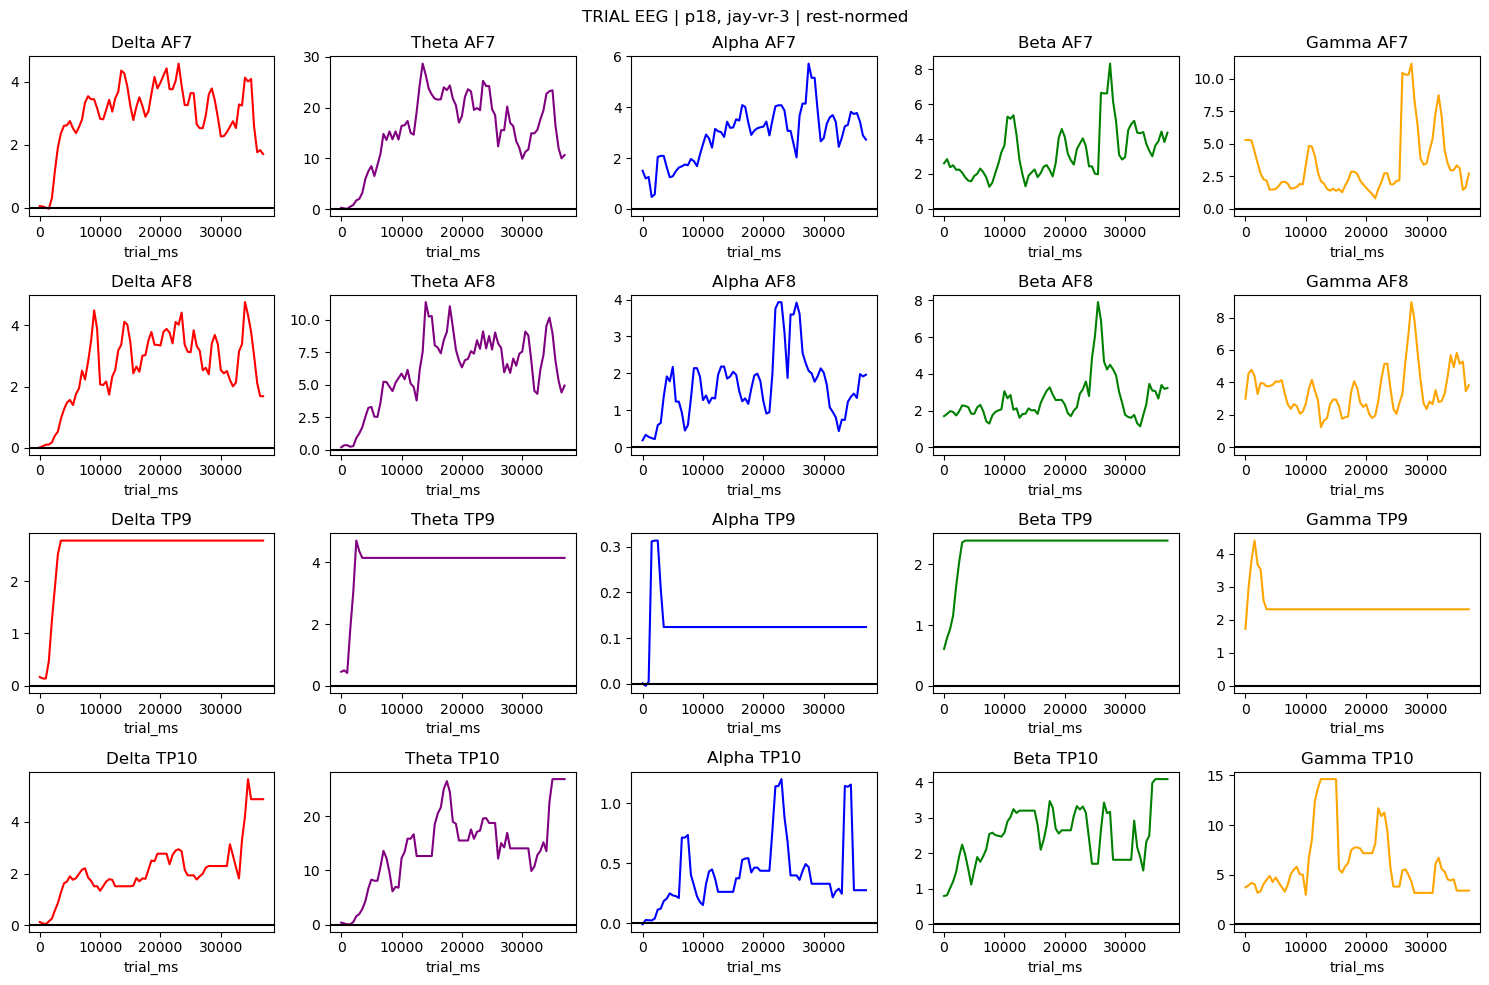

In [23]:
trial_id = 'jay-vr-3'
trial_filename = 'rest-normed'
#trial_filename = 'conc-normed'
#trial_filename = 'trial-normed'

trial_dir = os.path.join(_ALIGNED_DIR, participant_id, trial_id)

frequency_bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
frequency_colors = ['red', 'purple', 'blue', 'green', 'orange']
electrode_channels = ['AF7', 'AF8', 'TP9', 'TP10']

fig, ax = plt.subplots(nrows=4, ncols=5)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle(f"TRIAL EEG | {participant_id}, {trial_id} | {trial_filename}")
participant_trial_eegs = all_trial_eegs[(all_trial_eegs['participant'] == participant_id) & (all_trial_eegs['trial'] == trial_id)]

for i in range(len(frequency_bands)):
    color = frequency_colors[i]
    for j in range(len(electrode_channels)):
        colname = f"{frequency_bands[i]}_{electrode_channels[j]}_{trial_filename}"
        title = f"{frequency_bands[i]} {electrode_channels[j]}"
        this_trial_ax = participant_trial_eegs.plot.line(x='trial_ms',y=colname, ax=ax[j,i], color=color, title=title)
        this_trial_ax.legend_ = None
        # ... let's try to calculate the median of this range
        this_trial_median = participant_trial_eegs[colname].median()
        this_trial_std = participant_trial_eegs[colname].std()
        this_trial_ax.axhline(y=0, color='black', linestyle='-')
        #this_trial_ax.axhline(y=this_trial_median, color='black', linestyle='-')
        #this_trial_ax.axhline(y=this_trial_median+this_trial_std*0.5, color='black', linestyle='--')
        #this_trial_ax.axhline(y=this_trial_median-this_trial_std*0.5, color='black', linestyle='--')

plt.tight_layout()
plt_savename = os.path.join(trial_dir, f'eeg_{trial_filename}.png')
plt.savefig(plt_savename, bbox_inches="tight", pad_inches=0.1,)
plt.show()

One thing that has become abundantly clear is that some trials have only one side available, while others will have just... large gaps. This is not good. There are several ways we can tackle this.

* Only use participants who have both AF7 and AF8, have no gaps (reduces our population size by a lot)
* Only use participants who have both AF7 and AF8, but remove gaps to at least salvage some responses in incomplete EEG.

The latter option might be more prudent. Let's do that. But we'll need a way to identify these "gaps" and then properly remove them from consideration. It might just be easier to, during the window sliding process, remove windows that contain stretches of EEG data that are static for at least three consecutive timestamps.

Visual analysis and filtering highlights trials that only these trials can be used. Bolded are those who have both AF7 and AF8 at least provided without any significant EEG gaps; crossed-out ones are those we have to reject.

* __P1:__ 2 trials, 1 usable
    * ~~1~~
    * __2 (AF7, AF8)__
* __P2:__ 2 trials, 2 usable (4 total, 3 usable)
    * __1 (AF7, AF8)__
    * __4 (AF7, AF8)__
* __P3:__ 3 trials, 0 usable (7 total, 3 usable)
    * ~~1~~
    * ~~2~~
    * 3 (AF8)
* __P4:__ 2 trials, 0 usable (9 total, 3 usable)
    * 4 (AF8)
    * 5 (AF8)
* __P5:__ 2 trials, 0 usable (11 total, 3 usable)
    * 1 (AF8), 
    * 2 (AF8, TP10)
* __P6:__ 2 trials, 2 usable (13 total, 5 usable)
    * __1 (AF7, AF8)__
    * __2 (AF7, AF8)__
* __P7:__ 2 trials, 2 usable (15 total, 7 usable)
    * __1 (AF7, AF8)__
    * __2 (AF7, AF8)__
* __P8:__ 3 trials, 1 usable (18 total, 8 usable)
    * ~~1~~
    * ~~2~~
    * __3 (All)__
* __P9:__ 2 trials, 2 usable (20 total, 10 usable)
    * __1 (AF7, AF8)__
    * __2 (AF7, AF8)__
* __P10:__ 3 trials, 1 usable (23 total, 11 usable)
    * ~~1~~
    * ~~2~~
    * __3 (All)__
* __P11:__ 3 trials, 3 usable (26 total, 14 usable)
    * __1 (AF7, AF8)__
    * __2 (AF7, AF8)__
    * __3 (AF7, AF8)__
* __P12:__ 3 trials, 2 usable (29 total, 16 usable)
    * ~~1~~
    * __2 (AF7, AF8)__
    * __3 (AF7, AF8)__
* __P13:__ 3 trials, 0 usable (32 total, 16 usable)
    * ~~1~~
    * ~~2~~
    * ~~3~~
* __P14:__ 3 trials, 3 usable (35 total, 19 usable)
    * __1 (AF7, AF8)__
    * __2 (AF7, AF8)__
    * __3 (AF7, AF8)__
* __P15:__ 5 trials, 2 usable (40 total, 21 usable)
    * 1 (AF8)
    * __2 (AF7, AF8)__
    * __3 (AF7, AF8)__
    * 4 (AF8)
    * 5 (AF8)
* __P16:__ 4 trials, 4 usable (44 total, 25 usable)
    * __1 (All)__
    * __2 (All)__
    * __3 (All)__
    * __4 (All)__
* __P17:__ 3 trials, 3 usable (47 total, 28 usable)
    * __1 (AF7, AF8)__
    * __2 (AF7, AF8)__
    * __3 (AF7, AF8)__
* __P18:__ 3 trials, 3 usable (50 total, 31 usable)
    * __1 (AF7, AF8, TP10)__
    * __2 (AF7, AF8, TP10)__
    * __3 (AF7, AF8, TP10)__

There are 50 trials conducted in this experiment with only 31 usable. This mean we have a trial retention rate of (31/50 ~ 0.62) = 62%. That's... not bad, but not good. But even among the accepted trials, we are highly encouraged to isolate our analysis to the AF7 and AF8 channels due to the lack of sufficient TP9 and TP10 trials.

In [24]:
# Remove all TP channels
trial_eegs = all_trial_eegs.loc[:,~all_trial_eegs.columns.str.contains('TP', case=False)]

# Drop extraneous columns
extraneous_columns = [
    'AUX_LEFT',
    'Accelerometer_X','Accelerometer_Y','Accelerometer_Z',
    'Gyro_X','Gyro_Y','Gyro_Z',
    'HeadBandOn','Battery','Elements',
    'HSI_AF7','HSI_AF8']
trial_eegs.drop(columns=extraneous_columns, inplace=True)

# Drop the rejected trials. Rejected trials:
# Participant 1 - trial 1
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p1')&(trial_eegs['trial']=='jay-vr-1'))]
# Participant 3 - all trials
trial_eegs = trial_eegs[~(trial_eegs['participant']=='p3')]
# Participant 4 - all trials
trial_eegs = trial_eegs[~(trial_eegs['participant']=='p4')]
# Participant 5 - all trials
trial_eegs = trial_eegs[~(trial_eegs['participant']=='p5')]
# Participant 8: Trials 1 and 2
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p8')&(trial_eegs['trial'].isin(['jay-vr-1','jay-vr-2'])))]
# Participant 10: Trials 1 and 2
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p10')&(trial_eegs['trial'].isin(['jay-vr-1','jay-vr-2'])))]
# Participant 12: Trial 1
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p12')&(trial_eegs['trial']=='jay-vr-1'))]
# Participant 13: All trials
trial_eegs = trial_eegs[~(trial_eegs['participant']=='p13')]
# Particiapnt 15: Trials 1, 4, and 5
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p15')&(trial_eegs['trial'].isin(['jay-vr-1', 'jay-vr-4','jay-vr-5'])))]

display(trial_eegs)

,AUX_RIGHT,unix_ms,Delta_AF7,Delta_AF8,Theta_AF7,Theta_AF8,Alpha_AF7,Alpha_AF8,Beta_AF7,Beta_AF8,...,Delta_AF7_rest-normed,Delta_AF8_rest-normed,Theta_AF7_rest-normed,Theta_AF8_rest-normed,Alpha_AF7_rest-normed,Alpha_AF8_rest-normed,Beta_AF7_rest-normed,Beta_AF8_rest-normed,Gamma_AF7_rest-normed,Gamma_AF8_rest-normed
17,197.435897,1728510163757,1.403367,0.946320,0.900888,0.672448,0.542691,1.437818,1.872634,1.850978,...,0.014181,-0.043182,0.013543,-0.050578,-0.427480,-0.005469,0.193059,-0.012377,0.174079,-0.022285
21,1480.366300,1728510164749,1.403367,0.946320,0.900888,0.672448,0.542691,1.437818,1.872634,1.850978,...,0.014181,-0.043182,0.013543,-0.050578,-0.427480,-0.005469,0.193059,-0.012377,0.174079,-0.022285
26,1230.549451,1728510165756,1.403367,0.946320,0.900888,0.672448,0.542691,1.437818,1.872634,1.850978,...,0.014181,-0.043182,0.013543,-0.050578,-0.427480,-0.005469,0.193059,-0.012377,0.174079,-0.022285
28,0.000000,1728510166749,1.403367,0.946320,0.900888,0.672448,0.542691,1.437818,1.872634,1.850978,...,0.014181,-0.043182,0.013543,-0.050578,-0.427480,-0.005469,0.193059,-0.012377,0.174079,-0.022285
31,47.545788,1728510167749,4.883086,2.965768,0.733157,1.517067,2.008801,2.650079,2.265614,1.237237,...,0.289755,0.057039,-0.004421,0.085269,-0.148542,0.151593,0.290305,-0.127950,0.536688,-0.075525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1031.904762,1732121360264,7.619609,2.654722,2.773003,1.500816,2.224910,4.745045,5.009320,9.015475,...,0.923912,0.132658,0.700512,0.155002,0.299115,0.467096,3.264640,8.995196,6.617441,9.632114
108,550.402930,1732121361255,5.548473,2.844038,2.493321,2.674774,2.290712,4.515275,4.809471,5.116997,...,0.608593,0.150113,0.594121,0.453062,0.318306,0.432513,3.102270,4.567851,5.937639,6.757772
111,224.432234,1732121362255,4.817600,4.025871,0.812519,2.086194,0.794747,5.171027,3.100085,5.465087,...,0.497322,0.259079,-0.045254,0.303625,-0.118003,0.531210,1.713458,4.963163,3.350517,5.224088
113,703.113553,1732121363255,4.817600,4.158121,0.812519,1.866542,0.794747,4.339788,3.100085,6.050771,...,0.497322,0.271272,-0.045254,0.247857,-0.118003,0.406100,1.713458,5.628301,3.350517,2.847803


In [28]:
unique_participants = trial_eegs['participant'].unique().tolist()
participant_stats(participants_df[participants_df['participant'].isin(unique_participants)])

### Sex Statistics:

sex
Male      9
Female    5
Name: count, dtype: int64


### VR Statistics:

vr_experience
Yes    10
No      4
Name: count, dtype: int64 

vr_frequency
I had at least one experience in VR (ex. one-off situations)    5
I use VR sparingly or irregularly (ex. few times a year)        4
I use VR occasionally (ex. a few times a month)                 1
Name: count, dtype: int64 

vr_sickness
I never experienced simulator sickness in VR                            7
Depending on the virtual content, I sometimes get simulator sickness    3
Name: count, dtype: int64


### Age Statistics:

age
25    4
23    4
24    3
41    1
32    1
18    1
Name: count, dtype: int64 

Age Mean: 25.357142857142858
Age Median: 24.0
Age SD: 5.343682724015812


### Vision Statistics:

corrective_vision
Yes, I have corrective vision         9
No, I do not have corrected vision    5
Name: count, dtype: int64 

vision_condition
I had Myopia and Astigmatism, but I had a corrective surgery - SMILE.    1
My glasses correct for some small amount of astigmatism.                 1
Name: count, dtype: int64


### Neural Statistics:

neural_diagnosis
No     13
Yes     1
Name: count, dtype: int64 

neural_condition
ADHD    1
Name: count, dtype: int64


### Participant Data:

,participant,sex,vr_experience,vr_frequency,vr_sickness,corrective_vision,vision_diagnosis,vision_condition,neural_diagnosis,neural_condition,age
0,p1,Female,No,None,None,"Yes, I have corrective vision",No,None,No,None,25
1,p10,Female,Yes,I use VR sparingly or irregularly (ex. few tim...,"Depending on the virtual content, I sometimes ...","No, I do not have corrected vision",No,None,No,None,23
2,p11,Male,No,None,None,"Yes, I have corrective vision",Yes,"I had Myopia and Astigmatism, but I had a corr...",No,None,25
3,p12,Female,Yes,I had at least one experience in VR (ex. one-o...,I never experienced simulator sickness in VR,"No, I do not have corrected vision",No,None,No,None,41
4,p14,Male,Yes,I use VR occasionally (ex. a few times a month),I never experienced simulator sickness in VR,"No, I do not have corrected vision",No,None,No,None,23
5,p15,Male,Yes,I had at least one experience in VR (ex. one-o...,I never experienced simulator sickness in VR,"Yes, I have corrective vision",No,None,No,None,25
6,p16,Male,Yes,I had at least one experience in VR (ex. one-o...,I never experienced simulator sickness in VR,"Yes, I have corrective vision",No,None,No,None,25
7,p17,Male,Yes,I use VR sparingly or irregularly (ex. few tim...,"Depending on the virtual content, I sometimes ...","Yes, I have corrective vision",No,None,No,None,23
8,p18,Male,No,None,None,"Yes, I have corrective vision",Yes,My glasses correct for some small amount of as...,No,None,32
9,p2,Male,Yes,I had at least one experience in VR (ex. one-o...,I never experienced simulator sickness in VR,"Yes, I have corrective vision",No,None,No,None,24


## Analyzing VR Data

We want to look at these qualities regarding the following assumed features:

|Feature|Description|Representation|
|:-|:-|:-|
|Dist. from pedestrians|Min. distance from closest pedestrian|`float`|
|Crowd flow alignment|Participant's current velocity w.r.t. other pedestrians|`float`|
|Desired vel. alignment|Participant's current velocity w.r.t. the left direction|`float`|
|Spatial Distribution|The relative positions of nearby pedestrians with respect to the participant's current position|`heatmap`|

### Distance from Pedestrians

This one's a fairly obvious one. We want to find correlations between EEG changes and the presence of other pedestrians. The simplest way is to measure how far away people were from the participant. There are some issues though - namely, how we represent this distance within a window of time instead of a specific timestamp. For example, let's say that within a 2-sec window, we have a participant approaching the participant. Would the distance between pedestrians thus be, for each frame within that window, the distance, then we combine them together? Or is it the closest possible distance across all frames? Or is it a delta in the distance to the participant across time? What about if one pedestrian is moving away while another is moving toward the participant?

I think the best way we can represent this is the summation of the distances between the participant and __closest__ pedestrian across the 2-sec window. Kind of like, if we represented the distance to the participant for each agent as a time-series graph, it would be like calculating the area under the composite curve that represents the distance of pedestrians from the participant.

![Distance Time Series](./docs/IMG_5572.jpg 'Distance Time Series')

Of course, this would beg the question - just because we see certain values in the interpersonal distance doesn't necessarily mean that we're seeing a correlation with the change in the EEG values. It would be more prudent to measure the change in interpersonal distance across time. Therefore, the change in EEG would be correlated with the change in interpersonal distance across the same window of time.

### Crowd Flow Alignment

This one is a bit of an interesting one. We want to measure how similar people were moving around the player within the hamming window. This means we want to be able to represent crowd flow in some way. The best way perhaps is to measure the crowd flow around the participant within the window. We then measure the difference between the player's velocity and the velocity flow field at each timestamp in the time window, weighing based on proximity to either the beginning or end (depending on if we want to use prediction or detection as our metric).

Similar to the interpersonal distance metric, we can want to find a correlation with a CHANGE in EEG value. So this metric would have to be a change in alignment with the current crowd flow. This means, across time, we need to measure how "aligned" the pedestrian is with their surrounding pedestrians.

### Desired Velocity Alignment

Some theorize that if participants are forced to change their current velocity and divert from their desired one, then this may create mental friction. Similar to the crowd flow alignment model, it might be best to subtract the desired velocity from the current velocity per frame, weighted by proximity to either ending or beginning.

![Desired Velocity Alignment](./docs/IMG_5574.jpg 'Desired Velocity Alignment')

Similar to the interpersonal distance and crowd flow alignment, we need to find correlations with the change in EEG. This would correspond to a change in desired velocity alignment.

### Spatial Distribution

This one is... an interesting idea. The idea is that we can produce heatmaps based on the distribution of pedestrians over time. The heatmap idea allows us to encapsulate a ton of the same ideas into a single format:

* Heatmaps can represent the distribution of pedestrians across time, which encapsulates distance and velocity.
* Heatmaps can also represent the distribution of incoming obstacles relative to the participant.

The difficulty comes from the issue that heatmaps can represent many features all at once. For example, if we identify that a change in the heatmap correlates with a specific heatmap distribution, then is that because of the distance between the participant and other pedestrians? Or is that because some incoming pedestrians were cutting across the participant's path? Or is the flow of fellow pedestrians due to the participant's movement themselves? It becomes tricky to identify the features that cause the correlation, and heatmaps don't give us a strong idea of what's happening in each scene despite their visually interesting... visualization.

### Extra Considerations

The notes above already talked a little about consideration for changes in EEG. That's fine. However, consider that in a 2-sec window, there will be 4 EEG points (they're discretized by 0.5 seconds). If we translate by 0.5 seconds every time, then the same increase in EEG can be replicated in 4 consecutive windows. This can create a bias in the data, because the same change is looked at 4 times in our data. How do we avoid this?

Given that we're only interested in changes, we may want to use time sliding of 2 seconds. So instead of sliding by 0.5 seconds, we just slide by 2 seconds. This would prevent overlap and thus prevent over-correlation. There are other probable methods to handle this - I'll have to refer to the literature.

For the moment, let's use the rest-normalized data just to make sure that we at least capture the resting base state of each EEG band.

## Local Spatiality - Pedestrian Counts within Radius, Interpersonal Distance

In [157]:
trial_eegs[trial_eegs['participant']=='p1']

,unix_ms,Delta_AF7,Delta_AF8,Theta_AF7,Theta_AF8,Alpha_AF7,Alpha_AF8,Beta_AF7,Beta_AF8,Gamma_AF7,...,Delta_AF7_rest-normed,Delta_AF8_rest-normed,Theta_AF7_rest-normed,Theta_AF8_rest-normed,Alpha_AF7_rest-normed,Alpha_AF8_rest-normed,Beta_AF7_rest-normed,Beta_AF8_rest-normed,Gamma_AF7_rest-normed,Gamma_AF8_rest-normed
17,1728510163757,1.403367,0.946320,0.900888,0.672448,0.542691,1.437818,1.872634,1.850978,0.933668,...,0.014181,-0.043182,0.013543,-0.050578,-0.427480,-0.005469,0.193059,-0.012377,0.174079,-0.022285
21,1728510164749,1.403367,0.946320,0.900888,0.672448,0.542691,1.437818,1.872634,1.850978,0.933668,...,0.014181,-0.043182,0.013543,-0.050578,-0.427480,-0.005469,0.193059,-0.012377,0.174079,-0.022285
26,1728510165756,1.403367,0.946320,0.900888,0.672448,0.542691,1.437818,1.872634,1.850978,0.933668,...,0.014181,-0.043182,0.013543,-0.050578,-0.427480,-0.005469,0.193059,-0.012377,0.174079,-0.022285
28,1728510166749,1.403367,0.946320,0.900888,0.672448,0.542691,1.437818,1.872634,1.850978,0.933668,...,0.014181,-0.043182,0.013543,-0.050578,-0.427480,-0.005469,0.193059,-0.012377,0.174079,-0.022285
31,1728510167749,4.883086,2.965768,0.733157,1.517067,2.008801,2.650079,2.265614,1.237237,1.798177,...,0.289755,0.057039,-0.004421,0.085269,-0.148542,0.151593,0.290305,-0.127950,0.536688,-0.075525
34,1728510168749,6.879903,2.964922,0.993169,1.536872,1.859432,2.276023,2.284969,1.312381,2.085847,...,0.447891,0.056997,0.023427,0.088454,-0.176961,0.103130,0.295095,-0.113799,0.657348,-0.067160
37,1728510169749,6.082985,2.964922,5.620094,1.536872,4.889604,2.276023,4.146186,1.312381,1.763993,...,0.384780,0.056997,0.518984,0.088454,0.399550,0.103130,0.755668,-0.113799,0.522350,-0.067160
39,1728510170748,10.114005,2.964922,4.077030,1.536872,4.840654,2.276023,4.608288,1.312381,6.234104,...,0.704013,0.056997,0.353717,0.088454,0.390237,0.103130,0.870019,-0.113799,2.397290,-0.067160
42,1728510171749,10.114005,2.964922,4.077030,1.536872,4.840654,2.276023,4.608288,1.312381,6.234104,...,0.704013,0.056997,0.353717,0.088454,0.390237,0.103130,0.870019,-0.113799,2.397290,-0.067160
45,1728510172749,10.114005,2.964922,4.077030,1.536872,4.840654,2.276023,4.608288,1.312381,6.234104,...,0.704013,0.056997,0.353717,0.088454,0.390237,0.103130,0.870019,-0.113799,2.397290,-0.067160


In [73]:
# Let's take one participant and trial for example
participant_trial_eegs = trial_eegs[(all_trial_eegs['participant'] == participant_id) & (all_trial_eegs['trial'] == trial_id)]

display(participant_trial_eegs['trial_ms'])

# For each band-electrode combination, we need to identify when there are at least three consecutive equivalent values.
data = {
    'timestamp': pd.date_range(start='2025-03-01', periods=11, freq='H'),
    'value': ['A', 'B', 'B', 'B', 'C', 'C', 'C', 'D','A', 'A', 'A']
}
df = pd.DataFrame(data)

# Create a new column to mark consecutive rows with the same 'value'
df['group'] = (df['value'] != df['value'].shift()).cumsum()

# Now, filter out the groups that have at least 3 consecutive same values
result = df.groupby('group').filter(lambda group: len(group) >= 3 and group['value'].nunique() == 1)

display(df)
display(result)

25         0
27       505
28       999
29      1507
30      2000
       ...  
222    71497
223    71998
224    72505
226    72998
227    73498
Name: trial_ms, Length: 148, dtype: int64

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_2074/1053429771.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='2025-03-01', periods=11, freq='H'),


,timestamp,value,group
0,2025-03-01 00:00:00,A,1
1,2025-03-01 01:00:00,B,2
2,2025-03-01 02:00:00,B,2
3,2025-03-01 03:00:00,B,2
4,2025-03-01 04:00:00,C,3
5,2025-03-01 05:00:00,C,3
6,2025-03-01 06:00:00,C,3
7,2025-03-01 07:00:00,D,4
8,2025-03-01 08:00:00,A,5
9,2025-03-01 09:00:00,A,5


,timestamp,value,group
1,2025-03-01 01:00:00,B,2
2,2025-03-01 02:00:00,B,2
3,2025-03-01 03:00:00,B,2
4,2025-03-01 04:00:00,C,3
5,2025-03-01 05:00:00,C,3
6,2025-03-01 06:00:00,C,3
8,2025-03-01 08:00:00,A,5
9,2025-03-01 09:00:00,A,5
10,2025-03-01 10:00:00,A,5


There are 50 trials conducted in this experiment. This mean we have a trial retention rate of (39/50 ~ 0.78) = 78%. That's... not bad. But even among the accepted trials, we are highly encouraged to isolate our analysis to the AF7 and AF8 channels due to the lack of sufficient TP9 and TP10 trials.

In [67]:
# Remove all TP channels
trial_eegs = all_trial_eegs.loc[:,~all_trial_eegs.columns.str.contains('TP', case=False)]
# Drop extraneous columns
trial_eegs.drop(columns=['TimeStamp','RAW_AF7', 'RAW_AF8','AUX_RIGHT','AUX_LEFT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','HSI_AF7','HSI_AF8','Battery','Elements'], inplace=True)
# Rename the centered columns to their original name
trial_eegs.rename(columns={"Delta_AF8_Centered": "Delta_AF8", "Delta_AF7_Centered": "Delta_AF7", "Theta_AF7_Centered":"Theta_AF7","Theta_AF8_Centered":"Theta_AF8","Alpha_AF7_Centered":"Alpha_AF7","Alpha_AF8_Centered":"Alpha_AF8","Beta_AF7_Centered":"Beta_AF7","Beta_AF8_Centered":"Beta_AF8","Gamma_AF7_Centered":"Gamma_AF7","Gamma_AF8_Centered":"Gamma_AF8"}, inplace=True)

# Drop the rejected trials mentioned above
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p1')&(trial_eegs['trial']=='jay-vr-1'))]
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p3')&(trial_eegs['trial'].isin(['jay-vr-1','jay-vr-2'])))]
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p8')&(trial_eegs['trial'].isin(['jay-vr-1','jay-vr-2'])))]
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p10')&(trial_eegs['trial'].isin(['jay-vr-1','jay-vr-2'])))]
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p12')&(trial_eegs['trial']=='jay-vr-1'))]
trial_eegs = trial_eegs[~((trial_eegs['participant']=='p13')&(trial_eegs['trial'].isin(['jay-vr-1','jay-vr-2','jay-vr-3'])))]
# Delete the same rejected trials in our diciotnary of trial files
trial_files['p1'].pop('jay-vr-1', None)
trial_files['p3'].pop('jay-vr-1', None)
trial_files['p3'].pop('jay-vr-2', None)
trial_files['p8'].pop('jay-vr-1', None)
trial_files['p8'].pop('jay-vr-2', None)
trial_files['p10'].pop('jay-vr-1', None)
trial_files['p10'].pop('jay-vr-2', None)
trial_files['p12'].pop('jay-vr-1', None)
trial_files['p13'].pop('jay-vr-1', None)
trial_files['p13'].pop('jay-vr-2', None)
trial_files['p13'].pop('jay-vr-3', None)
# If a participant is now empty as a result of this, we remove the key from files
if 'p1' in trial_files and not trial_files['p1']: trial_files.pop('p1', None)
if 'p3' in trial_files and not trial_files['p3']: trial_files.pop('p3', None)
if 'p8' in trial_files and not trial_files['p8']: trial_files.pop('p8', None)
if 'p10' in trial_files and not trial_files['p10']: trial_files.pop('p10', None)
if 'p12' in trial_files and not trial_files['p12']: trial_files.pop('p12', None)
if 'p13' in trial_files and not trial_files['p13']: trial_files.pop('p13', None)
# Display results
for pdir in trial_files:
    print(pdir)
    for tdir in trial_files[pdir]:
        print("-", tdir)
        for f in trial_files[pdir][tdir]:
            print("---", f)
            
display(trial_eegs)

KeyError: "['TimeStamp', 'RAW_AF7', 'RAW_AF8', 'AUX_RIGHT'] not found in axis"

In [528]:
participant_id = 'p4'
trial_id = 'jay-vr-4'

user_filename = os.path.join(_PARTICIPANTS_DIR, participant_id, trial_id, 'user-aligned.csv')
user_df = pd.read_csv(user_filename)

# Calculating basics such as trial seconds, delta time, and speed.
user_grouped_df = user_df.groupby(['pos_x','pos_y','pos_z'],as_index=False).first().sort_values(by=['trial_milliseconds'])
user_grouped_df['trial_seconds'] = user_grouped_df['trial_milliseconds'] / 1000;
user_grouped_df['dt'] = user_grouped_df['trial_seconds'].diff().fillna(0)
user_grouped_df['speed'] = np.sqrt(user_grouped_df['velocity_x']**2 + user_grouped_df['velocity_z']**2)

# Calculating overall acceleration
user_grouped_df['accel'] = user_grouped_df['speed'].diff().fillna(0) / user_grouped_df['dt']
user_grouped_df['accel'].replace([np.inf, -np.inf], 0, inplace=True)
user_grouped_df['accel'].fillna(0, inplace=True)
user_grouped_df['accel^2'] = user_grouped_df['accel'].diff().fillna(0) / user_grouped_df['dt']
user_grouped_df['accel^2'].replace([np.inf, -np.inf], 0, inplace=True)
user_grouped_df['accel^2'].fillna(0, inplace=True)

# Calculating forward acceleration. In Unity space, -x = forward, +x = rightward
user_grouped_df['accel_x'] = user_grouped_df['velocity_x'].diff().fillna(0) / user_grouped_df['dt']
user_grouped_df['accel_x'].replace([np.inf, -np.inf], 0, inplace=True)
user_grouped_df['accel_x'].fillna(0, inplace=True)
user_grouped_df['accel_x^2'] = user_grouped_df['accel_x'].diff().fillna(0) / user_grouped_df['dt']
user_grouped_df['accel_x^2'].replace([np.inf, -np.inf], 0, inplace=True)
user_grouped_df['accel_x^2'].fillna(0, inplace=True)

# Calculating forward acceleration. In Unity Space, -z = leftward, +z = rightward
user_grouped_df['accel_z'] = user_grouped_df['velocity_z'].diff().fillna(0) / user_grouped_df['dt']
user_grouped_df['accel_z'].replace([np.inf, -np.inf], 0, inplace=True)
user_grouped_df['accel_z'].fillna(0, inplace=True)
user_grouped_df['accel_z^2'] = user_grouped_df['accel_z'].diff().fillna(0) / user_grouped_df['dt']
user_grouped_df['accel_z^2'].replace([np.inf, -np.inf], 0, inplace=True)
user_grouped_df['accel_z^2'].fillna(0, inplace=True)

# Standard deviation of acceleration and its derivative
accel_x_mean = user_grouped_df['accel_x'].mean()
accel_x_std = user_grouped_df['accel_x'].std()
accel_x2_mean = user_grouped_df['accel_x^2'].mean()
accel_x2_std = user_grouped_df['accel_x^2'].std()
accel_z_mean = user_grouped_df['accel_z'].mean()
accel_z_std = user_grouped_df['accel_z'].std()
accel_z2_mean = user_grouped_df['accel_z^2'].mean()
accel_z2_std = user_grouped_df['accel_z^2'].std()

# Re-index
user_grouped_df.reset_index(inplace=True)

print("\t", accel_x2_mean, accel_x2_std)
print("\t", accel_z2_mean, accel_z2_std)
user_grouped_df

	 -0.9808899567125696 343.2300368957657
	 0.002790088466960864 136.0203047361862


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\476151186.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_grouped_df['accel'].replace([np.inf, -np.inf], 0, inplace=True)
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\476151186.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

,index,pos_x,pos_y,pos_z,trial_milliseconds,id,rel_pos_x,rel_pos_y,rel_pos_z,forward_x,...,is_active,trial_seconds,dt,speed,accel,accel^2,accel_x,accel_x^2,accel_z,accel_z^2
0,1769,1.228353,0,0.067899,14,player,0,0,0,-0.988139,...,1,0.014,0.000,0.002716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1768,1.227369,0,0.067509,41,player,0,0,0,-0.988291,...,1,0.041,0.027,0.079417,2.840768,105.213641,-2.647440,-98.053316,-1.033147,-38.264711
2,1767,1.226159,0,0.067058,68,player,0,0,0,-0.988412,...,1,0.068,0.027,0.096828,0.644883,-81.329096,-0.626180,74.861464,-0.168217,32.034436
3,1766,1.224829,0,0.066477,95,player,0,0,0,-0.988521,...,1,0.095,0.027,0.108870,0.445975,-7.366961,-0.334117,10.817147,-0.362926,-7.211440
4,1765,1.223445,0,0.065890,123,player,0,0,0,-0.988509,...,1,0.123,0.028,0.112751,0.138627,-10.976689,-0.144329,6.778147,-0.015327,12.414268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,158,-40.197540,0,-0.633289,50672,player,0,0,0,-0.971801,...,1,50.672,0.029,0.015367,-0.073191,-12.574118,0.641264,30.460354,0.365027,30.800559
1766,161,-40.197320,0,-0.633350,50702,player,0,0,0,-0.973441,...,1,50.702,0.030,0.017490,0.070752,4.798092,0.095368,-18.196534,0.057220,-10.260227
1767,164,-40.197070,0,-0.633278,50729,player,0,0,0,-0.975167,...,1,50.729,0.027,0.019100,0.059655,-0.410981,0.052982,-1.569845,0.370873,11.616775
1768,167,-40.196740,0,-0.633533,50757,player,0,0,0,-0.976603,...,1,50.757,0.028,0.031190,0.431785,13.290365,0.224795,6.136171,-0.878743,-44.629143


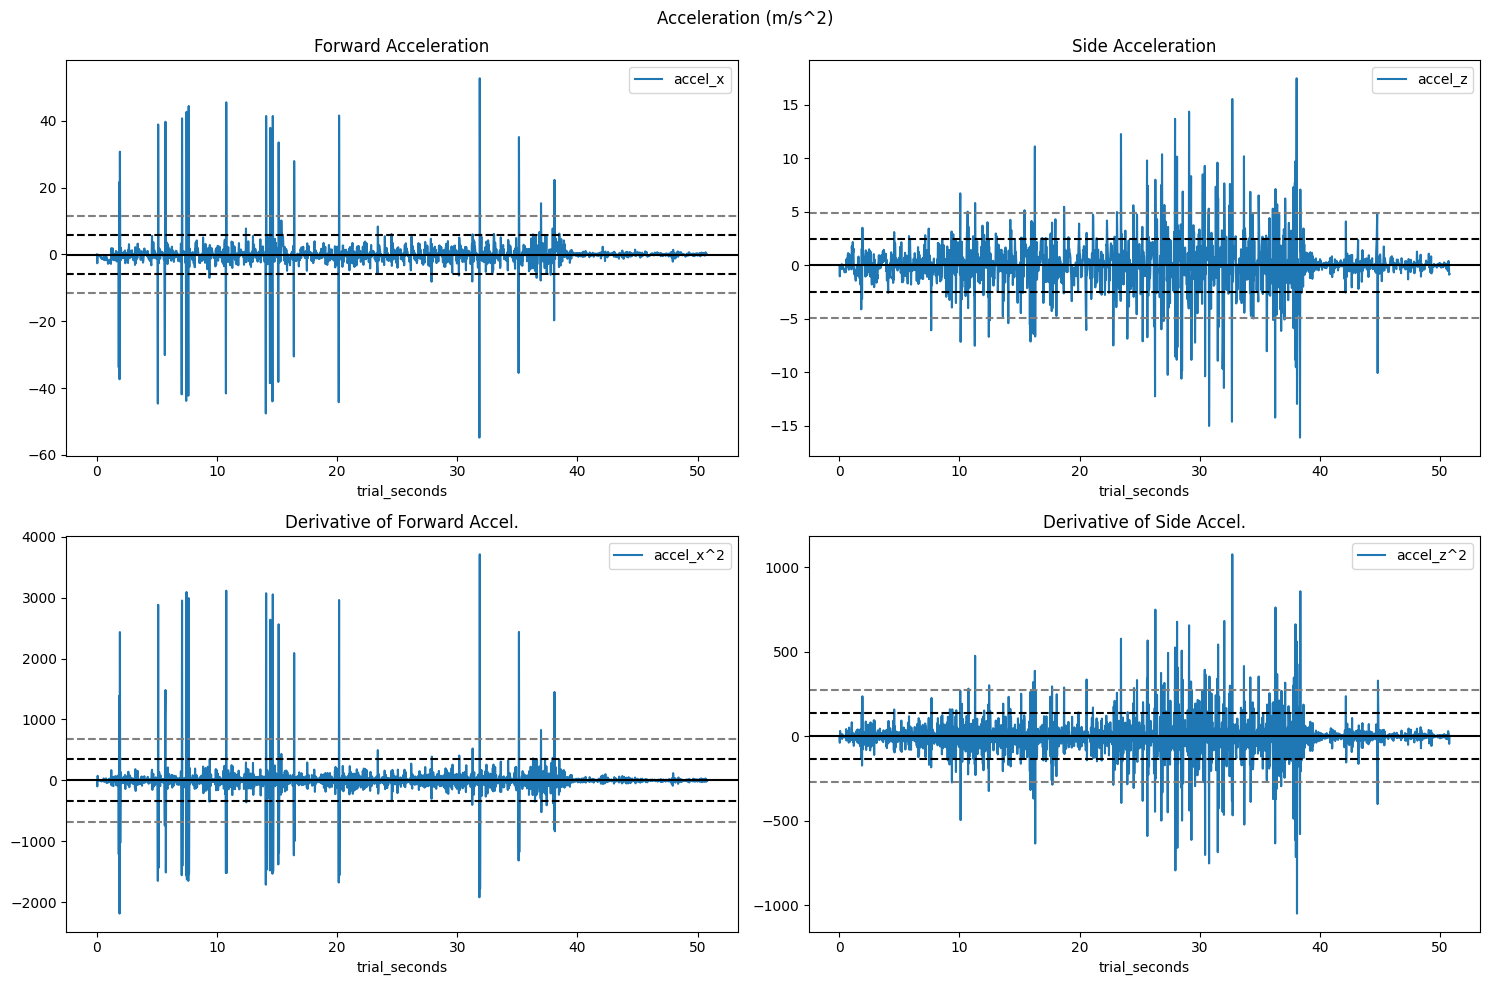

In [529]:
fig, ax = plt.subplots(2,2) # 4 rows, 2 cols
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Acceleration (m/s^2)')

# Forward-Backward Acceleration - along X-axis
user_grouped_df.plot.line(x='trial_seconds', y='accel_x', ax=ax[0,0], title="Forward Acceleration")
ax[0,0].axhline(y=accel_x_mean, color='black', linestyle='-')
ax[0,0].axhline(y=accel_x_std, color='black', linestyle='--') 
ax[0,0].axhline(y=accel_x_std*2, color='gray', linestyle='--') 
ax[0,0].axhline(y=-accel_x_std, color='black', linestyle='--') 
ax[0,0].axhline(y=-accel_x_std*2, color='gray', linestyle='--') 
user_grouped_df.plot.line(x='trial_seconds', y='accel_x^2', ax=ax[1,0], title="Derivative of Forward Accel.")
ax[1,0].axhline(y=accel_x2_mean, color='black', linestyle='-')
ax[1,0].axhline(y=accel_x2_std, color='black', linestyle='--') 
ax[1,0].axhline(y=accel_x2_std*2, color='gray', linestyle='--') 
ax[1,0].axhline(y=-accel_x2_std, color='black', linestyle='--') 
ax[1,0].axhline(y=-accel_x2_std*2, color='gray', linestyle='--') 

# Side-to-Side Acceleration - along Z-axis
user_grouped_df.plot.line(x='trial_seconds', y='accel_z', ax=ax[0,1], title="Side Acceleration")
ax[0,1].axhline(y=accel_z_mean, color='black', linestyle='-')
ax[0,1].axhline(y=accel_z_std, color='black', linestyle='--') 
ax[0,1].axhline(y=accel_z_std*2, color='gray', linestyle='--') 
ax[0,1].axhline(y=-accel_z_std, color='black', linestyle='--') 
ax[0,1].axhline(y=-accel_z_std*2, color='gray', linestyle='--') 
user_grouped_df.plot.line(x='trial_seconds', y='accel_z^2', ax=ax[1,1], title="Derivative of Side Accel.")
ax[1,1].axhline(y=accel_z2_mean, color='black', linestyle='-')
ax[1,1].axhline(y=accel_z2_std, color='black', linestyle='--') 
ax[1,1].axhline(y=accel_z2_std*2, color='gray', linestyle='--') 
ax[1,1].axhline(y=-accel_z2_std, color='black', linestyle='--') 
ax[1,1].axhline(y=-accel_z2_std*2, color='gray', linestyle='--') 

plt.tight_layout()
plt.show()

## Events - EEG + Acceleration

The idea is this. We look at both EEG and Acceleration thresholds. We look at EEG in direct to potential events that have caused EEG spikes. We look at Acceleration to identify shifts in movement that may not be captured in the EEG easily, perhaps.

### EEG Events

EEG events are henceforth defined by fluctations in the alpha, beta, and gamma bands that exceed 0.5SD of the distribution of EEG data during the trial. We use the median instead of the mean to prevent outliers from affecting the threshold too much. There's no point in applying a normalizing agent here - the distribution is the same regardless, we just change the y-scale. The re-centering can be used to make the thresholding calculation easier.

The idea is that EEG events are identified in trials when the EEG PSD power exceeds the 0.5SD around the mean of the EEG sample data. This requires a mean and SD calculation, re-centering the data along the mean, then identifying timestamps based on moments when the EEG power will fluctuate out of the 0.5SD range

In [615]:
_FREQUENCY_BANDS = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
_FREQUENCY_COLORS = ['red', 'purple', 'blue', 'green', 'orange']
_ELECTRODE_CHANNELS = ['AF7', 'AF8'] #TP9, TP10

def get_trial_eeg(
        src:str, 
        start_unix_milliseconds:int,
        end_buffer_milliseconds:int = 5000,
        frequency_bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'],
        electrode_channels = ['AF7', 'AF8', 'TP9', 'TP10']
):
    df = pd.read_csv(src)            # Read csv file into Dataframe
    df = df[~df['TimeStamp'].isna()] # Remove rows where timestamp is na
    df = df[~df['Battery'].isna()]   # Remove battery rows - useless
    
    # TimeStamp => Unix Milliseconds
    df['unix_ms'] = df['TimeStamp'].apply(lambda x: int(timestamp_to_unix_milliseconds(x)))
    
    # Unix Milliseconds => Relative Unix Milliseconds since the first row
    raw_start_unix_milliseconds = df['unix_ms'].iloc[0]
    df['rel_unix_ms'] = df['unix_ms'] - raw_start_unix_milliseconds
    
    # Filter rows before the provided start unix and 5 seconds from the last row timestamp.
    # Assume that the provided start timestamp already takes into account the intitial 5-sec removal.
    end_unix_milliseconds = df['unix_ms'].iloc[-1] - end_buffer_milliseconds
    df = df[df['unix_ms'].between(start_unix_milliseconds, end_unix_milliseconds)]
    
    # Relative Unix Milliseconds => Trial Milliseconds
    df['trial_ms'] = df['rel_unix_ms'] - df['rel_unix_ms'].iloc[0]
    
    # Log Power => Power
    # Re-center to median
    for band in frequency_bands:
        for channel in electrode_channels:
            in_colname = f"{band}_{channel}"
            pow_colname = f"{in_colname}_Power"
            recenter_colname = f'{pow_colname}_Recenter'
            
            # Convert from log power to power
            df[pow_colname] = 10 ** df[in_colname]
            
            # Recenter to median
            df[recenter_colname] = df[pow_colname] - df[pow_colname].median()
            
    # Drop TP and unrelated columns
    fdf = df.loc[:,~df.columns.str.contains('TP', case=False)]
    fdf = fdf.loc[:,~fdf.columns.str.contains('Delta', case=False)]
    fdf = fdf.loc[:,~fdf.columns.str.contains('Theta', case=False)]
    fdf.drop(columns=['TimeStamp','RAW_AF7', 'RAW_AF8','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','HSI_AF7','HSI_AF8','Battery','Elements'], inplace=True)
    
    # Return dataframe
    return fdf

### Acceleration Events

Similarly, we want to use the acceleration data to measure the events based on velocity changes. We do so by measuring the acceleration of the participant's movement, re-centering along the median, then identifying moments when the acceleration proceeded 1SD. This is different from the 0.5SD of the EEG due to the fluctuation in velocity and acceleration due to the natural gait of participants while naturalistically walking.

In [686]:
def get_user_aligned(src:str):
    # Read the CSV file
    df = pd.read_csv(src)
    
    # Remove y vals, rename some columns
    df.drop(columns=['pos_y', 'rel_pos_y', 'forward_y', 'rel_forward_y','velocity_y','rel_velocity_y'], inplace=True)
    df.rename(columns={
        'pos_z':'pos_y',
        'rel_pos_z':'rel_pos_y',
        'forward_z':'forward_y',
        'rel_forward_z':'rel_forward_y',
        'velocity_z':'velocity_y',
        'rel_velocity_z':'rel_velocity_y',
        'trial_milliseconds': 'trial_ms'}, inplace=True)
    
    # Calculating basics such as trial seconds, delta time, and speed.
    gdf = df.groupby(['pos_x','pos_y'],as_index=False).first().sort_values(by=['trial_ms'])
    gdf['trial_seconds'] = gdf['trial_ms'] / 1000
    gdf['dt'] = gdf['trial_seconds'].diff().fillna(0)
    gdf['speed'] = np.sqrt(gdf['velocity_x']**2 + gdf['velocity_y']**2)
    
    # Calculating Acceleration. In Unity
    gdf['accel'] = gdf['speed'].diff().fillna(0) / gdf['dt']
    gdf['accel'].replace([np.inf, -np.inf], 0, inplace=True)
    gdf['accel'].fillna(0, inplace=True)
    
    # Calculating forward acceleration. In Unity space, -x = forward, +x = rightward
    gdf['accel_x'] = gdf['velocity_x'].diff().fillna(0) / gdf['dt']
    gdf['accel_x'].replace([np.inf, -np.inf], 0, inplace=True)
    gdf['accel_x'].fillna(0, inplace=True)
    
    # Calculating sideways acceleration. In Unity Space, -z = leftward, +z = rightward
    gdf['accel_y'] = gdf['velocity_y'].diff().fillna(0) / gdf['dt']
    gdf['accel_y'].replace([np.inf, -np.inf], 0, inplace=True)
    gdf['accel_y'].fillna(0, inplace=True)
    
    # Re-center accel_x and accel_z around their medians
    gdf['accel_centered'] = gdf['accel'] - gdf['accel'].median()
    gdf['accel_x_centered'] = gdf['accel_x'] - gdf['accel_x'].median()
    gdf['accel_y_centered'] = gdf['accel_y'] - gdf['accel_y'].median()
    
    # Return the dataframe
    gdf.reset_index(inplace=True)
    return gdf

def get_pedestrians_aligned(src:str):
    df = pd.read_csv(src)
    
    # Remove y vals, rename some columns
    df.drop(columns=['pos_y', 'rel_pos_y', 'forward_y', 'rel_forward_y','velocity_y','rel_velocity_y'], inplace=True)
    df.rename(columns={
        'pos_z':'pos_y',
        'rel_pos_z':'rel_pos_y',
        'forward_z':'forward_y',
        'rel_forward_z':'rel_forward_y',
        'velocity_z':'velocity_y',
        'rel_velocity_z':'rel_velocity_y',
        'trial_milliseconds': 'trial_ms'}, inplace=True)
    
    # Check if a pedestrian is visible within 110 degrees along the horizon, or 55 degrees on either side
    df['in_fustrum'] = abs(df['angle_from_participant']) <= 55
    
    return df

### Combining it all

In [687]:
def get_trial_data(pid, tid):
    # the trial directory
    tdir = os.path.join(_PARTICIPANTS_DIR, pid, tid)
        
    # Get trial start from trial.csv
    trial_df = pd.read_csv(os.path.join(tdir, 'trial.csv'))
    start_unix_ms = trial_df.iloc[-1]['unix_ms']
        
    # Get the EEG data
    eeg_df = get_trial_eeg(os.path.join(tdir,'raw_eeg.csv'), start_unix_ms)
            
    # Get the user-aligned data
    user_aligned_df = get_user_aligned(os.path.join(tdir, 'user-aligned.csv'))
        
    # Get pedestrian-aligned data
    ped_aligned_df = get_pedestrians_aligned(os.path.join(tdir, 'pedestrians-aligned.csv'))
        
    return tdir, trial_df, eeg_df, user_aligned_df, ped_aligned_df

In [688]:
# Test with P1-JAY-VR-2
test_dir, test_trial_df, test_eeg_df, test_user_df, test_ped_df = get_trial_data('p1','jay-vr-2')
display(test_trial_df)
display(test_eeg_df)
display(test_user_df)
display(test_ped_df)

test_events = []

for frequency in _FREQUENCY_BANDS:
    if frequency in ['Delta','Theta']: continue
    for electrode in _ELECTRODE_CHANNELS:
        test_eeg_colname = f"{frequency}_{electrode}_Power_Recenter"
        test_colname_sd = test_eeg_df[test_eeg_colname].std()
        test_colname_event_rows = test_eeg_df[abs(test_eeg_df[test_eeg_colname]) >= 0.5*test_colname_sd]
        # get only the core columns necessary
        test_colname_events = test_colname_event_rows[['trial_ms']]
        test_colname_events['trial_seconds'] = test_colname_events['trial_ms']/1000
        test_colname_events['source'] = f'{frequency}_{electrode}'
        test_events.append(test_colname_events)

"""
test_accel_sd = test_user_df['accel_centered'].std()
test_accelX_sd = test_user_df['accel_x_centered'].std()
test_accelZ_sd = test_user_df['accel_z_centered'].std()
test_accel_events_rows = test_user_df[abs(test_user_df['accel_centered']) >= test_accel_sd]
test_accelX_events_rows = test_user_df[abs(test_user_df['accel_x_centered']) >= test_accelX_sd]
test_accelZ_events_rows = test_user_df[abs(test_user_df['accel_z_centered']) >= test_accelZ_sd]
test_accel_events = test_accel_events_rows[['trial_ms','trial_seconds']]
test_accel_events['source'] = 'Acceleration'
test_accelX_events = test_accelX_events_rows[['trial_ms','trial_seconds']]
test_accelX_events['source'] = 'Acceleration X'
test_accelZ_events = test_accelZ_events_rows[['trial_ms','trial_seconds']]
test_accelZ_events['source'] = 'Acceleration Z'
test_events.extend([test_accel_events, test_accelX_events, test_accelZ_events])
"""

test_events_df = pd.concat(test_events)
test_events_df.sort_values(by=['trial_ms'], inplace=True)
print(test_events_df['source'].value_counts())
test_events_df

C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3939303898.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['accel'].replace([np.inf, -np.inf], 0, inplace=True)
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3939303898.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

,unix_ms,event
0,1728510070386,JayStreet Opened
1,1728510124168,Oscillator Started
2,1728510158240,Countdown Started
3,1728510163247,Participant Trial Started


,Alpha_AF7,Alpha_AF8,Beta_AF7,Beta_AF8,Gamma_AF7,Gamma_AF8,AUX_RIGHT,unix_ms,rel_unix_ms,trial_ms,...,Alpha_AF8_Power,Alpha_AF8_Power_Recenter,Beta_AF7_Power,Beta_AF7_Power_Recenter,Beta_AF8_Power,Beta_AF8_Power_Recenter,Gamma_AF7_Power,Gamma_AF7_Power_Recenter,Gamma_AF8_Power,Gamma_AF8_Power_Recenter
17,-0.265447,0.157704,0.272453,0.267401,-0.029808,-0.090894,197.435897,1728510163757,4008,0,...,1.437818,-1.534022,1.872634,-1.466909,1.850978,-0.083235,0.933668,-0.791229,0.811160,0.000000
21,-0.265447,0.157704,0.272453,0.267401,-0.029808,-0.090894,1480.366300,1728510164749,5000,992,...,1.437818,-1.534022,1.872634,-1.466909,1.850978,-0.083235,0.933668,-0.791229,0.811160,0.000000
26,-0.265447,0.157704,0.272453,0.267401,-0.029808,-0.090894,1230.549451,1728510165756,6007,1999,...,1.437818,-1.534022,1.872634,-1.466909,1.850978,-0.083235,0.933668,-0.791229,0.811160,0.000000
28,-0.265447,0.157704,0.272453,0.267401,-0.029808,-0.090894,0.000000,1728510166749,7000,2992,...,1.437818,-1.534022,1.872634,-1.466909,1.850978,-0.083235,0.933668,-0.791229,0.811160,0.000000
31,0.302937,0.423259,0.355186,0.092453,0.254833,-0.307933,47.545788,1728510167749,8000,3992,...,2.650079,-0.321761,2.265614,-1.073929,1.237237,-0.696976,1.798177,0.073280,0.492115,-0.319044
34,0.269380,0.357177,0.358880,0.118060,0.319282,-0.265802,1623.809524,1728510168749,9000,4992,...,2.276023,-0.695817,2.284969,-1.054574,1.312381,-0.621832,2.085847,0.360950,0.542247,-0.268912
37,0.689274,0.357177,0.617649,0.118060,0.246497,-0.265802,969.047619,1728510169749,10000,5992,...,2.276023,-0.695817,4.146186,0.806643,1.312381,-0.621832,1.763993,0.039097,0.542247,-0.268912
39,0.684904,0.357177,0.663540,0.118060,0.794774,-0.265802,0.000000,1728510170748,10999,6991,...,2.276023,-0.695817,4.608288,1.268745,1.312381,-0.621832,6.234104,4.509207,0.542247,-0.268912
42,0.684904,0.357177,0.663540,0.118060,0.794774,-0.265802,7.252747,1728510171749,12000,7992,...,2.276023,-0.695817,4.608288,1.268745,1.312381,-0.621832,6.234104,4.509207,0.542247,-0.268912
45,0.684904,0.357177,0.663540,0.118060,0.794774,-0.265802,1624.212454,1728510172749,13000,8992,...,2.276023,-0.695817,4.608288,1.268745,1.312381,-0.621832,6.234104,4.509207,0.542247,-0.268912


,index,pos_x,pos_y,trial_ms,id,rel_pos_x,rel_pos_y,forward_x,forward_y,rel_forward_x,...,is_active,trial_seconds,dt,speed,accel,accel_x,accel_y,accel_centered,accel_x_centered,accel_y_centered
0,1687,2.116194,-0.013481,19,player,0,0,-0.988670,0.028356,0,...,1,0.019,0.000,0.006601,0.000000,0.000000,0.000000,-0.023595,0.000000,0.020436
1,1686,2.114258,-0.014517,60,player,0,0,-0.988656,0.022430,0,...,1,0.060,0.041,0.164711,3.856337,-3.544878,-1.733296,3.832743,-3.544878,-1.712860
2,1685,2.112895,-0.015761,99,player,0,0,-0.988647,0.017159,0,...,1,0.099,0.039,0.138428,-0.673928,1.103146,-0.401815,-0.697523,1.103146,-0.381380
3,1684,2.111529,-0.016889,141,player,0,0,-0.988325,0.014491,0,...,1,0.141,0.042,0.132819,-0.133542,-0.003833,0.207978,-0.157136,-0.003833,0.228413
4,1683,2.110015,-0.018067,183,player,0,0,-0.987247,0.011767,0,...,1,0.183,0.042,0.143892,0.263637,-0.266943,-0.088449,0.240042,-0.266943,-0.068013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683,466,-39.069620,-0.042763,52604,player,0,0,0.985141,0.143621,0,...,1,52.604,0.024,0.013523,-0.628886,0.631809,0.035763,-0.652481,0.631809,0.056198
1684,464,-39.069850,-0.042748,52623,player,0,0,0.985180,0.143615,0,...,1,52.623,0.019,0.017490,0.208791,-0.210812,-0.015058,0.185197,-0.210812,0.005378
1685,462,-39.069930,-0.042717,52646,player,0,0,0.985190,0.143652,0,...,1,52.646,0.023,0.006697,-0.469228,0.485130,0.049757,-0.492822,0.485130,0.070193
1686,457,-39.070220,-0.042614,52663,player,0,0,0.985158,0.144127,0,...,1,52.663,0.017,0.022537,0.931725,-0.875136,0.319761,0.908130,-0.875136,0.340197


,trial_ms,id,pos_x,pos_y,rel_pos_x,rel_pos_y,forward_x,forward_y,rel_forward_x,rel_forward_y,velocity_x,velocity_y,rel_velocity_x,rel_velocity_y,angle_from_participant,distance_from_participant,is_active,in_fustrum
0,19,-1888,-79.400340,-13.347420,-81.51653,-13.333940,-0.136274,-0.990671,0.852396,-1.019027,-0.001197,-1.017308,-0.001286,-1.010707,-13.802140,82.59988,1,True
1,25,-1888,-79.400340,-13.347420,-81.51653,-13.333940,-0.136274,-0.990671,0.852396,-1.019027,-0.001197,-1.017308,-0.001197,-1.017308,-13.802140,82.59988,1,True
2,30,-1888,-79.400340,-13.347420,-81.51653,-13.333940,-0.136274,-0.990671,0.852396,-1.019027,-0.001197,-1.017308,-0.001197,-1.017308,-13.802140,82.59988,1,True
3,60,-1888,-79.405820,-13.387250,-81.52007,-13.372740,-0.061711,-0.998000,0.926945,-1.020430,-0.080108,-1.006218,0.065142,-0.928552,-13.594140,82.60964,1,True
4,66,-1888,-79.406000,-13.388580,-81.52026,-13.374060,-0.059225,-0.998245,0.929431,-1.020674,-0.082739,-1.005848,-0.082739,-1.005848,-13.594840,82.61003,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150254,52646,-13684,3.453957,0.610028,42.52389,0.652745,-0.958608,-0.284729,-1.943798,-0.428381,0.000000,0.000000,0.006294,-0.002289,9.148901,42.52890,1,True
150255,52663,-13684,3.453957,0.610028,42.52418,0.652642,-0.958608,-0.284729,-1.943766,-0.428856,0.000000,0.000000,0.021172,-0.007725,9.157789,42.52919,1,True
150256,52670,-13684,3.453957,0.610028,42.52418,0.652642,-0.958608,-0.284729,-1.943766,-0.428856,0.000000,0.000000,0.000000,0.000000,9.157789,42.52919,1,True
150257,52748,-13684,3.453957,0.610028,42.52429,0.652539,-0.958608,-0.284729,-1.943668,-0.429574,0.000000,0.000000,0.008583,-0.007725,9.189172,42.52929,1,True


source
Beta_AF7     31
Beta_AF8     15
Gamma_AF7    13
Alpha_AF7    12
Alpha_AF8    12
Gamma_AF8    12
Name: count, dtype: int64


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2211317358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_colname_events['trial_seconds'] = test_colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2211317358.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2211317358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,trial_ms,trial_seconds,source
17,0,0.000,Beta_AF7
21,992,0.992,Beta_AF7
26,1999,1.999,Beta_AF7
28,2992,2.992,Beta_AF7
31,3992,3.992,Beta_AF8
...,...,...,...
132,39992,39.992,Gamma_AF7
136,40992,40.992,Beta_AF8
136,40992,40.992,Beta_AF7
136,40992,40.992,Gamma_AF7


In [689]:
from sklearn.cluster import DBSCAN
import numpy as np
from kneed import KneeLocator

# eps = Maximum distance between two points for them to be considered in the same neighborhood
# min_samples = Minimum number of points required to form a cluster
def cluster_timestamps(df, timestamp_col='trial_ms', eps_range=[0,1000], eps_step=10, min_samples=1, verbose=True, plot_graph=True):
    # Get the timestamps as a list
    timestamps = np.array(df[timestamp_col].tolist()).reshape(-1, 1)
    
    # estimate the amount of clusters in response to a changeing eps
    nclusters = {}
    for eps in range(eps_range[0],eps_range[1],eps_step):
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(timestamps)

        # Group timestamps by their assigned clusters (labels)
        clusters = {}
        for idx, label in enumerate(labels):
            if label != -1:  # Ignore noise points, which are labeled as -1
                if label not in clusters:
                    clusters[label] = []
                clusters[label].append(timestamps[idx][0])
        
        nclusters[eps] = clusters
    
    x = [key for key in nclusters]
    y = [len(nclusters[key]) for key in nclusters]
    if plot_graph:
        plt.plot(x,y)
        plt.show()
        
    kn = KneeLocator(x, y, curve='convex', direction='decreasing')
    optimal_eps = kn.knee
    clusters = nclusters[optimal_eps]
    
    if verbose:
        print("Optimal separation EPS:", optimal_eps)
        print("# Clusters generated:", len(clusters))
        for label, cluster in clusters.items():
            print(f"Cluster {label}: {cluster}")

    return clusters

#clusters = cluster_timestamps(test_events_df, eps_range=[10,500], eps_step=5, verbose=False)
#timestamp_clusters_dict = {}
#for cluster_id in clusters:
#    for timestamp in clusters[cluster_id]:
#        if timestamp not in timestamp_clusters_dict: timestamp_clusters_dict[timestamp] = cluster_id
#test_events_df['cluster_id'] = test_events_df['trial_ms'].map(timestamp_clusters_dict)
test_events_df

,trial_ms,trial_seconds,source
17,0,0.000,Beta_AF7
21,992,0.992,Beta_AF7
26,1999,1.999,Beta_AF7
28,2992,2.992,Beta_AF7
31,3992,3.992,Beta_AF8
...,...,...,...
132,39992,39.992,Gamma_AF7
136,40992,40.992,Beta_AF8
136,40992,40.992,Beta_AF7
136,40992,40.992,Gamma_AF7


In [729]:
test_trial_ms = test_events_df['trial_ms'].iloc[70]
print(test_trial_ms)
test_ms_range = [test_trial_ms - 2000, test_trial_ms + 2000]
test_ped_sample = test_ped_df[(test_ped_df['is_active']==1) & (test_ped_df['trial_ms'].between(test_ms_range[0],test_ms_range[1])) & (test_ped_df['pos_y'].between(-2.5,2.5))]
print(test_ped_sample['id'].value_counts())
test_active_peds = test_ped_sample['id'].unique()
print(test_active_peds)

34006
id
-8440     301
-8716     301
-8992     301
-9268     301
-9544     301
-9820     301
-10096    301
-10372    301
-10924    301
-11200    301
-11752    301
-12028    301
-12304    301
-12580    301
-12856    301
Name: count, dtype: int64
[ -8440  -8716  -8992  -9268  -9544  -9820 -10096 -10372 -10924 -11200
 -11752 -12028 -12304 -12580 -12856]


In [730]:
test_ped_sample.groupby(['id'], as_index=False).mean()

,id,trial_ms,pos_x,pos_y,rel_pos_x,rel_pos_y,forward_x,forward_y,rel_forward_x,rel_forward_y,velocity_x,velocity_y,rel_velocity_x,rel_velocity_y,angle_from_participant,distance_from_participant,is_active,in_fustrum
0,-12856,33999.730897,2.851308,-0.761753,39.207609,-0.653884,-0.993874,-0.053097,-0.103050,0.301630,-0.806650,-0.007816,0.208583,-0.027310,-153.666086,39.213096,1.0,0.0
1,-12580,33999.730897,1.829740,-0.037754,38.186041,0.070115,-0.999806,0.012011,-0.108982,0.366738,-1.048001,0.012704,-0.032769,-0.006790,-154.524286,38.186118,1.0,0.0
2,-12304,33999.730897,-1.589563,-0.072839,34.766738,0.035030,-0.996285,0.022886,-0.105461,0.377613,-1.200000,0.031359,-0.184768,0.011865,-154.483263,34.766780,1.0,0.0
3,-12028,33999.730897,-3.576902,0.414458,32.779399,0.522327,-0.999330,-0.029164,-0.108506,0.325563,-1.084592,-0.031759,-0.069359,-0.051253,-155.148727,32.783648,1.0,0.0
4,-11752,33999.730897,-6.292762,0.264093,30.063539,0.371961,-0.999326,-0.020626,-0.108502,0.334101,-1.136203,-0.023278,-0.120970,-0.042772,-154.989406,30.065915,1.0,0.0
5,-11200,33999.730897,-11.686186,0.330413,24.670115,0.438282,-0.999361,-0.016606,-0.108537,0.338121,-1.225058,-0.021470,-0.209826,-0.040964,-155.229514,24.674078,1.0,0.0
6,-10924,33999.730897,-13.978016,0.051218,22.378284,0.159087,-0.996802,-0.056362,-0.105978,0.298365,-1.185460,-0.066137,-0.170227,-0.085631,-154.722019,22.379266,1.0,0.0
7,-10372,33999.730897,-75.328119,-0.747700,-38.971818,-0.639831,0.943761,0.206193,1.834585,0.560920,0.953864,0.211427,1.969096,0.191933,24.846650,38.977403,1.0,1.0
8,-10096,33999.730897,-19.982520,0.384723,16.373780,0.492592,-0.998813,-0.013081,-0.107989,0.341646,-1.096124,-0.014808,-0.080891,-0.034302,-155.769944,16.381264,1.0,0.0
9,-9820,33999.730897,-67.190672,-1.511934,-30.834371,-1.404065,0.967260,0.009830,1.858084,0.364557,1.013378,0.007728,2.028610,-0.011766,23.512366,30.866429,1.0,1.0


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2573707797.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_at_timestamp['rel_pos_x_centered'] = (sample_at_timestamp['rel_pos_x'] + 10.0)/0.5
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2573707797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_at_timestamp['rel_pos_y_centered'] = (sample_at_timestamp['rel_pos_y'] + 10.0)/0.5
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2573707797.py:11: SettingWithCopyWarning: 
A 

C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2573707797.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_at_timestamp['rel_pos_x_centered'] = (sample_at_timestamp['rel_pos_x'] + 10.0)/0.5
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2573707797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_at_timestamp['rel_pos_y_centered'] = (sample_at_timestamp['rel_pos_y'] + 10.0)/0.5
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2573707797.py:11: SettingWithCopyWarning: 
A 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2573707797.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_at_timestamp['rel_pos_x_centered'] = (sample_at_timestamp['rel_pos_x'] + 10.0)/0.5
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2573707797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_at_timestamp['rel_pos_y_centered'] = (sample_at_timestamp['rel_pos_y'] + 10.0)/0.5
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2573707797.py:11: SettingWithCopyWarning: 
A 

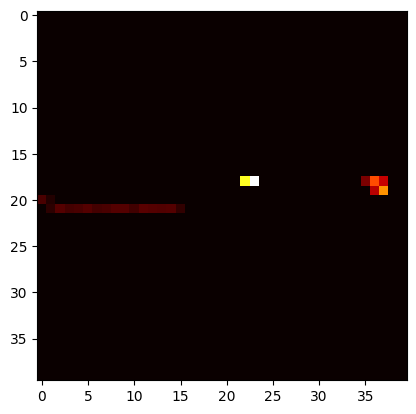

In [732]:
# Discretize the pedestrian distribution within a radius of the participant into a series of heatmaps.
test_ped_sample_timestamps = test_ped_sample['trial_ms'].unique()

position_heatmap = np.zeros(((int)(20/0.5),(int)(20/0.5)))
for sample_timestamp in test_ped_sample_timestamps:
    # Restrict to active pedestrians within a distance of the pedestrian. We could theoretically also restrict to agents that are only visible
    # This sample assumes within a radius of 20
    sample_at_timestamp = test_ped_sample[(test_ped_sample['trial_ms']==sample_timestamp) & (test_ped_sample['distance_from_participant'] <= 10)]
    # for this timestamp, produce a heatmap using a discretization factor. In this case, assume a dimensionality of 20x0.1 per axis
    # This heatmap is dependent on the relative positions, which gives us an idea of where each pedestrian is relative to the participant.
    sample_at_timestamp['rel_pos_x_centered'] = (sample_at_timestamp['rel_pos_x'] + 10.0)/0.5
    sample_at_timestamp['rel_pos_y_centered'] = (sample_at_timestamp['rel_pos_y'] + 10.0)/0.5
    rel_pos_columns = ['rel_pos_x_centered', 'rel_pos_y_centered']
    rel_pos_list = list(sample_at_timestamp[rel_pos_columns].itertuples(index=False, name=None))
    for rel_pos in rel_pos_list:
        rel_x = math.floor(rel_pos[0])
        rel_y = math.floor(20/0.5 - rel_pos[1])
        position_heatmap[rel_x,rel_y] += 1

print(position_heatmap)
plt.imshow(position_heatmap.T, cmap='hot', interpolation='nearest')

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2252642144.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['accel'].replace([np.inf, -np.inf], 0, inplace=True)
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2252642144.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

array([[<Axes: title={'center': 'trial_ms'}>]], dtype=object)

C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2252642144.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['accel'].replace([np.inf, -np.inf], 0, inplace=True)
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2252642144.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']
['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2252642144.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['accel'].replace([np.inf, -np.inf], 0, inplace=True)
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2252642144.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2252642144.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['accel'].replace([np.inf, -np.inf], 0, inplace=True)
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\2252642144.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

['eeg-aligned.csv', 'eeg.png', 'pedestrians-aligned.csv', 'raw_eeg.csv', 'trial.csv', 'user-aligned.csv']


C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['trial_seconds'] = colname_events['trial_ms']/1000
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colname_events['source'] = f'{frequency}_{electrode}'
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_45128\3515948496.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

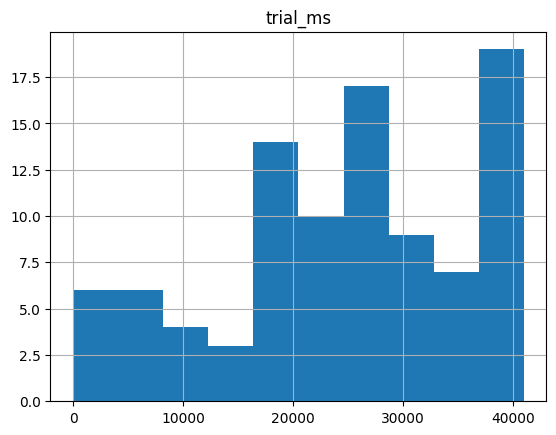

In [636]:
_FREQUENCY_BANDS = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
_FREQUENCY_COLORS = ['red', 'purple', 'blue', 'green', 'orange']
_ELECTRODE_CHANNELS = ['AF7', 'AF8'] #TP9, TP10

for pid in trial_files:
    for tid in trial_files[pid]:        
        print(trial_files[pid][tid])
        
        # get the necessary trial data
        tdir, trial_df, eeg_df, user_df, ped_df = get_trial_data(pid,tid)
        
        # Initialize a list of events. Events must be determined by EEG and Acceleration 
        
        # EEG events are dictated by EEG powers that deviate from 0.5SD of each frequency-channel column    
        eeg_events = []
        for frequency in _FREQUENCY_BANDS:
            if frequency in ['Delta','Theta']: continue
            for electrode in _ELECTRODE_CHANNELS:
                eeg_colname = f"{frequency}_{electrode}_Power_Recenter"
                colname_sd = eeg_df[eeg_colname].std()
                colname_event_rows = eeg_df[abs(eeg_df[eeg_colname]) >= 0.5*colname_sd]
                colname_events = colname_event_rows[['trial_ms']]
                colname_events['trial_seconds'] = colname_events['trial_ms']/1000
                colname_events['source'] = f'{frequency}_{electrode}'
                eeg_events.append(colname_events)
        # Derive events aggregated from eeg
        events_df = pd.concat(eeg_events)
        events_df.sort_values(by=['trial_ms'], inplace=True)
        
        # We have to iterate across each timestamp in our events. 
        
        
        if pid=='p1' and tid=='jay-vr-2':
        
        #tdirname = os.path.join(_PARTICIPANTS_DIR, pdir, tdir)
        #print(tdirname, len(df.index))
        #participant_trial_eegs = all_trial_eegs[(all_trial_eegs['participant'] == participant_id) & (all_trial_eegs['trial'] == trial_id)]
        #print(tdirname)

In [421]:
for pdir in trial_files:
    for tdir in trial_files[pdir]:
        tdirname = os.path.join(_PARTICIPANTS_DIR, pdir, tdir)
        
        # Reading the trial file
        user_file = os.path.join(tdirname, 'user-aligned.csv')
player_df = pd.read_csv(files[1])

# Calculating basics such as trial seconds, delta time, and speed.
player_grouped_df = player_df.groupby(['pos_x','pos_y','pos_z'],as_index=False).first().sort_values(by=['trial_milliseconds'])
player_grouped_df['trial_seconds'] = player_grouped_df['trial_milliseconds'] / 1000;
player_grouped_df['dt'] = player_grouped_df['trial_seconds'].diff().fillna(0)
player_grouped_df['speed'] = np.sqrt(player_grouped_df['velocity_x']**2 + player_grouped_df['velocity_z']**2)

# Calculating overall acceleration
player_grouped_df['accel'] = player_grouped_df['speed'].diff().fillna(0) / player_grouped_df['dt']
player_grouped_df['accel'].replace([np.inf, -np.inf], 0, inplace=True)
player_grouped_df['accel'].fillna(0, inplace=True)
player_grouped_df['accel^2'] = player_grouped_df['accel'].diff().fillna(0) / player_grouped_df['dt']
player_grouped_df['accel^2'].replace([np.inf, -np.inf], 0, inplace=True)
player_grouped_df['accel^2'].fillna(0, inplace=True)

# Calculating forward acceleration. In Unity space, -x = forward, +x = rightward
player_grouped_df['accel_x'] = player_grouped_df['velocity_x'].diff().fillna(0) / player_grouped_df['dt']
player_grouped_df['accel_x'].replace([np.inf, -np.inf], 0, inplace=True)
player_grouped_df['accel_x'].fillna(0, inplace=True)
player_grouped_df['accel_x^2'] = player_grouped_df['accel_x'].diff().fillna(0) / player_grouped_df['dt']
player_grouped_df['accel_x^2'].replace([np.inf, -np.inf], 0, inplace=True)
player_grouped_df['accel_x^2'].fillna(0, inplace=True)

# Calculating forward acceleration. In Unity Space, -z = leftward, +z = rightward
player_grouped_df['accel_z'] = player_grouped_df['velocity_z'].diff().fillna(0) / player_grouped_df['dt']
player_grouped_df['accel_z'].replace([np.inf, -np.inf], 0, inplace=True)
player_grouped_df['accel_z'].fillna(0, inplace=True)
player_grouped_df['accel_z^2'] = player_grouped_df['accel_z'].diff().fillna(0) / player_grouped_df['dt']
player_grouped_df['accel_z^2'].replace([np.inf, -np.inf], 0, inplace=True)
player_grouped_df['accel_z^2'].fillna(0, inplace=True)

# Standard deviation of acceleration and its derivative
accel_x_mean = player_grouped_df['accel_x'].mean()
accel_x_std = player_grouped_df['accel_x'].std()
accel_x2_mean = player_grouped_df['accel_x^2'].mean()
accel_x2_std = player_grouped_df['accel_x^2'].std()
accel_z_mean = player_grouped_df['accel_z'].mean()
accel_z_std = player_grouped_df['accel_z'].std()
accel_z2_mean = player_grouped_df['accel_z^2'].mean()
accel_z2_std = player_grouped_df['accel_z^2'].std()

# Re-index
player_grouped_df.reset_index(inplace=True)

print("\t", accel_x2_mean, accel_x2_std)
print("\t", accel_z2_mean, accel_z2_std)
player_grouped_df

./samples/participant_data_aligned/p1\jay-vr-2
./samples/participant_data_aligned/p10\jay-vr-3
./samples/participant_data_aligned/p11\jay-vr-1
./samples/participant_data_aligned/p11\jay-vr-2
./samples/participant_data_aligned/p11\jay-vr-3
./samples/participant_data_aligned/p12\jay-vr-2
./samples/participant_data_aligned/p12\jay-vr-3
./samples/participant_data_aligned/p14\jay-vr-1
./samples/participant_data_aligned/p14\jay-vr-2
./samples/participant_data_aligned/p14\jay-vr-3
./samples/participant_data_aligned/p15\jay-vr-1
./samples/participant_data_aligned/p15\jay-vr-2
./samples/participant_data_aligned/p15\jay-vr-3
./samples/participant_data_aligned/p15\jay-vr-4
./samples/participant_data_aligned/p15\jay-vr-5
./samples/participant_data_aligned/p16\jay-vr-1
./samples/participant_data_aligned/p16\jay-vr-2
./samples/participant_data_aligned/p16\jay-vr-3
./samples/participant_data_aligned/p16\jay-vr-4
./samples/participant_data_aligned/p17\jay-vr-1
./samples/participant_data_aligned/p17\ja

In [394]:
for pdir in trial_files:
    print(pdir)
    for tdir in trial_files[pdir]:
        print("-", tdir)
        for f in trial_files[pdir][tdir]:
            print("---", f)

p1
- jay-vr-1
--- eeg-aligned.csv
--- eeg.csv
--- pedestrians-aligned.csv
--- raw_eeg.csv
--- trial.csv
--- user-aligned.csv
- jay-vr-2
--- pedestrians-aligned.csv
--- raw_eeg.csv
--- trial.csv
--- user-aligned.csv
p10
- jay-vr-1
--- pedestrians-aligned.csv
--- raw_eeg.csv
--- trial.csv
--- user-aligned.csv
- jay-vr-2
--- pedestrians-aligned.csv
--- raw_eeg.csv
--- trial.csv
--- user-aligned.csv
- jay-vr-3
--- pedestrians-aligned.csv
--- raw_eeg.csv
--- trial.csv
--- user-aligned.csv
p11
- jay-vr-1
--- pedestrians-aligned.csv
--- raw_eeg.csv
--- trial.csv
--- user-aligned.csv
- jay-vr-2
--- pedestrians-aligned.csv
--- raw_eeg.csv
--- trial.csv
--- user-aligned.csv
- jay-vr-3
--- pedestrians-aligned.csv
--- raw_eeg.csv
--- trial.csv
--- user-aligned.csv
p12
- jay-vr-1
--- pedestrians-aligned.csv
--- raw_eeg.csv
--- trial.csv
--- user-aligned.csv
- jay-vr-2
--- pedestrians-aligned.csv
--- raw_eeg.csv
--- trial.csv
--- user-aligned.csv
- jay-vr-3
--- pedestrians-aligned.csv
--- raw_eeg.cs

In [ ]:
src_dir = './samples/participant_data_aligned/p7/jay-vr-2'

# This contains the raw EEG filenames
files = [join(src_dir,f) for f in listdir(src_dir) if isfile(join(src_dir, f))]
print(files)

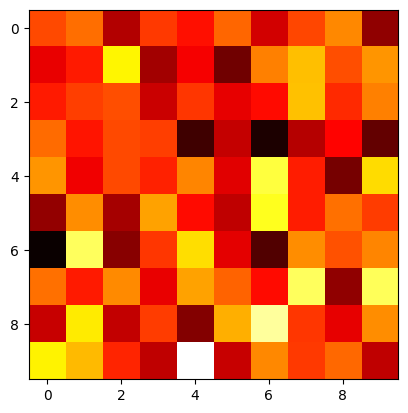

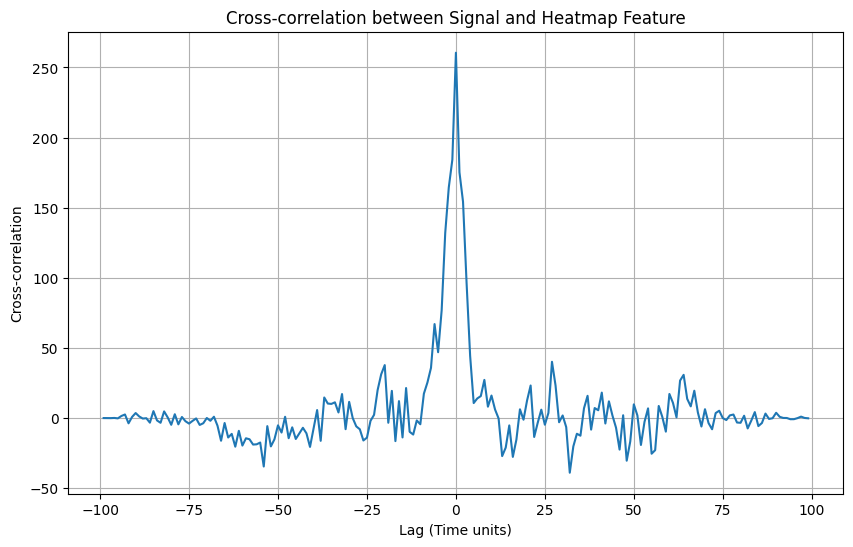

In [694]:
from scipy.signal import correlate

# Example data (just for illustration)
# Generate some synthetic signal data (time series)
time_points = 100
signal_data = np.random.randn(time_points)  # Random signal, you can replace it with your actual data
signal_data[30:35] = 5  # Simulating a signal spike

# Generate synthetic heatmap data for the corresponding time points
heatmap_data = np.random.randn(time_points, 10, 10)  # 10x10 heatmap at each timestamp
# Simulating some spatial change in the heatmap, e.g., spatial movement
heatmap_data[30:35, 4, 4] = 10  # This could represent an object moving in the heatmap area
plt.imshow(heatmap_data[0], cmap='hot', interpolation='nearest')

# Flatten the heatmap data for simplicity (you may use your actual flattened heatmap data)
flattened_heatmap = heatmap_data.reshape(time_points, -1)  # Flatten each 10x10 heatmap to a 100-dimensional vector


# Choose a specific heatmap feature to correlate with the signal (e.g., the value at a specific location)
heatmap_feature = flattened_heatmap[:, 4*10 + 4]  # This picks the value at position (4, 4) of the 10x10 heatmap

# Compute cross-correlation between signal and heatmap feature
cross_corr = correlate(signal_data, heatmap_feature, mode='full')

# Compute the time lag indices
lags = np.arange(-len(signal_data) + 1, len(signal_data))

# Plot the cross-correlation
plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr)
plt.title('Cross-correlation between Signal and Heatmap Feature')
plt.xlabel('Lag (Time units)')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (199,) and (999,)

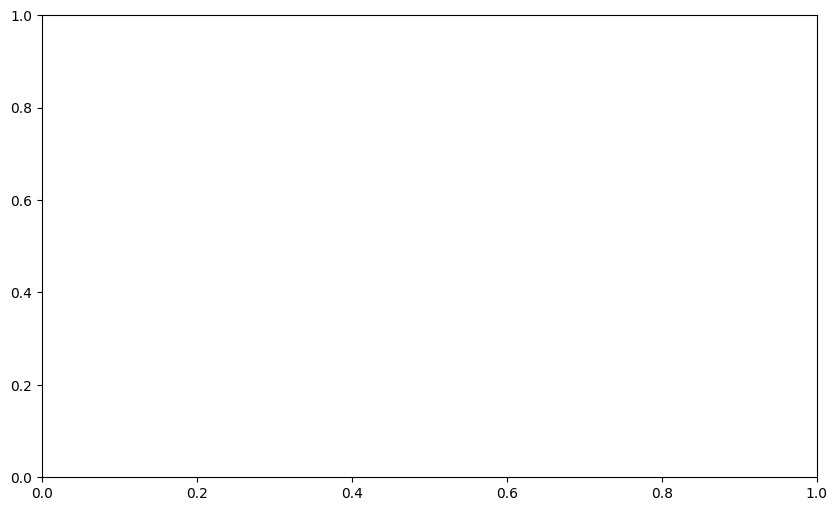

In [699]:
# Example data (just for illustration)
time_points = 100
signal_data = np.random.randn(time_points)  # Random signal, you can replace it with your actual data
signal_data[30:35] = 5  # Simulating a signal spike

# Example heatmap data (10x10 grid at each timestamp)
heatmap_data = np.random.randn(time_points, 10, 10)  # 10x10 heatmap at each timestamp
heatmap_data[30:35, 4, 4] = 10  # Simulating a spatial movement in the heatmap

# Define the region of interest (ROI) in the heatmap (for example, a 3x3 region from the center)
region_size = 3
center = 5  # Center of the heatmap (for a 10x10 grid, it would be index 5)

# Extract the region from the heatmap at each timestamp
roi_data = heatmap_data[:, center-region_size//2:center+region_size//2+1, center-region_size//2:center+region_size//2+1]

# Flatten the ROI data for each timestamp (3x3 matrix per timestamp)
flattened_roi = roi_data.reshape(time_points, -1)  # Flatten the 3x3 region into a 9-dimensional vector

# Compute cross-correlation between the flattened ROI and the signal
cross_corr = correlate(signal_data, flattened_roi.flatten(), mode='full')

# Compute the time lag indices
lags = np.arange(-len(signal_data) + 1, len(signal_data))

# Plot the cross-correlation
plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr)
plt.title('Cross-correlation between Signal and Region of Interest in Heatmap')
plt.xlabel('Lag (Time units)')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.show()

In [159]:
avgdist_corr_df = pd.read_csv('./samples/damien/avgdist_eeg_corr.csv').to_dict()
avgdist_corr_df

{'Delta_AF7/avgdist_corr': {0: -0.004825805},
 'Delta_AF7/avgdist_pvalue': {0: 0.903399902},
 'Delta_AF8/avgdist_corr': {0: 0.12837776},
 'Delta_AF8/avgdist_pvalue': {0: 0.001186656},
 'Theta_AF7/avgdist_corr': {0: 0.012741837},
 'Theta_AF7/avgdist_pvalue': {0: 0.748616183},
 'Theta_AF8/avgdist_corr': {0: 0.154859408},
 'Theta_AF8/avgdist_pvalue': {0: 8.92e-05},
 'Alpha_AF7/avgdist_corr': {0: 0.025586289},
 'Alpha_AF7/avgdist_pvalue': {0: 0.519841861},
 'Alpha_AF8/avgdist_corr': {0: 0.047035852},
 'Alpha_AF8/avgdist_pvalue': {0: 0.236577003},
 'Beta_AF7/avgdist_corr': {0: 0.070397415},
 'Beta_AF7/avgdist_pvalue': {0: 0.076284484},
 'Beta_AF8/avgdist_corr': {0: 0.092761436},
 'Beta_AF8/avgdist_pvalue': {0: 0.019389756},
 'Gamma_AF7/avgdist_corr': {0: 0.071886641},
 'Gamma_AF7/avgdist_pvalue': {0: 0.070255524},
 'Gamma_AF8/avgdist_corr': {0: 0.077609355},
 'Gamma_AF8/avgdist_pvalue': {0: 0.050607867}}

### Avg Distance

Something's up here.

|Band-Electrode Combo|Statistic|P-value|
|:-|:-:|:-:|
|Delta_AF7|-0.004825805|0.903399902|
|__Delta_AF8__|0.12837776|0.001186656|
|Theta_AF7|0.012741837|0.748616183|
|__Theta_AF8__|0.154859408|8.92e-05|
|Alpha_AF7|0.025586289|0.519841861|
|Alpha_AF8|0.047035852|0.236577003|
|Beta_AF7|0.070397415|0.076284484|
|__Beta_AF8__|0.092761436|0.019389756|
|Gamma_AF7|0.071886641|0.070255524|
|Gamma_AF8|0.077609355|0.050607867|

In [161]:
count_corr_df = pd.read_csv('./samples/damien/count_eeg_corr.csv').to_dict()
count_corr_df

{'Delta_AF7/count_corr': {0: -0.124757248},
 'Delta_AF7/count_pvalue': {0: 0.000980994},
 'Delta_AF8/count_corr': {0: -0.161140231},
 'Delta_AF8/count_pvalue': {0: 1.97e-05},
 'Theta_AF7/count_corr': {0: -0.04874232},
 'Theta_AF7/count_pvalue': {0: 0.1993392},
 'Theta_AF8/count_corr': {0: -0.113662243},
 'Theta_AF8/count_pvalue': {0: 0.00269274},
 'Alpha_AF7/count_corr': {0: -0.016580296},
 'Alpha_AF7/count_pvalue': {0: 0.662584921},
 'Alpha_AF8/count_corr': {0: -0.021580107},
 'Alpha_AF8/count_pvalue': {0: 0.570065359},
 'Beta_AF7/count_corr': {0: 0.002772213},
 'Beta_AF7/count_pvalue': {0: 0.941844289},
 'Beta_AF8/count_corr': {0: 0.03989722},
 'Beta_AF8/count_pvalue': {0: 0.293566673},
 'Gamma_AF7/count_corr': {0: 0.0135319},
 'Gamma_AF7/count_pvalue': {0: 0.721755461},
 'Gamma_AF8/count_corr': {0: 0.041415973},
 'Gamma_AF8/count_pvalue': {0: 0.275560908}}

### Min Distance

Something's up here.

|Band-Electrode Combo|Statistic|P-value|
|:-|:-:|:-:|
|Delta_AF7|-0.124757248|0.000980994|
|__Delta_AF8__|-0.161140231|1.97e-05|
|Theta_AF7|-0.04874232|0.1993392|
|__Theta_AF8__|-0.113662243|0.00269274|
|Alpha_AF7|-0.016580296|0.662584921|
|Alpha_AF8|-0.021580107|0.570065359|
|Beta_AF7|0.002772213|0.941844289|
|Beta_AF8|0.03989722|0.293566673|
|Gamma_AF7|0.0135319|0.721755461|
|Gamma_AF8|0.041415973|0.275560908|

In [163]:
min_dist_corr_df = pd.read_csv('./samples/damien/min_dist_eeg_corr.csv').to_dict()
min_dist_corr_df

{'Delta_AF7/min_dist_corr': {0: -0.052544731},
 'Delta_AF7/min_dist_pvalue': {0: 0.186038213},
 'Delta_AF8/min_dist_corr': {0: 0.093257844},
 'Delta_AF8/min_dist_pvalue': {0: 0.018747313},
 'Theta_AF7/min_dist_corr': {0: -0.053200297},
 'Theta_AF7/min_dist_pvalue': {0: 0.180599268},
 'Theta_AF8/min_dist_corr': {0: 0.108947998},
 'Theta_AF8/min_dist_pvalue': {0: 0.005992741},
 'Alpha_AF7/min_dist_corr': {0: -0.021778632},
 'Alpha_AF7/min_dist_pvalue': {0: 0.583837542},
 'Alpha_AF8/min_dist_corr': {0: 0.001057914},
 'Alpha_AF8/min_dist_pvalue': {0: 0.978773921},
 'Beta_AF7/min_dist_corr': {0: 0.064540363},
 'Beta_AF7/min_dist_pvalue': {0: 0.104193276},
 'Beta_AF8/min_dist_corr': {0: 0.050885688},
 'Beta_AF8/min_dist_pvalue': {0: 0.200340456},
 'Gamma_AF7/min_dist_corr': {0: 0.073477964},
 'Gamma_AF7/min_dist_pvalue': {0: 0.064250139},
 'Gamma_AF8/min_dist_corr': {0: 0.085309404},
 'Gamma_AF8/min_dist_pvalue': {0: 0.031601659}}

### Min Distance

Why is there a bias on even numbered sides?

|Band-Electrode Combo|Statistic|P-value|
|:-|:-:|:-:|
|Delta_AF7|-0.052544731|0.186038213|
|__Delta_AF8__|0.093257844|0.018747313|
|Theta_AF7|-0.053200297|0.180599268|
|__Theta_AF8__|0.108947998|0.005992741|
|Alpha_AF7|-0.021778632|0.583837542|
|Alpha_AF8|0.001057914|0.978773921|
|Beta_AF7|0.064540363|0.104193276|
|Beta_AF8|0.050885688|0.200340456|
|Gamma_AF7|0.073477964|0.064250139|
|__Gamma_AF8__|0.085309404|0.031601659|

In [164]:
vel_corr_df = pd.read_csv('./samples/damien/vel_eeg_corr.csv').to_dict()
vel_corr_df

{'Delta_AF7/vel_corr': {0: 0.110994155},
 'Delta_AF7/vel_pvalue': {0: 0.005108516},
 'Delta_AF8/vel_corr': {0: 0.025413775},
 'Delta_AF8/vel_pvalue': {0: 0.522661333},
 'Theta_AF7/vel_corr': {0: 0.031818272},
 'Theta_AF7/vel_pvalue': {0: 0.423468592},
 'Theta_AF8/vel_corr': {0: -0.031447397},
 'Theta_AF8/vel_pvalue': {0: 0.428895116},
 'Alpha_AF7/vel_corr': {0: 0.050758303},
 'Alpha_AF7/vel_pvalue': {0: 0.20147084},
 'Alpha_AF8/vel_corr': {0: -0.011414349},
 'Alpha_AF8/vel_pvalue': {0: 0.774054771},
 'Beta_AF7/vel_corr': {0: 0.057979401},
 'Beta_AF7/vel_pvalue': {0: 0.144459431},
 'Beta_AF8/vel_corr': {0: -0.010869972},
 'Beta_AF8/vel_pvalue': {0: 0.784558771},
 'Gamma_AF7/vel_corr': {0: 0.042015079},
 'Gamma_AF7/vel_pvalue': {0: 0.290453425},
 'Gamma_AF8/vel_corr': {0: 0.029237976},
 'Gamma_AF8/vel_pvalue': {0: 0.462047591}}

### Velocity Differences

Not... very good results

|Band-Electrode Combo|Statistic|P-value|
|:-|:-:|:-:|
|__Delta_AF7__|0.110994155|0.005108516|
|Delta_AF8|0.025413775|0.522661333|
|Theta_AF7|0.031818272|0.423468592|
|Theta_AF8|-0.031447397|0.428895116|
|Alpha_AF7|0.050758303|0.20147084|
|Alpha_AF8|-0.011414349|0.774054771|
|Beta_AF7|0.057979401|0.144459431|
|Beta_AF8|-0.010869972|0.784558771|
|Gamma_AF7|0.042015079|0.290453425|
|Gamma_AF8|0.029237976|0.462047591|

In [165]:
haus_corr_df = pd.read_csv('./samples/damien/hausdorff_eeg_corr.csv').to_dict()
haus_corr_df

{'Delta_AF7_hausdorff_corr': {0: 0.032262931},
 'Delta_AF7_hausdorff_pvalue': {0: 0.406534682},
 'Delta_AF8_hausdorff_corr': {0: -0.131269367},
 'Delta_AF8_hausdorff_pvalue': {0: 0.000696673},
 'Theta_AF7_hausdorff_corr': {0: 0.029301485},
 'Theta_AF7_hausdorff_pvalue': {0: 0.45097793},
 'Theta_AF8_hausdorff_corr': {0: -0.14773854},
 'Theta_AF8_hausdorff_pvalue': {0: 0.000133036},
 'Alpha_AF7_hausdorff_corr': {0: -0.011354746},
 'Alpha_AF7_hausdorff_pvalue': {0: 0.770248809},
 'Alpha_AF8_hausdorff_corr': {0: -0.043854743},
 'Alpha_AF8_hausdorff_pvalue': {0: 0.259120877},
 'Beta_AF7_hausdorff_corr': {0: 0.134172014},
 'Beta_AF7_hausdorff_pvalue': {0: 0.000527198},
 'Beta_AF8_hausdorff_corr': {0: 0.074024765},
 'Beta_AF8_hausdorff_pvalue': {0: 0.056584455},
 'Gamma_AF7_hausdorff_corr': {0: 0.105775445},
 'Gamma_AF7_hausdorff_pvalue': {0: 0.006368794},
 'Gamma_AF8_hausdorff_corr': {0: 0.027564144},
 'Gamma_AF8_hausdorff_pvalue': {0: 0.478278089}}

### Hausdorff Distance between Trajectories

I'm surprised this is a thing, but I guess this is possible.
Better results, might replace velocity correlations.
These results apparently are the result of 2sec intervals around each EEG point. What I don't understand if these are before, after, or around each EEG signal or not.

|Band-Electrode Combo|Statistic|P-value|
|:-|:-:|:-:|
|Delta_AF7|0.032262931|0.406534682|
|__Delta-AF8__|__-0.131269367__|__0.000696673__|
|Theta_AF7|0.029301485|0.45097793|
|__Theta_AF8__|__-0.14773854__|__0.000133036__|
|Alpha_AF7|-0.011354746|0.770248809|
|Alpha_AF8|-0.043854743|0.259120877|
|__Beta_AF7__|__0.134172014__|__0.000527198__|
|Beta_AF8|0.074024765|0.056584455|
|__Gamma_AF7__|__0.105775445__|__0.006368794__|
|Gamma_AF8|0.027564144|0.478278089|

The issue here is these correlations are incredibly weak. According to [this document](https://www.statstutor.ac.uk/resources/uploaded/spearmans.pdf), we have the following scale:

* `.00-.19` = very weak
* `.20-.39` = weak
* `.40-.59` = moderate
* `.60-.79` = strong
* `.80-1.0` = very strong

None of the values we have are at least weak - all statistically significant values are "very weak". That's not optimal at all...